<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments</font></b>

# Introduction

## Contexte

Le projet se situe dans le cadre des efforts de la ville de Seattle pour atteindre son objectif de neutralité carbone d'ici 2050, un enjeu majeur dans la lutte contre le changement climatique. L'accent est mis sur l'analyse de la consommation énergétique et des émissions de dioxyde de carbone (CO2) des bâtiments non résidentiels, une composante significative de l'empreinte carbone de la ville. Pour cela, la ville dispose de données collectées en 2016, reflétant les consommations et émissions des bâtiments à cette période. Ces données, bien que précieuses, sont coûteuses et laborieuses à obtenir, d'où l'intérêt de développer un modèle prédictif capable d'estimer ces indicateurs pour les bâtiments non encore analysés, basé sur des caractéristiques structurelles telles que la taille, l'usage, la date de construction, ou encore la situation géographique des bâtiments.

## Objectifs

Tout d'abvord, réaliser une analyse exploratoire des données disponibles afin d'identifier les tendances, les anomalies et les relations potentielles entre les différentes variables. Et ensuite tester et comparer différents modèles de machine learning pour prédire avec précision la consommation totale d'énergie et les émissions de CO2 des bâtiments non résidentiels, sans données de consommation annuelle future, pour éviter toute fuite de données. Un intérêt particulier est porté à l'évaluation de l'utilité de l'"ENERGY STAR Score", un indicateur potentiellement pertinent mais complexe à calculer avec les méthodes actuelles. 

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import Image

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Council District Map - 2024 - FULL.png',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024-svg.ipynb',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Deveau_Estelle_2_notebook_prediction_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'plan-codes-postaux -seattle.jpg']

In [3]:
os.listdir("data/sources/")

['2016_Building_Energy_Benchmarking.csv']

In [4]:
path     = "./data/sources/"
filename = "2016_Building_Energy_Benchmarking.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exploration des données

## Quick tour

In [7]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [8]:
data.shape

(3376, 46)

In [9]:
data.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

In [10]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

In [11]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.85 %


In [13]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
OSEBuildingID                                               0   
DataYear                                                    0   
BuildingType                                                0   
PrimaryPropertyType                                         0   
PropertyName                                                0   
Address                                                     0   
City                                                        0   
State                                                       0   
ZipCode                                                    16   
TaxParcelIdentificationNumber                               0   
CouncilDistrictCode                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
YearBuilt                                                   0   
NumberofBuildings                                           8   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
PropertyGFABuilding(s)                                      0   
ListOfAllPropertyUseTypes                                   9   
LargestPropertyUseType                                     20   
LargestPropertyUseTypeGFA                                  20   
SecondLargestPropertyUseType                             1697   
SecondLargestPropertyUseTypeGFA                          1697   
ThirdLargestPropertyUseType                              2780   
ThirdLargestPropertyUseTypeGFA                           2780   
YearsENERGYSTARCertified                                 3257   
ENERGYSTARScore                                           843   
SiteEUI(kBtu/sf)                                            7   
SiteEUIWN(kBtu/sf)                                          6   
SourceEUI(kBtu/sf)                                          9   
SourceEUIWN(kBtu/sf)                                        9   
SiteEnergyUse(kBtu)                                         5   
SiteEnergyUseWN(kBtu)                                       6   
SteamUse(kBtu)                                              9   
Electricity(kWh)                                            9   
Electricity(kBtu)                                           9   
NaturalGas(therms)                                          9   
NaturalGas(kBtu)                                            9   
DefaultData                                                 0   
Comments                                                 3376   
ComplianceStatus                                            0   
Outlier                                                  3344   
TotalGHGEmissions                                           9   
GHGEmissionsIntensity                                       9   

                                 Pourcentage de valeurs manquantes  
OSEBuildingID                                                 0.00  
DataYear                                                      0.00  
BuildingType                                                  0.00  
PrimaryPropertyType                                           0.00  
PropertyName                                                  0.00  
Address                                                       0.00  
City                                                          0.00  
State                                                         0.00  
ZipCode                                                       0.47  
TaxParcelIdentificationNumber                                 0.00  
CouncilDistrictCode                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude  

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

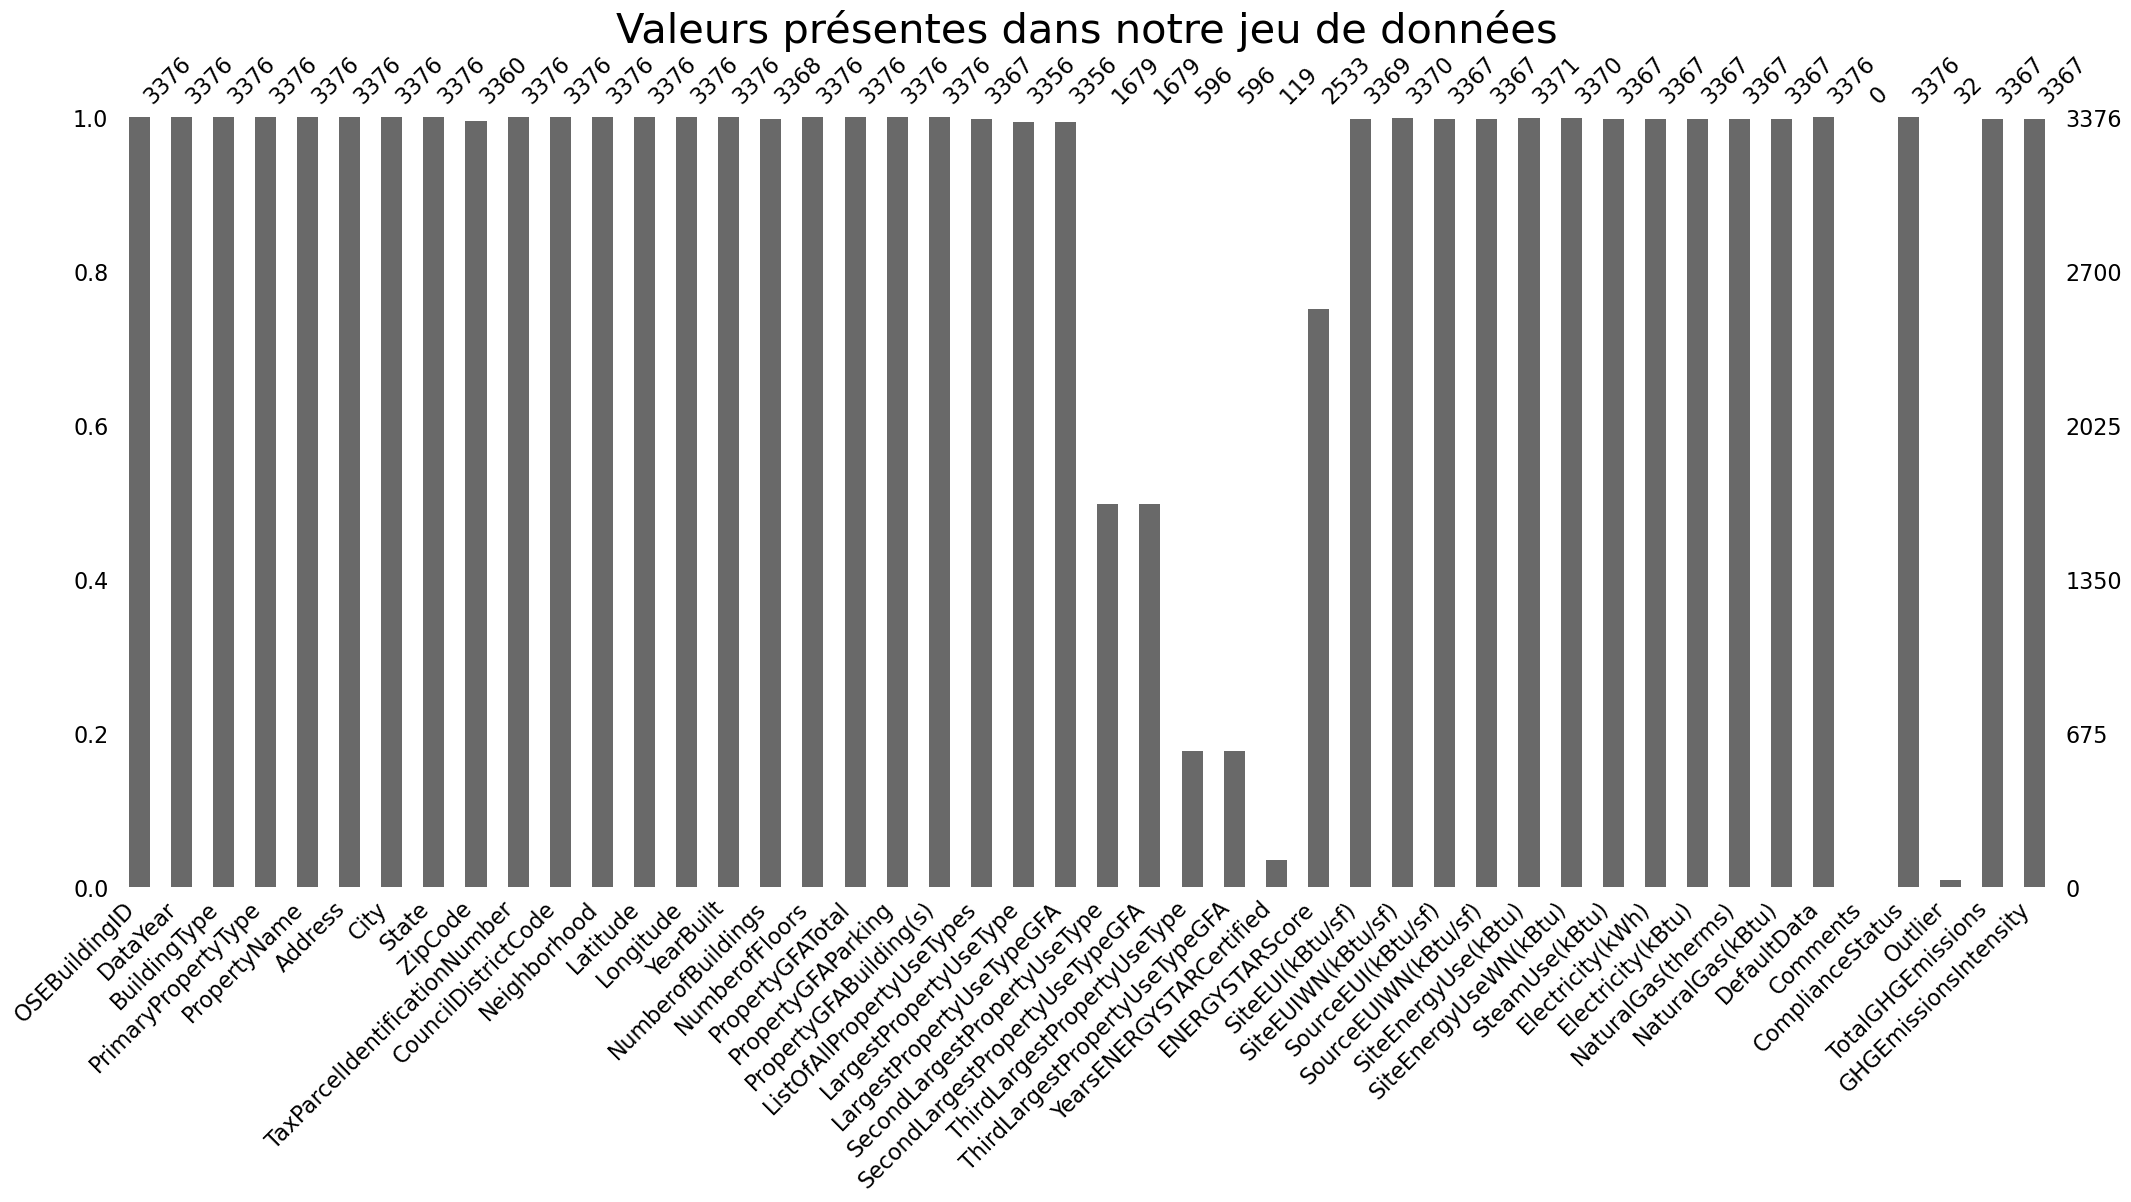

In [14]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

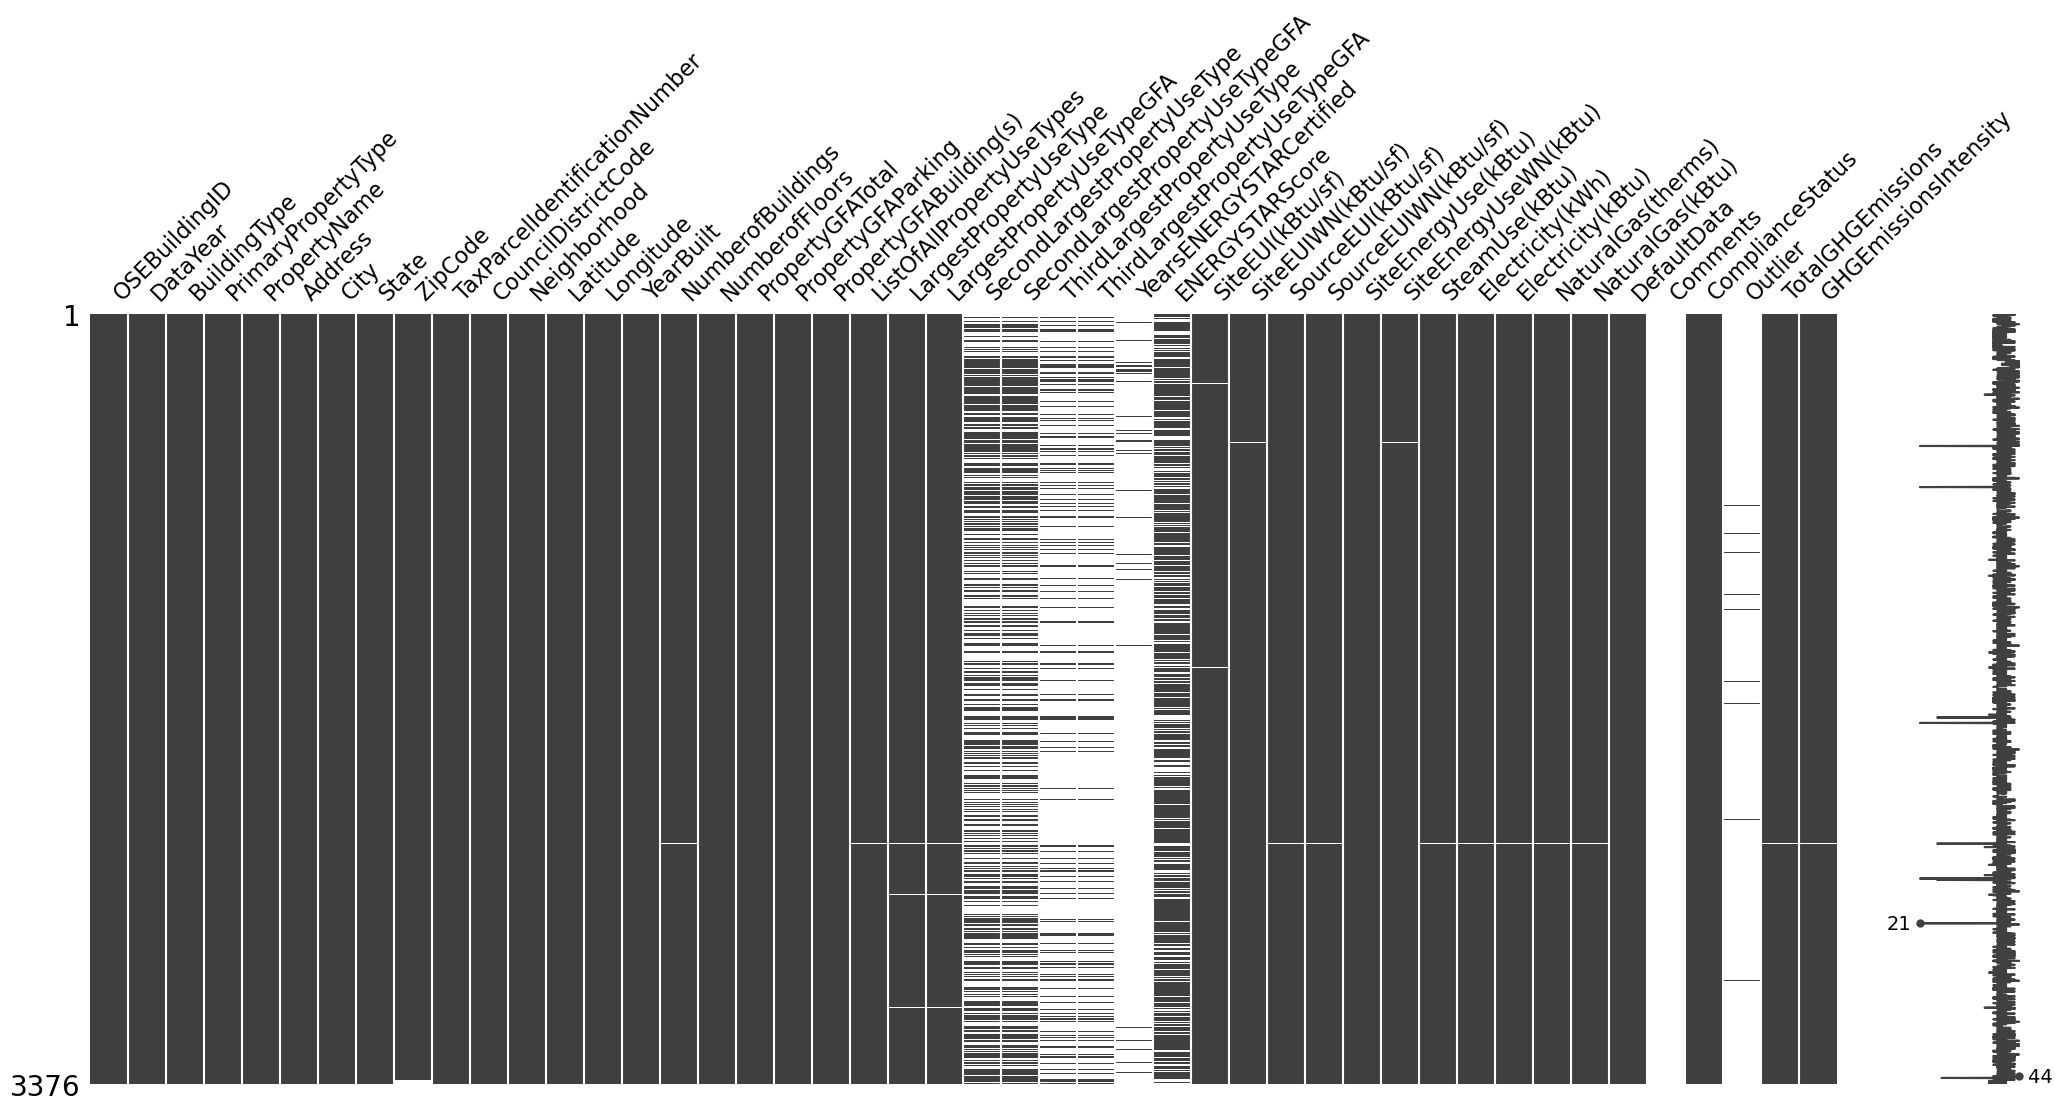

In [15]:
msno.matrix(data)

<Axes: >

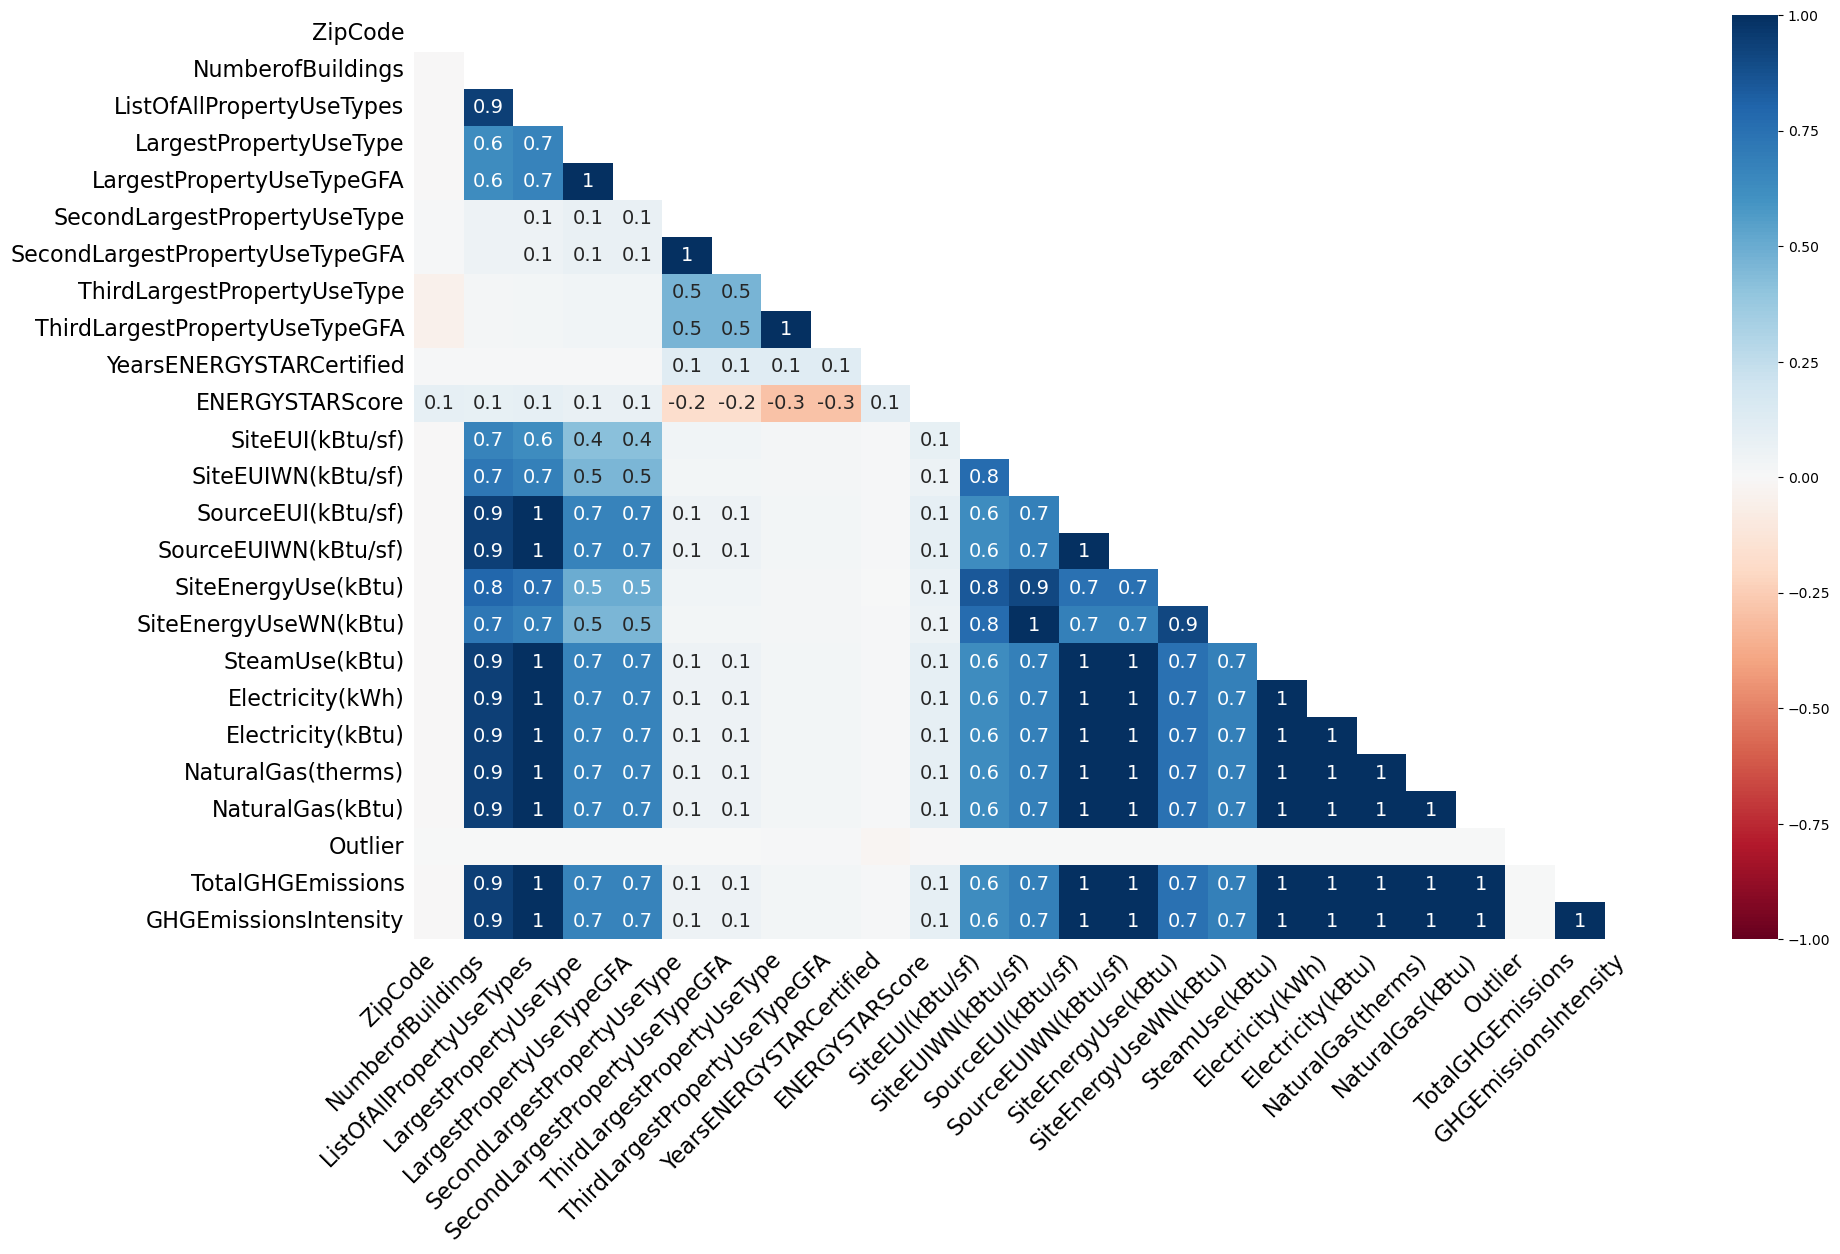

In [16]:
msno.heatmap(data)

## Définition et Compréhension des Variables

Après examen de la liste des variables et de leur définitions (https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy/about_data), nous avons établi la liste suivante :


| Name                          | Definition                                                                                     | Useful | Note |
|-------------------------------|------------------------------------------------------------------------------------------------|--------|------|
| OSEBuildingID                 | Identifiant unique attribué à chaque propriété couverte par l'ordonnance de référencement de Seattle. | Oui    | Essentiel pour suivre et identifier les propriétés |
| DataYear                      | Année civile représentée par chaque enregistrement de données.                                  | Non    |      |
| BuildingType                  | Classification du type de bâtiment de la ville de Seattle.                                     | Oui    | Utile pour des analyses par type de bâtiment |
| PrimaryPropertyType           | Utilisation principale d'une propriété (ex : bureau, magasin de détail).                        | Oui    | Utile pour des analyses par type d'utilisation |
| PropertyName                  | Nom officiel ou courant de la propriété.                                                        | Non    |      |
| Address                       | Adresse de la propriété.                                                                        | Oui    | Utile pour verifier les outliers |
| City                       | Ville de la propriété.                                                                        | Non    |      |
| State                       | Etat de la propriété.                                                                        | Non    |      |
| ZipCode                       | Code postal de la propriété.                                                                    | Oui    | Utile pour verifier les outliers |
| TaxParcelIdentificationNumber | Numéro d'identification de la parcelle fiscale de la propriété.                                 | Non    |      |
| CouncilDistrictCode           | Code du district du conseil de la ville de Seattle de la propriété.                             | Oui    | Utile pour des analyses géographiques |
| Neighborhood                  | Quartier de la propriété défini par le département des quartiers de la ville de Seattle.         | Oui    | Utile pour des analyses géographiques |
| Latitude                      | Latitude de la propriété.                                                                       | Oui    | Essentiel pour des analyses géospatiales |
| Longitude                     | Longitude de la propriété.                                                                      | Oui    | Essentiel pour des analyses géospatiales |
| YearBuilt                     | Année de construction de la propriété.                                                          | Oui    | Utile pour des analyses liées à l'âge du bâtiment |
| NumberofBuildings             | Nombre de bâtiments inclus dans le rapport de la propriété.                                     | Oui    | Utile pour des analyses de taille et de complexité |
| NumberofFloors                | Nombre d'étages signalés dans Portfolio Manager.                                                 | Oui    | Utile pour des analyses de taille et de complexité |
| PropertyGFATotal              | Surface brute totale du bâtiment et du parking.                                                 | Oui    | Utile pour des analyses de taille |
| PropertyGFAParking            | Espace total en pieds carrés de tous les types de stationnement.                                | Oui    | Utile pour des analyses de taille |
| PropertyGFABuilding(s)        | Surface brute totale en pieds carrés entre les surfaces extérieures des murs d'enceinte du bâtiment. | Oui    | Utile pour des analyses de taille |
| ListOfAllPropertyUseTypes     | Toutes les utilisations de la propriété signalées dans Portfolio Manager.                        | Non    |     |
| LargestPropertyUseType        | La plus grande utilisation de la propriété par la surface brute.                                | Oui    | Utile pour des analyses par type d'utilisation |
| LargestPropertyUseTypeGFA     | Surface brute de la plus grande utilisation de la propriété.                                    | Oui    | Utile pour des analyses par type d'utilisation |
| SecondLargestPropertyUseType  | La deuxième plus grande utilisation de la propriété par la surface brute.                        | Oui    | Utile pour des analyses par type d'utilisation |
| SecondLargestPropertyUseTypeGFA | Surface brute de la deuxième plus grande utilisation de la propriété.                          | Oui    | Utile pour des analyses par type d'utilisation |
| ThirdLargestPropertyUseType   | La troisième plus grande utilisation de la propriété par la surface brute.                       | Oui    | Utile pour des analyses par type d'utilisation |
| ThirdLargestPropertyUseTypeGFA| Surface brute de la troisième plus grande utilisation de la propriété.                          | Oui    | Utile pour des analyses par type d'utilisation |
| YearsENERGYSTARCertified      | Années où la propriété a reçu la certification ENERGY STAR.                                     | Non    |      |
| ENERGYSTARScore               | Score calculé pour évaluer la performance énergétique globale de la propriété.               | Oui    | Objectif |
| SiteEUI(kBtu/sf)              | Intensité d'utilisation de l'énergie sur site (EUI) de la propriété.                            | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEUIWN(kBtu/sf)            | EUI du site normalisée (WN) de la propriété.                                  | Oui    | Fuite des données mais utile pour des vérifications |
| SourceEUI(kBtu/sf)            | Intensité d'utilisation de l'énergie source (EUI) de la propriété.                              | Oui    | Fuite des données mais utile pour des vérifications |
| SourceEUIWN(kBtu/sf)          | EUI de l'énergie source normalisée (WN) de la propriété.                            | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEnergyUse(kBtu)           | Quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie. | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEnergyUseWN(kBtu)         | Quantité annuelle d'énergie consommée par la propriété, ajustée aux conditions météorologiques moyennes sur 30 ans. | Oui | Objectif |
| SteamUse(kBtu)                | Quantité annuelle de vapeur de district consommée par la propriété sur place.                    | Oui    | Fuite des données mais peut indiquer la nature de la source d'energie |
| Electricity(kWh)              | Quantité annuelle d'électricité consommée par la propriété sur place.                            | Oui    | Fuite des données mais utile pour des vérifications |
| Electricity(kBtu)             | Quantité annuelle d'électricité consommée par la propriété sur place, mesurée en milliers de BTU. | Oui    | Fuite des données mais peut indiquer la nature de la source d'energie |
| NaturalGas(therms)            | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété.     | Oui    | Fuite des données mais utile pour des vérifications |
| NaturalGas(kBtu)              | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en milliers de BTU. | Oui | Fuite des données mais peut indiquer la nature de la source d'energie |
| DefaultData                   | La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété.  | Non    |      |
| Comments                      | Commentaires d'un propriétaire ou d'un agent pour fournir un contexte à l'utilisation de l'énergie du bâtiment. | Non  |      |
| ComplianceStatus              | Si une propriété a respecté les exigences de référencement énergétique pour l'année de déclaration en cours. | Oui  |      |
| Outlier                       | Si une propriété est un cas extrême élevé ou faible (O/N).                                       | Oui    |      |
| TotalGHGEmissions             | Quantité totale d'émissions de gaz à effet de serre.                                             | Oui    | Objectif |
| GHGEmissionsIntensity         | Émissions totales de gaz à effet de serre divisées par la surface brute de la propriété.         | Oui    | Fuite des données mais utile pour des vérifications |

In [17]:
cols_to_drop = ['DataYear', 'City', 'State', 'PropertyName','TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes',
                'YearsENERGYSTARCertified', 'DefaultData','Comments']

# Liste de toutes les colonnes à conserver
cols_to_keep = data.columns.difference(cols_to_drop)

# Nettoyage des Données

## Format des données

In [18]:
data[cols_to_keep].dtypes

Address                             object
BuildingType                        object
ComplianceStatus                    object
CouncilDistrictCode                  int64
ENERGYSTARScore                    float64
Electricity(kBtu)                  float64
Electricity(kWh)                   float64
GHGEmissionsIntensity              float64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
Longitude                          float64
NaturalGas(kBtu)                   float64
NaturalGas(therms)                 float64
Neighborhood                        object
NumberofBuildings                  float64
NumberofFloors                       int64
OSEBuildingID                        int64
Outlier                             object
PrimaryPropertyType                 object
PropertyGFABuilding(s)               int64
PropertyGFAParking                   int64
PropertyGFATotal                     int64
SecondLarge

In [19]:
# Verification des années
print("Valeurs uniques pour YearBuilt dans data:", data['YearBuilt'].unique())

Valeurs uniques pour YearBuilt dans data: [1927 1996 1969 1926 1980 1999 1904 1910 1998 1928 1922 2004 1930 1983
 1907 1916 1985 1961 2001 1991 1955 1978 1949 1989 1906 1994 1992 1990
 1950 1900 1954 1911 1973 1920 1982 1908 1959 2000 1997 1962 1970 2008
 1948 1965 1929 2010 1938 1986 2002 1923 2003 1957 1964 1941 1963 2006
 1915 1958 2009 2011 1971 2007 1951 1953 1952 1960 1937 1966 1968 1925
 1924 2005 1909 1931 1972 1914 1913 1917 1995 1981 1976 1988 1979 1947
 1984 1956 1912 1977 1921 1945 1974 1975 1946 1967 1987 1940 1932 1993
 1918 1905 1902 1939 1944 1942 1903 2012 2013 2015 1901 1919 2014 1936
 1935]


Le format de l'année dans YearBuilt est en int mais ce n'est pas génant donc nous le laissons ainsi et remplaçons cette colonne par l'âge du batiment.

In [20]:
# Calculer l'âge des bâtiments et créer la colonne 'BuildingAge'
data['BuildingAge'] = 2016 - data['YearBuilt']

# Supprimer la colonne 'YearBuilt'
data.drop(columns=['YearBuilt'], inplace=True)

In [21]:
# Verification des BuildingType
print("Valeurs uniques pour BuildingType dans data:", data['BuildingType'].unique())

Valeurs uniques pour BuildingType dans data: ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [22]:
# Verification des ComplianceStatus
print("Valeurs uniques pour ComplianceStatus dans data:", data['ComplianceStatus'].unique())

Valeurs uniques pour ComplianceStatus dans data: ['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']


In [23]:
print(data['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: count, dtype: int64


In [24]:
print("Valeurs uniques pour Outlier dans data:", data['Outlier'].unique())

Valeurs uniques pour Outlier dans data: [nan 'High outlier' 'Low outlier']


In [25]:
# Verification des CouncilDistrictCode 
print("Valeurs uniques pour CouncilDistrictCode dans data:", data['CouncilDistrictCode'].unique())

Valeurs uniques pour CouncilDistrictCode dans data: [7 3 2 4 5 6 1]


In [26]:
# Verification des Neighborhood 
print("Valeurs uniques pour Neighborhood dans data:", data['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']


In [27]:
# Corrections
data['Neighborhood'] = data['Neighborhood'].str.upper()
data['Neighborhood'] = data['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print("Valeurs uniques pour Neighborhood dans data:", data['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'CENTRAL' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'SOUTHWEST' 'DELRIDGE']


In [28]:
# Vérification des ZipCode
print("Valeurs uniques pour ZipCode dans data:", data['ZipCode'].unique())

Valeurs uniques pour ZipCode dans data: [98101. 98121. 98104. 98154. 98118. 98105. 98112. 98125. 98109. 98070.
 98108. 98199. 98115. 98107. 98144. 98103. 98119. 98136. 98122. 98126.
 98133. 98146. 98033. 98106. 98111. 98134. 98117. 98116. 98191. 98164.
 98195. 98185. 98181. 98102. 98168. 98155. 98006. 98124. 98053. 98012.
 98013. 98028. 98178. 98114. 98127. 98165. 98011. 98198. 98113. 98040.
 98204. 98177. 98020. 98272. 98145.    nan]


In [29]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour LargestPropertyUseType dans data:", data['LargestPropertyUseType'].unique())

Valeurs uniques pour LargestPropertyUseType dans data: ['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Multifamily Housing' 'Library' 'Fitness Center/Health Club/Gym'
 'Social/Meeting Hall' 'Courthouse' 'Other' 'K-12 School'
 'College/University' 'Automobile Dealership' 'Office'
 'Self-Storage Facility' 'Non-Refrigerated Warehouse' 'Other - Mall'
 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital (General Medical & Surgical)' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory'
 'Other/Specialty Hospital' 'Financial Office' 'Distribution Center'
 'Parking' 'Worship Facility' 'Restaurant' 'Data Center' 'Laboratory'
 'Supermarket/Grocery Store' 'Convention Center'
 'Urgent Care/Clinic/Other Outpatient' nan 'Other - Services' 'Strip Mall'
 'Wholesale Club/Supercenter' 'Refrigerated Warehouse'
 'Manufacturing/Industrial Plant' 'Other - Recreation' 'Lifestyle Center'
 'Other - Public Servic

In [30]:
# Vérification des SecondLargestPropertyUseType
print("Valeurs uniques pour SecondLargestPropertyUseType dans data:", data['SecondLargestPropertyUseType'].unique())

Valeurs uniques pour SecondLargestPropertyUseType dans data: [nan 'Parking' 'Office' 'Restaurant' 'K-12 School' 'Laboratory'
 'Refrigerated Warehouse' 'Non-Refrigerated Warehouse' 'Other - Education'
 'Vocational School' 'Retail Store'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Other - Entertainment/Public Assembly' 'Data Center' 'Swimming Pool'
 'Other' 'Courthouse' 'Residence Hall/Dormitory' 'Distribution Center'
 'Self-Storage Facility' 'Other - Services' 'Movie Theater'
 'Supermarket/Grocery Store' 'Medical Office' 'Other - Recreation'
 'Convenience Store without Gas Station' 'Performing Arts'
 'College/University' 'Other - Restaurant/Bar' 'Adult Education'
 'Enclosed Mall' 'Multifamily Housing' 'Bar/Nightclub' 'Financial Office'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Manufacturing/Industrial Plant' 'Other - Lodging/Residential'
 'Bank Branch' 'Food Service' 'Worship Facility' 'Senior Care Community'
 'Fitness Center/Health Club/Gym' 'Hotel' 'Food Sales

In [31]:
# Vérification des ThirdLargestPropertyUseType
print("Valeurs uniques pour ThirdLargestPropertyUseType dans data:", data['ThirdLargestPropertyUseType'].unique())

Valeurs uniques pour ThirdLargestPropertyUseType dans data: [nan 'Restaurant' 'Swimming Pool' 'Data Center' 'Office' 'Retail Store'
 'Other - Entertainment/Public Assembly' 'Non-Refrigerated Warehouse'
 'Other' 'Distribution Center' 'Food Service' 'Other - Services'
 'Medical Office' 'Parking' 'Other - Utility'
 'Other - Lodging/Residential' 'K-12 School'
 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Pre-school/Daycare' 'Convenience Store without Gas Station'
 'Financial Office' 'Other - Restaurant/Bar' 'Other - Education'
 'Multifamily Housing' 'Laboratory' 'Bank Branch' 'Hotel'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Other - Recreation' 'Self-Storage Facility' 'Other - Technology/Science'
 'Refrigerated Warehouse' 'Fast Food Restaurant' 'Bar/Nightclub'
 'Manufacturing/Industrial Plant' 'Food Sales' 'Supermarket/Grocery Store'
 'Other/Specialty Hospital' 'Worship Facility' 'Strip Mall'
 'Residence Hall/Dormitory' 'Vocational School' 'College/University'
 

In [32]:
# Vérification des PrimaryPropertyType
print("Valeurs uniques pour PrimaryPropertyType dans data:", data['PrimaryPropertyType'].unique())

Valeurs uniques pour PrimaryPropertyType dans data: ['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'University' 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Warehouse' 'Large Office' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital' 'Residence Hall' 'Distribution Center'
 'Worship Facility' 'Low-Rise Multifamily' 'Supermarket / Grocery Store'
 'Laboratory' 'Refrigerated Warehouse' 'Restaurant'
 'High-Rise Multifamily' 'Office']


Pas de problèmes sur le format des données des 'use Type'

## Sélection des données

Suppression des variables que nous n'avons pas trouvé pertinantes pour l'étude.

In [33]:
df_filtered = data.drop(columns=cols_to_drop).copy()

Notre étude porte uniquement sur les bâtiments non résidentiel, donc nous supprimons les bâtiments non concernés.

In [34]:
# Selection des batiments résidentiels
df_filtered = df_filtered[~df_filtered['BuildingType'].str.contains("Multifamily", na=False)].copy()
df_filtered = df_filtered[~df_filtered['PrimaryPropertyType'].str.contains("Multifamily", na=False)].copy()
df_filtered = df_filtered[~df_filtered['PrimaryPropertyType'].str.contains("Residence Hall", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Residence Hall/Dormitory", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Lodging", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Multifamily", na=False)].copy()

In [35]:
df_filtered.shape

(1629, 37)

## Recherche des doublons

In [36]:
nb_doublons_code = df_filtered.duplicated(subset=["OSEBuildingID"]).sum()
print('Nombre de doublons sur le OSEBuildingID :', nb_doublons_code)

Nombre de doublons sur le OSEBuildingID : 0


In [37]:
nb_doublons_add = df_filtered.duplicated(subset=['Address','PropertyGFATotal']).sum()
print('Nombre de doublons sur l\'adresse :', nb_doublons_add)

Nombre de doublons sur l'adresse : 1


In [38]:
print(data[data.duplicated(['Address','PropertyGFATotal'], keep=False)].sort_values('Address'))

     OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
348            490      2016  NonResidential  Small- and Mid-Sized Office   
349            491      2016  NonResidential  Small- and Mid-Sized Office   

    PropertyName            Address     City State  ZipCode  \
348  North Tower  100 West Harrison  Seattle    WA  98119.0   
349  South Tower  100 West Harrison  Seattle    WA  98119.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
348                    1989200720                    7  MAGNOLIA / QUEEN ANNE   
349                    1989200740                    7  MAGNOLIA / QUEEN ANNE   

     Latitude  Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
348  47.62224  -122.3585                1.0               5             87178   
349  47.62224  -122.3585                1.0               5             87178   

     PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
348          

Ce sont bien deux bâtiments différents (Tour nord et tour sud) donc  il n'y a pas de doublons.

## Gestion des valeurs aberrantes

In [39]:
df_filtered.dtypes.value_counts()

float64    21
object      9
int64       7
Name: count, dtype: int64

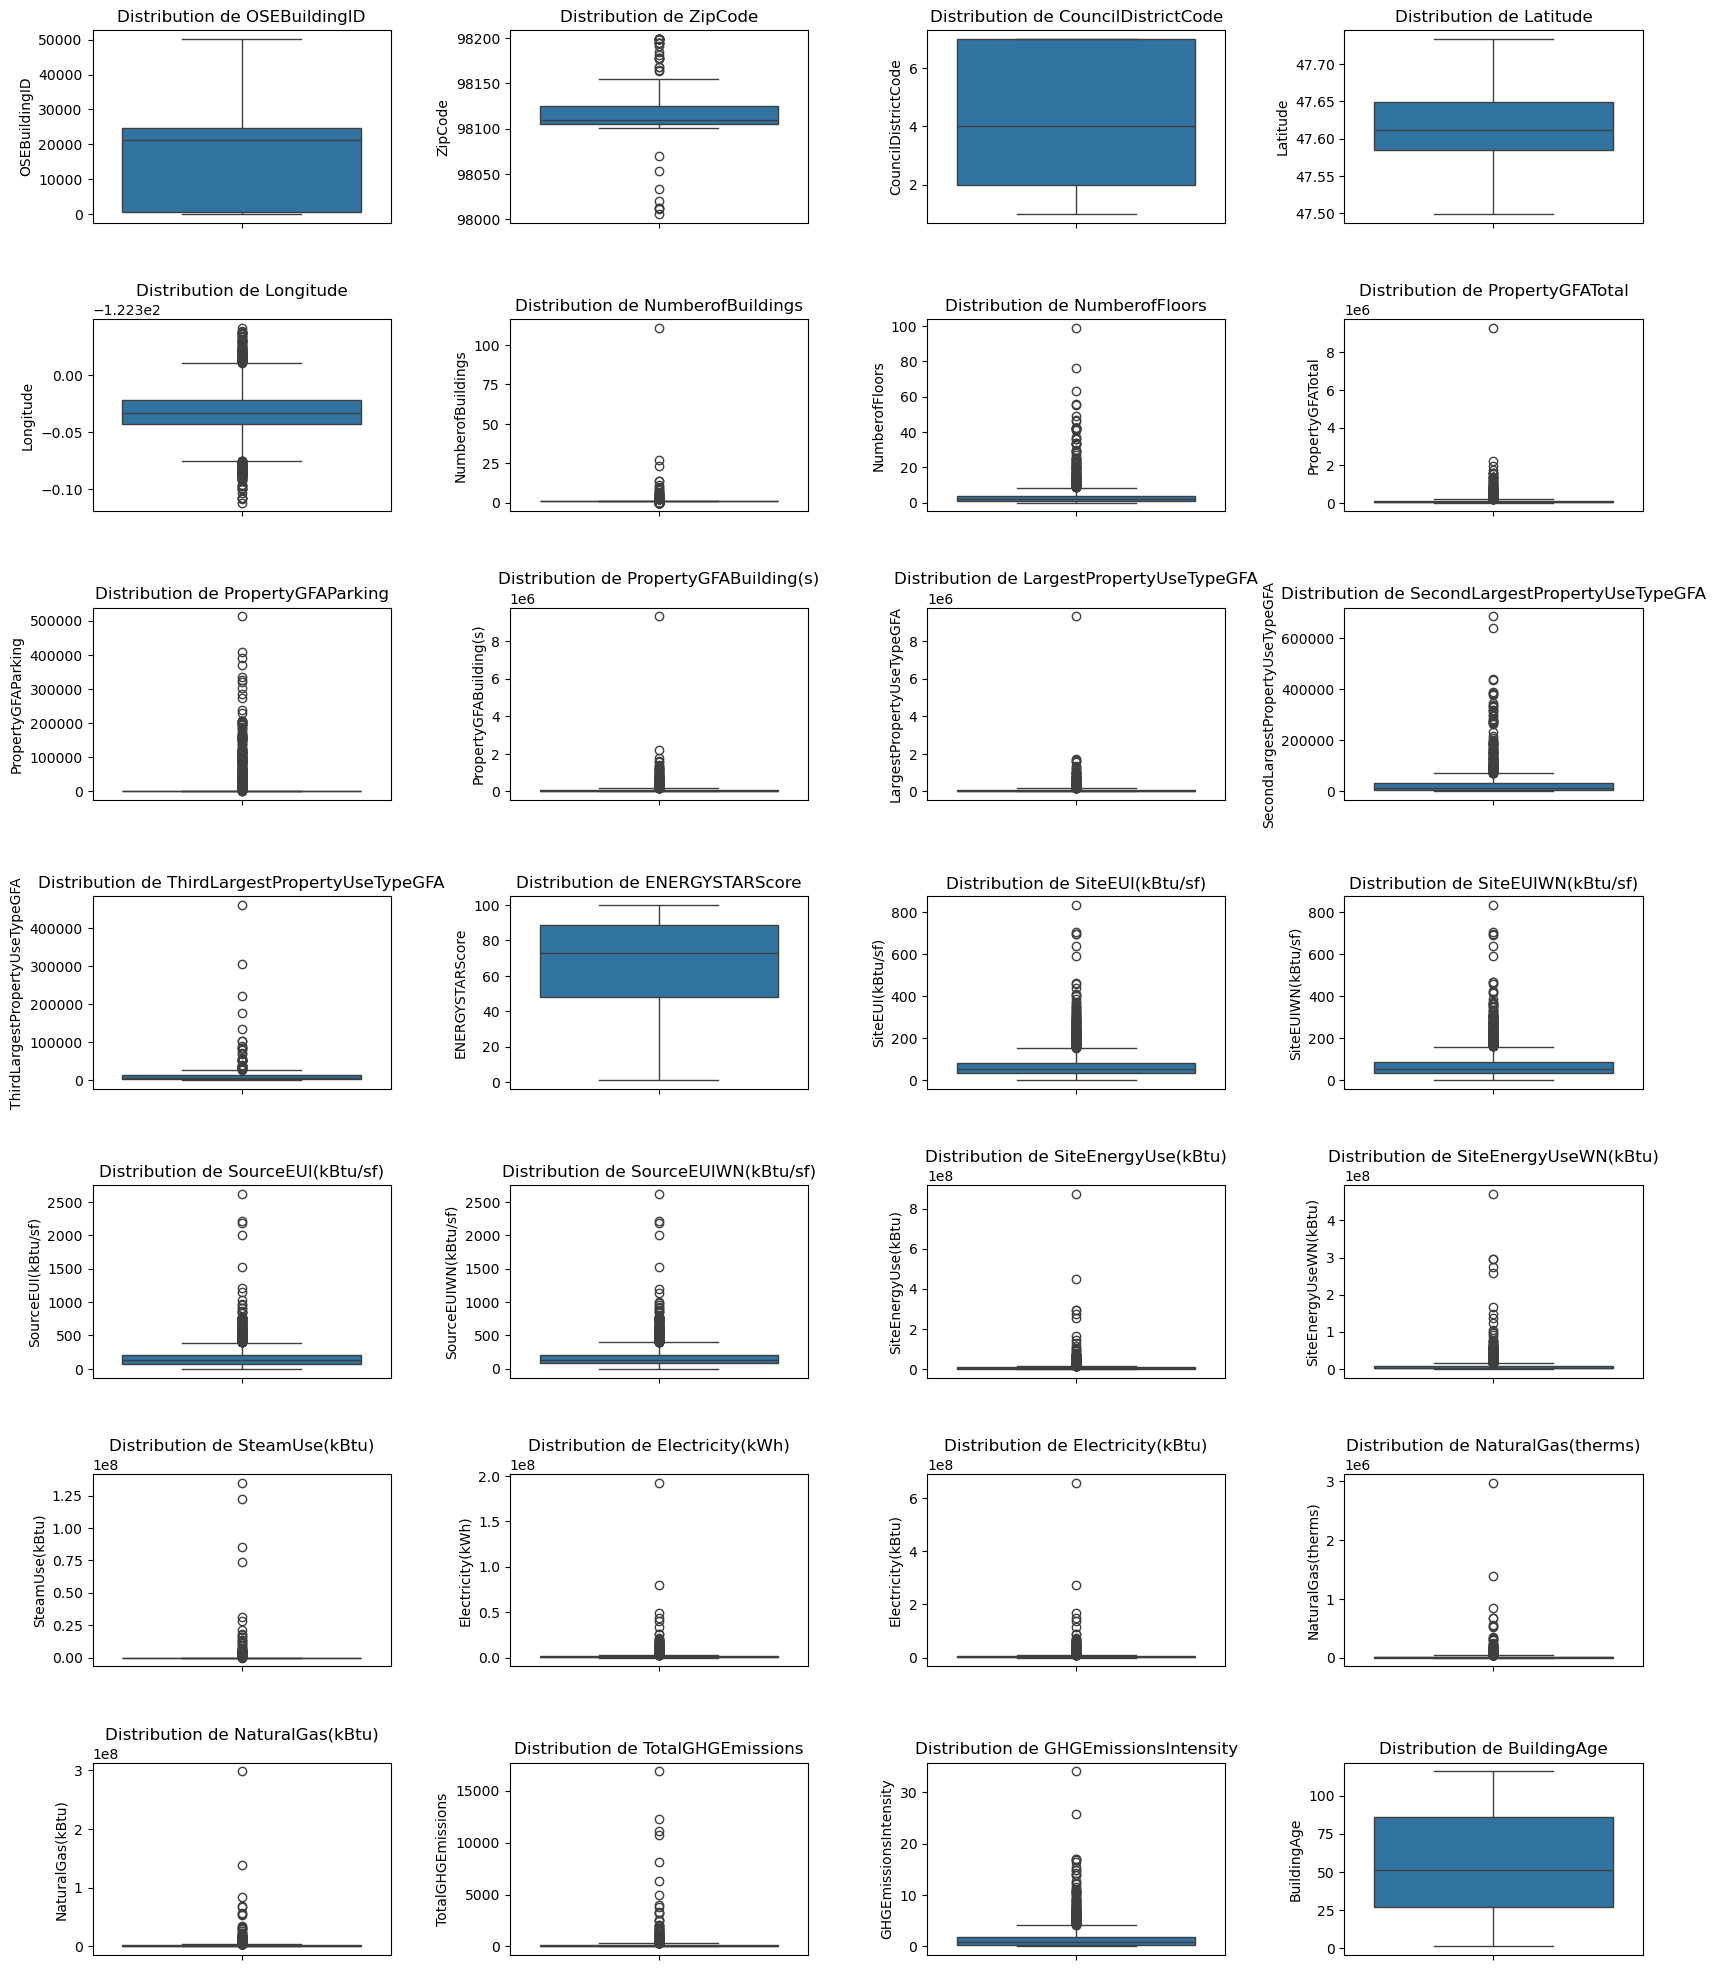

In [40]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df_filtered.select_dtypes(include=['number']).columns
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20,25))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df_filtered[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 28):
    fig.delaxes(axes.flatten()[j])

plt.show()

### Vérification des ZipCode

In [41]:
# Vérification des ZipCode
print("Valeurs uniques pour ZipCode dans data:", data['ZipCode'].unique())

Valeurs uniques pour ZipCode dans data: [98101. 98121. 98104. 98154. 98118. 98105. 98112. 98125. 98109. 98070.
 98108. 98199. 98115. 98107. 98144. 98103. 98119. 98136. 98122. 98126.
 98133. 98146. 98033. 98106. 98111. 98134. 98117. 98116. 98191. 98164.
 98195. 98185. 98181. 98102. 98168. 98155. 98006. 98124. 98053. 98012.
 98013. 98028. 98178. 98114. 98127. 98165. 98011. 98198. 98113. 98040.
 98204. 98177. 98020. 98272. 98145.    nan]


In [42]:
# Colonnes à afficher
cols_to_display = ['Address', 'ZipCode', 'Neighborhood', 'Latitude', 'Longitude']

# Filtrer les lignes où ZipCode est égal à 98145 puis afficher les colonnes spécifiées
filtered_df = df_filtered.loc[df_filtered['ZipCode'].isin([98145]), cols_to_display]

print(filtered_df)


               Address  ZipCode Neighborhood  Latitude  Longitude
3187  4500 40th Ave NE  98145.0    NORTHEAST  47.66201 -122.28386


D'après GoogleMaps, les coordonnées  47.66201, -122.28386 correspondent à cette adresse : 4800 40th Ave NE, Seattle, WA 98105, États-Unis => ZipCode à corriger

In [43]:
df_filtered.loc[df_filtered['Address'] == '4500 40th Ave NE', 'ZipCode'] = 98105

Les autres ZipCode correspondent bien à la métropole de Seattle.

In [44]:
def find_outliers_by_group(df, groupby_var, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df.groupby(groupby_var)[outlier_var].quantile(0.25)
    q3 = df.groupby(groupby_var)[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Initialiser une liste pour stocker les DataFrame des outliers
    outliers_list = []

    # Identifier les outliers pour chaque groupe
    for group in df[groupby_var].dropna().unique():
        lower_bound_group = lower_bound.get(group, np.nan)
        upper_bound_group = upper_bound.get(group, np.nan)
        # Utiliser les valeurs obtenues pour filtrer les outliers, en vérifiant aussi que les bornes ne sont pas NaN
        if not np.isnan(lower_bound_group) and not np.isnan(upper_bound_group):
            outliers_group = df[(df[groupby_var] == group) & 
                                ((df[outlier_var] < lower_bound_group) | 
                                 (df[outlier_var] > upper_bound_group))]
            if not outliers_group.empty:
                outliers_list.append(outliers_group)

    # Concaténer les DataFrame des outliers, en vérifiant d'abord si la liste n'est pas vide
    if outliers_list:
        outliers = pd.concat(outliers_list, ignore_index=True)
        return outliers
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide si aucun outlier n'est trouvé



### Vérification de la longitude

Seattle :

    Longitude minimale : aux alentours de -122.436 (ouest)
    Longitude maximale : aux alentours de -122.255 (est)

In [45]:
# Définir les limites de longitude pour Seattle
longitude_min = -122.436
longitude_max = -122.255

# Sélectionner les lignes en dehors de cette fourchette de longitude
outliers_longitude = df_filtered[(df_filtered['Longitude'] < longitude_min) | (df_filtered['Longitude'] > longitude_max)]

# Afficher les valeurs aberrantes
outliers_longitude[['Address', 'ZipCode', 'Neighborhood', 'Latitude', 'Longitude', 'CouncilDistrictCode']]

Empty DataFrame
Columns: [Address, ZipCode, Neighborhood, Latitude, Longitude, CouncilDistrictCode]
Index: []

Les valeurs sont donc atypiques mais pas abérrantes géographiquement parlant.

### Vérification des NumberofBuildings

In [46]:
# Compter et trier le nombre de valeurs
NumberofBuildings_counts = df_filtered['NumberofBuildings'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofBuildings': NumberofBuildings_counts})

NumberofBuildings
NumberofBuildings                   
111.0                              1
27.0                               1
23.0                               1
14.0                               2
11.0                               1
10.0                               1
9.0                                1
8.0                                2
7.0                                1
6.0                                4
5.0                                7
4.0                                4
3.0                               12
2.0                               14
1.0                             1525
0.0                               50

Il y a forcément au moins 1 bâtiment par adresse, la valeur la plus fréquente étant 1 on remplace les 0 par 1

In [47]:
df_filtered.loc[df_filtered['NumberofBuildings'] == 0.] = 1.

Les adresses avec plus de 7 bâtiments sont à vérifier.

In [48]:
# Sélectionner les lignes où le nombre de bâtiments est supérieur à 10
buildings_over_10 = df_filtered[df_filtered['NumberofBuildings'] > 10]
buildings_over_10[['Address', 'ZipCode', 'NumberofBuildings', 'PrimaryPropertyType']]

Address  ZipCode  NumberofBuildings  \
105             6000 16th Ave SW  98106.0               27.0   
128           9600 COLLEGE WAY N  98103.0               11.0   
162               1420 S Trenton  98108.0               14.0   
1862  1900 West Nickerson Street  98119.0               23.0   
2325             3307 3rd Ave. W  98119.0               14.0   
3274   NE 45th St & Brooklyn Ave  98105.0              111.0   

     PrimaryPropertyType  
105           University  
128           University  
162         Large Office  
1862               Other  
2325          University  
3274          University

Nombre de batiments pas abérrants sauf pour l'université avec 111 bâtiments. Il n'y a pas d'université à l'adresse indiqué et quant bien même cette valeur serait trop atypique et poserait problème pour nos modèles.

In [49]:
df_filtered = df_filtered.loc[df_filtered['NumberofBuildings'] != 111.]

### Vérification des NumberofFloors

In [50]:
# Compter et trier le nombre de valeurs
NumberofFloors_counts = df_filtered['NumberofFloors'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofFloors': NumberofFloors_counts})

NumberofFloors
NumberofFloors                
99                           1
76                           1
63                           1
56                           1
55                           1
49                           1
47                           1
46                           1
42                           5
41                           2
37                           1
36                           2
34                           2
33                           3
30                           1
29                           3
28                           1
27                           1
25                           3
24                           2
23                           3
22                           3
21                           3
20                           3
19                           4
18                           3
17                           4
16                           3
15                           5
14                           9
13                           7
12                           9
11                          18
10                          16
9                            7
8                           21
7                           33
6                           81
5                           96
4                          135
3                          240
2                          378
1                          503
0                           10

In [51]:
# Colonnes à afficher
cols_to_display = ['Address', 'ZipCode','NumberofFloors', 'PrimaryPropertyType']
print(df_filtered[cols_to_display].loc[df_filtered['NumberofFloors'] >60])

                       Address  ZipCode  NumberofFloors PrimaryPropertyType
233           700 Fifth Avenue  98104.0              63        Large Office
559             701 5th Avenue  98104.0              76        Large Office
1359  5801 Beacon Avenue South  98108.0              99    Worship Facility


A corriger :

    5801 Beacon Avenue South correspond à une église => remplacer par 1

In [52]:
df_filtered.loc[df_filtered['Address'] == '5801 Beacon Avenue South', 'NumberofFloors'] = 1

In [53]:
outliers = find_outliers_by_group(df_filtered, 'PrimaryPropertyType', 'NumberofFloors', 3)
if not outliers.empty:
    display(outliers[['Address', 'ZipCode', 'NumberofFloors', 'PrimaryPropertyType']])
else:
    print("Aucun outlier trouvé.")

Address  ZipCode  NumberofFloors  \
0                     1900 5th Avenue  98101.0              41   
1                        1113 6th Ave  98101.0              33   
2                     1400 6th Avenue  98101.0              34   
3                  1000 Fourth Avenue  98154.0              11   
4                         516 3RD AVE  98104.0              10   
5                         500 5TH AVE  98104.0              19   
6                       1900 9th Ave.  98101.0              11   
7                        1122 3rd Ave  98101.0              15   
8                          120 Lenora  98121.0              12   
9                        2001 6th Ave  98121.0              33   
10             1200 12th Avenue South  98144.0              14   
11  2201 9th Ave. / 820 Blanchard St.  98121.0              19   
12                    1000 Lenora St.  98121.0               7   
13                     625 5th Ave. S  98104.0              11   
14                   2203 1st Ave. S.  98134.0               7   
15                   700 Fifth Avenue  98104.0              63   
16                       1201 3rd ave  98101.0              55   
17                      601 Union St.  98101.0              56   
18                     701 5th Avenue  98104.0              76   
19                    500 Pine Street  98101.0              10   
20                    300 PINE STREET  98181.0               8   
21                 619 Western Avenue  98104.0               6   
22                     3613 4th Ave S  98134.0               2   
23            7272 W. Marginal Way S.  98108.0               2   
24                   270 S HANFORD ST  98134.0               2   
25                     1000 1st Ave S  98134.0               6   
26                     1014 1st Ave S  98134.0               4   
27                     2700 4th Ave S  98134.0               2   
28             5615 W Marginal Way SW  98106.0               2   
29       1200-1210 West Nickerson st.  98119.0               2   
30                  1529 Fourth Ave W  98119.0               3   
31                   901 Boren Avenue  98104.0              19   
32                      509 Olive Way  98101.0              18   
33             13000 Lake City Way NE  98125.0               2   
34               1401 Broadway Avenue  98122.0               3   
35             4545 Fauntleroy Way SW  98126.0               2   
36                  509-23 BROADWAY E  98122.0               2   
37                  500 Mercer Street  98109.0               4   
38                      516 1st Ave W  98119.0               4   
39                   5700 24th Ave NW  98107.0               8   
40                     4715 6th Ave S  98108.0               2   
41              2250 occidental ave s  98134.0               2   
42                    1411 1st Avenue  98101.0              13   

            PrimaryPropertyType  
0                         Hotel  
1                         Hotel  
2                         Hotel  
3                         Other  
4                         Other  
5                         Other  
6                         Other  
7                         Other  
8                         Other  
9                         Other  
10           Mixed Use Property  
11           Mixed Use Property  
12                   University  
13  Small- and Mid-Sized Office  
14                    Warehouse  
15                 Large Office  
16                 Large Office  
17                 Large Office  
18                 Large Office  
19                 Retail Store  
20                 Retail Store  
21                 Retail Store  
22          Distribution Center  
23          Distribution Center  
24          Distribution Center  
25          Distribution Center  
26          Distribution Center  
27          Distribution Center  
28          Distribution Center  
29          Distribution Center  
30          Distribution Center  
31               Medical Office  
32 

Un restaurant avec 13 étage et après vérification sur la carte, cela semble être une erreur de saisie.
Mise à 0 temporaire pour lui appliquer la moyenne.<br>
Après vérification, les autres bâtiments ne sont pas des outliers.

In [54]:
df_filtered.loc[df_filtered['Address'] == '1411 1st Avenue', 'NumberofFloors'] = 0

Aux USA on compte le rez de chaussée comme un étage. Il y a donc necessairement au moins 1 étage par batiment.
Nous allons donc remplacer les valeurs à 0 par la moyenne en fonction de leur PrimaryPropertyType.

In [55]:
# Calculer la médiane du nombre d'étages pour chaque type de propriété et convertir en entiers
mean_floors_by_type = df_filtered[df_filtered['NumberofFloors'] > 0].groupby('PrimaryPropertyType')['NumberofFloors'].median().astype(int)


# Fonction pour remplacer les zéros par la moyenne correspondante
def replace_zero_with_mean(row):
    if row['NumberofFloors'] == 0:
        return mean_floors_by_type.get(row['PrimaryPropertyType'], 0)
    else:
        return row['NumberofFloors']


In [56]:
# Appliquer la fonction à la colonne 'NumberofFloors'
df_filtered['NumberofFloors'] = df_filtered.apply(replace_zero_with_mean, axis=1)

### Vérification des PropertyGFA

Le PropertyGFATotal ne peut pas par définition être plus petit que la somme des GFA des 3 principales utilisations. Ce sont donc des erreurs qu'il faut supprimer.

In [57]:
def check_total_vs_sum(row):
    # Vérifier si PropertyGFATotal est NaN et exclure de la vérification
    if pd.isna(row['PropertyGFATotal']):
        return False

    # Remplacer les NaN par 0 pour ce calcul uniquement
    largest_gfa = row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0
    second_largest_gfa = row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0
    third_largest_gfa = row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0

    # Calculer la somme des trois plus grandes utilisations de la propriété
    total_gfa = largest_gfa + second_largest_gfa + third_largest_gfa

    # Vérifier si PropertyGFATotal est inférieur ou égale à cette somme (marge de 15%)'
    return row['PropertyGFATotal'] < (total_gfa * 0.85)

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_total_vs_sum, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)



Nombre de lignes considérées comme outliers : 177


In [58]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal PrimaryPropertyType  LargestPropertyUseTypeGFA  \
3134            140823  Mixed Use Property                    89820.0   
2138             27760               Other                    19715.0   
365                  1                 1.0                        1.0   
608                  1                 1.0                        1.0   
36              714095           Warehouse                   616000.0   
429                  1                 1.0                        1.0   
1025                 1                 1.0                        1.0   
3105             42000          Restaurant                    26554.0   
260             298426        Large Office                   286538.0   
2141             29394           Warehouse                    29394.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
3134    Supermarket/Grocery Store                          64000.0   
2138                       Office                          12000.0   
365                           1.0                              1.0   
608                           1.0                              1.0   
36         Refrigerated Warehouse                         276000.0   
429                           1.0                              1.0   
1025                          1.0                              1.0   
3105                        Other                          15310.0   
260                       Parking                         197750.0   
2141                       Office                          16902.0   

      ThirdLargestPropertyUseTypeGFA  
3134                         41014.0  
2138                          6000.0  
365                              1.0  
608                              1.0  
36                           71000.0  
429                              1.0  
1025                             1.0  
3105                          7673.0  
260                          11888.0  
2141                             NaN

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [59]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

In [60]:
df_filtered.shape

(1451, 37)

GFABuilding + GFAPArking est sensé être égale à GFATotal

In [61]:
def check_GFATotal_vs_GFABuilding_and_Parking(row):
    # Vérifier si PropertyGFATotal, PropertyGFABuilding(s) ou PropertyGFAParking est NaN et exclure de la vérification
    if pd.isna(row['PropertyGFATotal']) or pd.isna(row['PropertyGFABuilding(s)']) or pd.isna(row['PropertyGFAParking']):
        return False

    # Calculer la somme de PropertyGFABuilding(s) et PropertyGFAParking
    total_gfa_calculated = row['PropertyGFABuilding(s)'] + row['PropertyGFAParking']

    # Calculer les marges de 20% pour plus ou moins
    lower_bound = total_gfa_calculated * 0.80
    upper_bound = total_gfa_calculated * 1.20

    # Vérifier si PropertyGFATotal est dans la marge de tolérance
    return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_GFATotal_vs_GFABuilding_and_Parking, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 0


In [62]:
# Mettre à jour LargestPropertyUseType en PrimaryPropertyType si Other ou nan
count = ((df_filtered['LargestPropertyUseType'].isin(["Other", pd.NA])) & pd.notna(df_filtered['PrimaryPropertyType'])).sum()
df_filtered.loc[(df_filtered['LargestPropertyUseType'].isin(["Other", pd.NA])) & pd.notna(df_filtered['PrimaryPropertyType']), 'LargestPropertyUseType'] = df_filtered['PrimaryPropertyType']

print("Nombre de données modifiées :", count)


Nombre de données modifiées : 85


Cas des Parking, certains useType sont appelés Parking et peuvent donc fausser les résulats.<br>
Mais commencons par renommer les "other" qui correspondent à des Parking.

In [63]:
# Calculer la plage de tolérance de 10% pour PropertyGFAParking
tolerance = df_filtered['PropertyGFAParking'] * 0.10

# Mettre à jour PrimaryPropertyType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['LargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'LargestPropertyUseType'] = "Parking"

# Mettre à jour SecondLargestPropertyUseType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['SecondLargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'SecondLargestPropertyUseType'] = "Parking"

# Mettre à jour ThirdLargestPropertyUseType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['ThirdLargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'ThirdLargestPropertyUseType'] = "Parking"


On vérifie que PropertyGFAParking = PropertyUseTypeGFA si PropertyUseType = Parking (5% de marge)

In [64]:
def check_parking_gfa_compliance(row):
    # Vérifier si PropertyGFATotal est NaN et exclure de la vérification
    if (row['PropertyGFAParking'] == 0):
        return False
    
    parking_gfa = row['PropertyGFAParking']
    is_inconsistent = False  # Initialiser 

    # Calculer les marges pour chaque type de propriété et vérifier les conditions avec la marge de 5%
    for property_type in ['Largest', 'SecondLargest', 'ThirdLargest']:
        property_use_type = row.get(f'{property_type}PropertyUseType', None)
        property_type_gfa = row.get(f'{property_type}PropertyUseTypeGFA', 0)
        
        if property_use_type == "Parking":
            # Calculer la différence en valeur absolue et la marge de 5%
            diff = abs(parking_gfa - property_type_gfa)
            margin = 0.05 * property_type_gfa
            
            # Vérifier si la différence dépasse la marge de 5%
            if diff > margin:
                is_inconsistent = True  # Marquer comme incohérent si la condition est remplie

    return is_inconsistent

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_parking_gfa_compliance, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 126


In [65]:
#### Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal  PropertyGFAParking LargestPropertyUseType  \
3235            333714              146687                 Office   
294             456304               93204                 Office   
235             199530               30660                 Office   
421             154029               62380                 Office   
1105            206126               79284                 Office   
371             280957              114829                 Office   
77              920598              303707                 Office   
2671             34948               15755            Bank Branch   
546             202623               88855                 Office   
251             287471               83591                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3235                   191333.0                      Parking   
294                    342952.0                      Parking   
235                    160418.0                      Parking   
421                     91645.0                      Parking   
1105                   101941.0                      Parking   
371                    152579.0                      Parking   
77                     729584.0                      Parking   
2671                    19183.0                      Parking   
546                    105206.0                      Parking   
251                    191814.0                      Parking   

      SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  
3235                         133432.0                             NaN  
294                          106466.0                             NaN  
235                           18590.0                         17480.0  
421                           66288.0                             NaN  
1105                          73177.0                          8324.0  
371                           93893.0                          7500.0  
77                           185014.0                          6000.0  
2671                          19183.0                             NaN  
546                           31992.0                          6374.0  
251                           72178.0                          5322.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [66]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

On vérifie si PropertyGFATotal est bien égale à la somme de tous les GFA parking compris avec une marge de 20%.

In [67]:
def check_property_gfa(row):
    # Pas d'évaluation si PropertyGFATotal est nan
    if pd.isna(row['PropertyGFATotal']):
        return False
    
    # Initialiser total_gfa_sum avec PropertyGFAParking si ce n'est pas nan
    total_gfa_sum = row['PropertyGFAParking'] if pd.notna(row['PropertyGFAParking']) else 0
    
    # Ajouter LargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if (row['LargestPropertyUseType'] != "Parking" and pd.notna(row['LargestPropertyUseTypeGFA'])) or \
    (row['LargestPropertyUseType'] == "Parking" and (pd.isna(row['PropertyGFAParking']) or row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['LargestPropertyUseTypeGFA']
    
    # Ajouter SecondLargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if (row['SecondLargestPropertyUseType'] != "Parking" and pd.notna(row['SecondLargestPropertyUseType'])) or \
    (row['SecondLargestPropertyUseType'] == "Parking" and (pd.isna(row['PropertyGFAParking']) or row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['SecondLargestPropertyUseTypeGFA']
    
    # Ajouter ThirdLargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if (row['ThirdLargestPropertyUseType'] != "Parking" and pd.notna(row['ThirdLargestPropertyUseType'])) or \
    (row['ThirdLargestPropertyUseType'] == "Parking" and (pd.isna(row['PropertyGFAParking']) or row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['ThirdLargestPropertyUseTypeGFA']

    # Calculer les marges de 15% pour plus ou moins
    lower_bound = total_gfa_sum * 0.85
    upper_bound = total_gfa_sum * 1.15
    
    # Vérifier si ThirdLargestPropertyUseType est NaN
    if pd.notna(row['ThirdLargestPropertyUseType']):
        # Si oui, vérifier seulement si PropertyGFATotal est inférieur au lower_bound
        return row['PropertyGFATotal'] < lower_bound
    else:
        # Sinon, vérifier si PropertyGFATotal est dans la marge de tolérance
        return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)


# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_property_gfa, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 105


In [68]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal  PropertyGFAParking     LargestPropertyUseType  \
432              53040               41600                      Other   
874              61180               12960                      Hotel   
2459             28800                   0                        NaN   
46               59400                   0                     Office   
3233            305025              239252           Lifestyle Center   
3020             27908                   0                      Other   
71              396085                   0                      Other   
1175             26419                6922                     Office   
2019             25460                   0                      Other   
402              58480                   0  Supermarket/Grocery Store   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
432                     51427.0                          NaN   
874                     61180.0                          NaN   
2459                        NaN                          NaN   
46                      34947.0                 Retail Store   
3233                   318986.0               Medical Office   
3020                    21886.0                          NaN   
71                     278500.0                          NaN   
1175                    26419.0                          NaN   
2019                     8223.0                          NaN   
402                     44431.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
432                               NaN                         NaN   
874                               NaN                         NaN   
2459                              NaN                         NaN   
46                             4993.0                         NaN   
3233                          19909.0                         NaN   
3020                              NaN                         NaN   
71                                NaN                         NaN   
1175                              NaN                         NaN   
2019                              NaN                         NaN   
402                               NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA  
432                              NaN  
874                              NaN  
2459                             NaN  
46                               NaN  
3233                             NaN  
3020                             NaN  
71                               NaN  
1175                             NaN  
2019                             NaN  
402                              NaN

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [69]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

In [70]:
df_filtered.shape

(1220, 37)

Le LargestPropertyUseTypeGFA doit etre > que le SecondLargest > ThirdLargest, sinon ce sont donc des erreurs qu'il faut supprimer.

In [71]:
def check_property_use_gfa_hierarchy(row):
    # Remplacer les valeurs manquantes par 0 pour cette vérification seulement
    largest_gfa = row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0
    second_largest_gfa = row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0
    third_largest_gfa = row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0
    
    # Vérifier la hiérarchie des valeurs GFA
    return largest_gfa < second_largest_gfa or second_largest_gfa < third_largest_gfa

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_property_use_gfa_hierarchy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 0


### Vérification de l'Energy

Vérification de la cohérance avec les unités pour l'electricité

In [72]:
def check_electricity_coherence(row):
    # Pas d'évaluation si Electricity est nan
    if pd.isna(row['Electricity(kWh)']) or pd.isna(row['Electricity(kBtu)']):
        return False

    # Conversion: 1 kWh = 3.41214 kBtu
    electricity_kwh_to_btu = row['Electricity(kWh)'] * 3.41214

    # Calculer la marge de tolérance
    lower_bound = electricity_kwh_to_btu * 0.95
    upper_bound = electricity_kwh_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['Electricity(kBtu)'] <= upper_bound)
    

In [73]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_electricity_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 2


In [74]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

Vérification de la cohérance avec les unités pour le gaz

In [75]:
def check_natural_gas_coherence(row):
    # Pas d'évaluation si NaturalGas est nan
    if (pd.isna(row['NaturalGas(therms)']) or pd.isna(row['NaturalGas(kBtu)'])):
        return False
        
    # Conversion: 100 kBtu  = 1 therm
    natural_gas_therms_to_btu = row['NaturalGas(therms)'] * 100
    
    # Calculer la marge de tolérance
    lower_bound = natural_gas_therms_to_btu * 0.95
    upper_bound = natural_gas_therms_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['NaturalGas(kBtu)'] <= upper_bound)


In [76]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_natural_gas_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


Vérification de la cohérance pour SiteEnergyUseWN(kBtu) et SiteEnergyUse(kBtu)

In [77]:
def check_SiteEnergyUse_coherence(row):
    # Pas d'évaluation si SiteEnergyUse est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEnergyUse(kBtu)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEnergyUse(kBtu)'] * 0.8
    upper_bound = row['SiteEnergyUse(kBtu)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)

In [78]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEnergyUse_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 6


In [79]:
outliers[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']]

SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)
220          2.490613e+07                    0.0
247          2.682322e+07                    0.0
882          4.964773e+05                    0.0
953          1.128179e+06                    0.0
3275         5.000717e+06                    0.0
3277         5.116831e+07                    0.0

In [80]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SiteEnergyUseWN(kBtu)'] == 0, 'SiteEnergyUseWN(kBtu)'] = df_filtered['SiteEnergyUse(kBtu)']

Vérification de la cohérance pour SiteEUIWN(kBtu) et SiteEUI(kBtu)

In [81]:
def check_SiteEUI_coherence(row):
    # Pas d'évaluation si SiteEUI est nan
    if (pd.isna(row['SiteEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUI(kBtu/sf)'] * 0.8
    upper_bound = row['SiteEUI(kBtu/sf)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEUIWN(kBtu/sf)'] <= upper_bound)

In [82]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEUI_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 6


In [83]:
outliers[['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)']]

SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)
220         105.199997                 0.0
247          73.000000                 0.0
882          20.700001                 0.0
953          37.599998                 0.0
3275         85.099998                 0.0
3277        252.000000                 0.0

In [84]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SiteEUIWN(kBtu/sf)'] == 0, 'SiteEUIWN(kBtu/sf)'] = df_filtered['SiteEUI(kBtu/sf)']

Vérification de la cohérance pour SourceEUIWN(kBtu) et SourceEUI(kBtu)

In [85]:
def check_SourceEUI_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SourceEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SourceEUI(kBtu/sf)'] * 0.8
    upper_bound = row['SourceEUI(kBtu/sf)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SourceEUIWN(kBtu/sf)'] <= upper_bound)

In [86]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SourceEUI_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 6


In [87]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SourceEUIWN(kBtu/sf)'] == 0, 'SourceEUIWN(kBtu/sf)'] = df_filtered['SourceEUI(kBtu/sf)']

Vérification de la cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

In [88]:
def check_Source_Site_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    upper_bound = row['SourceEUI(kBtu/sf)'] * 1.1

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(row['SiteEUI(kBtu/sf)'] <= upper_bound)

In [89]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_Source_Site_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 3


Vérification de la cohérance pour SiteEUIWN(kBtu/sf) et SiteEnergyUseWN(kBtu)

In [90]:
def check_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEUIWN(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUIWN(kBtu/sf)'] * 0.8 * row['PropertyGFATotal']
    upper_bound = row['SiteEUIWN(kBtu/sf)'] * 1.2 * row['PropertyGFATotal']

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)


In [91]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEUI_SiteEnergyUse, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 135


In [92]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
# Créer une nouvelle colonne pour le calcul
sample_outliers['Calculated_SiteEnergyUseWN(kBtu)'] = sample_outliers['SiteEUIWN(kBtu/sf)'] * sample_outliers['PropertyGFATotal']

# Sélectionner les colonnes d'intérêt pour l'affichage
calculated_vs_actual = sample_outliers[['Calculated_SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)']]

calculated_vs_actual


Calculated_SiteEnergyUseWN(kBtu)  SiteEnergyUseWN(kBtu)
442                       3.110461e+07           1.941974e+07
351                       3.580832e+07           1.971834e+07
732                       6.955312e+06           4.673728e+06
147                       1.723545e+07           1.175409e+07
1328                      1.545108e+07           9.512996e+06
785                       3.314354e+06           2.249630e+06
29                        6.498950e+06           4.557974e+06
326                       9.115808e+06           4.899096e+06
335                       5.195218e+06           3.238216e+06
806                       2.592962e+06           1.523175e+06

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [93]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

Vérification de la somme pour arriver à SiteEnergyUse(kBtu)

In [94]:
def check_sum_energy(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan ou 0
    if pd.isna(row['SiteEnergyUse(kBtu)']) | (row['SiteEnergyUse(kBtu)'] == 0):
        return False
    
    # Calculer la somme avec les valeurs manquantes remplacées temporairement par 0
    total_nrj_sum = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
                    (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
                    (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    # Calculer la marge de tolérance
    lower_bound = total_nrj_sum * 0.8
    upper_bound = total_nrj_sum * 1.2

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUse(kBtu)'] <= upper_bound)


In [95]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_sum_energy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 6


In [96]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=6)
sample_outliers[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]


SiteEnergyUse(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)
513          1.252517e+07                0.0             0.0               0.0
3277         5.116831e+07         28614613.0             0.0               0.0
3275         5.000717e+06          3719217.0             0.0               0.0
2761         9.772303e+05            90201.0             0.0          114794.0
2791         4.729846e+06          1323792.0             0.0               0.0
601          3.795171e+07         18610055.0             0.0          685132.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [97]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

### Vérification de TotalGHGEmissions

In [98]:
def check_TotalGHGEmissions(row):
    # Pas d'évaluation si TotalGHGEmissions est nan
    if (pd.isna(row['TotalGHGEmissions']) or pd.isna(row['GHGEmissionsIntensity'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['GHGEmissionsIntensity'] * 0.8 * row['PropertyGFATotal'] / 1000 # /1000 pour la conversion d'unité
    upper_bound = row['GHGEmissionsIntensity'] * 1.2 * row['PropertyGFATotal'] / 1000

    # La condition vérifie si la valeur est hors de la marge de tolérance
    return not(lower_bound <= row['TotalGHGEmissions'] <= upper_bound)

In [99]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_TotalGHGEmissions, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 4


In [100]:
# Créer une nouvelle colonne pour le calcul
copy_outliers = outliers.copy()
copy_outliers['Calculated_GHG'] = copy_outliers['GHGEmissionsIntensity'] * copy_outliers['PropertyGFATotal'] / 1000

# Sélectionner les colonnes d'intérêt pour l'affichage
copy_outliers[['Calculated_GHG', 'GHGEmissionsIntensity', 'TotalGHGEmissions']]

Calculated_GHG  GHGEmissionsIntensity  TotalGHGEmissions
595          0.71718                   0.01               1.06
609          3.41264                   0.02               4.20
2189         0.00000                   0.00               0.12
3152         0.39212                   0.01               0.50

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [101]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

### Impact des CompliantStatus et Outlier

In [102]:
print(df_filtered['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       968
Error - Correct Default Data     84
Missing Data                     13
Non-Compliant                     8
Name: count, dtype: int64


ComplianceStatus :

    - Non-Compliant indique que le bâtiment n'a pas satisfait certaines exigences de reporting ou de performance, ce qui pourrait signifier que les données associées sont incomplètes ou peu fiables.
    - Les bâtiments avec des erreurs dans leur statut de conformité ("Error") peuvent également souffrir de problèmes de données qui compromettent leur utilité pour l'analyse et la modélisation.
    
Inclure ces bâtiments pourrait introduire un biais ou de l'incertitude dans vos analyses.
=> Suppression, On conserve les Compliant et Missing Data



In [103]:
df_filtered = df_filtered[~df_filtered['ComplianceStatus'].str.contains("Non-Compliant", na=False)].copy()
df_filtered = df_filtered[~df_filtered['ComplianceStatus'].str.contains("Error", na=False)].copy()

In [104]:
print(df_filtered['Outlier'].value_counts())

Series([], Name: count, dtype: int64)


Après ce nettoyage on constate qu'il n'y a plus d'Outliers.

## Traitement des valeurs manquantes

In [105]:
df_filtered.shape

(981, 37)

Maintenant que le tri des valeurs abérrantes a été fait, on peut supprimer les dernière colonnes qui ne nous servirons pas pour nos modèles.

In [106]:
cols_to_drop = ['Address', 'ComplianceStatus', 'Electricity(kWh)', 'NaturalGas(therms)', 
                'OSEBuildingID', 'Outlier', 'SiteEUI(kBtu/sf)', 'PropertyGFABuilding(s)', 'PrimaryPropertyType',
                'SiteEnergyUse(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']

df_selected = df_filtered.drop(columns=cols_to_drop).copy()

In [107]:
missing_values_count = df_selected.isnull().sum()
total_cells = np.product(df_selected.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.71 %


In [108]:
percent_missing_values =  round((missing_values_count / len(df_selected)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
BuildingType                                                0   
ZipCode                                                    13   
CouncilDistrictCode                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
NumberofBuildings                                           0   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
LargestPropertyUseType                                      0   
LargestPropertyUseTypeGFA                                   0   
SecondLargestPropertyUseType                              549   
SecondLargestPropertyUseTypeGFA                           549   
ThirdLargestPropertyUseType                               816   
ThirdLargestPropertyUseTypeGFA                            816   
ENERGYSTARScore                                           374   
SiteEUIWN(kBtu/sf)                                          0   
SiteEnergyUseWN(kBtu)                                       0   
SteamUse(kBtu)                                              0   
Electricity(kBtu)                                           0   
NaturalGas(kBtu)                                            0   
TotalGHGEmissions                                           0   
GHGEmissionsIntensity                                       0   
BuildingAge                                                 0   

                                 Pourcentage de valeurs manquantes  
BuildingType                                                  0.00  
ZipCode                                                       1.33  
CouncilDistrictCode                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude                                                     0.00  
NumberofBuildings                                             0.00  
NumberofFloors                                                0.00  
PropertyGFATotal                                              0.00  
PropertyGFAParking                                            0.00  
LargestPropertyUseType                                        0.00  
LargestPropertyUseTypeGFA                                     0.00  
SecondLargestPropertyUseType                                 55.96  
SecondLargestPropertyUseTypeGFA                              55.96  
ThirdLargestPropertyUseType                                  83.18  
ThirdLargestPropertyUseTypeGFA                               83.18  
ENERGYSTARScore                                              38.12  
SiteEUIWN(kBtu/sf)                                            0.00  
SiteEnergyUseWN(kBtu)                                         0.00  
SteamUse(kBtu)                                                0.00  
Electricity(kBtu)                                             0.00  
NaturalGas(kBtu)                                              0.00  
TotalGHGEmissions                                             0.00  
GHGEmissionsIntensity                                         0.00  
BuildingAge                                                   0.00

### Complétion à 0

In [109]:
# Créer une copie du DataFrame
df_completed = df_selected.copy()

In [110]:
# Fonction pour calculer la somme des GFA et comparer avec PropertyGFATotal
def adjust_gfa_values(row):
    # Calculer la somme des GFA, en remplaçant les NaN par 0
    gfa_sum = np.nansum([
        row.get('LargestPropertyUseTypeGFA', 0),
        row.get('SecondLargestPropertyUseTypeGFA', 0),
        row.get('ThirdLargestPropertyUseTypeGFA', 0),
        row.get('PropertyGFAParking', 0)
    ])
    
    # Calculer une marge de 5% pour PropertyGFATotal
    lower_bound = row['PropertyGFATotal'] * 0.95
    upper_bound = row['PropertyGFATotal'] * 1.05
    
    # Vérifier si la somme des GFA est dans la marge de 5% de PropertyGFATotal
    if lower_bound <= gfa_sum <= upper_bound:
        # Remplacer les NaN par 0 pour les colonnes spécifiées
        for col in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'PropertyGFAParking']:
            if pd.isna(row[col]):
                row[col] = 0
    return row


In [111]:
# Appliquer la fonction adjust_gfa_values à chaque ligne
df_completed = df_completed.apply(adjust_gfa_values, axis=1)

In [112]:
def adjust_property_use_type(row):
    if row['SecondLargestPropertyUseTypeGFA'] == 0 and pd.isna(row['SecondLargestPropertyUseType']):
        row['SecondLargestPropertyUseType'] = "None"
    if row['ThirdLargestPropertyUseTypeGFA'] == 0 and pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
    return row

# Appliquer la fonction pour ajuster les valeurs de PropertyUseType sur le DataFrame complet
df_completed = df_completed.apply(adjust_property_use_type, axis=1)


In [113]:
missing_values_count = df_completed.isnull().sum()
total_cells = np.product(df_completed.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 3.08 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

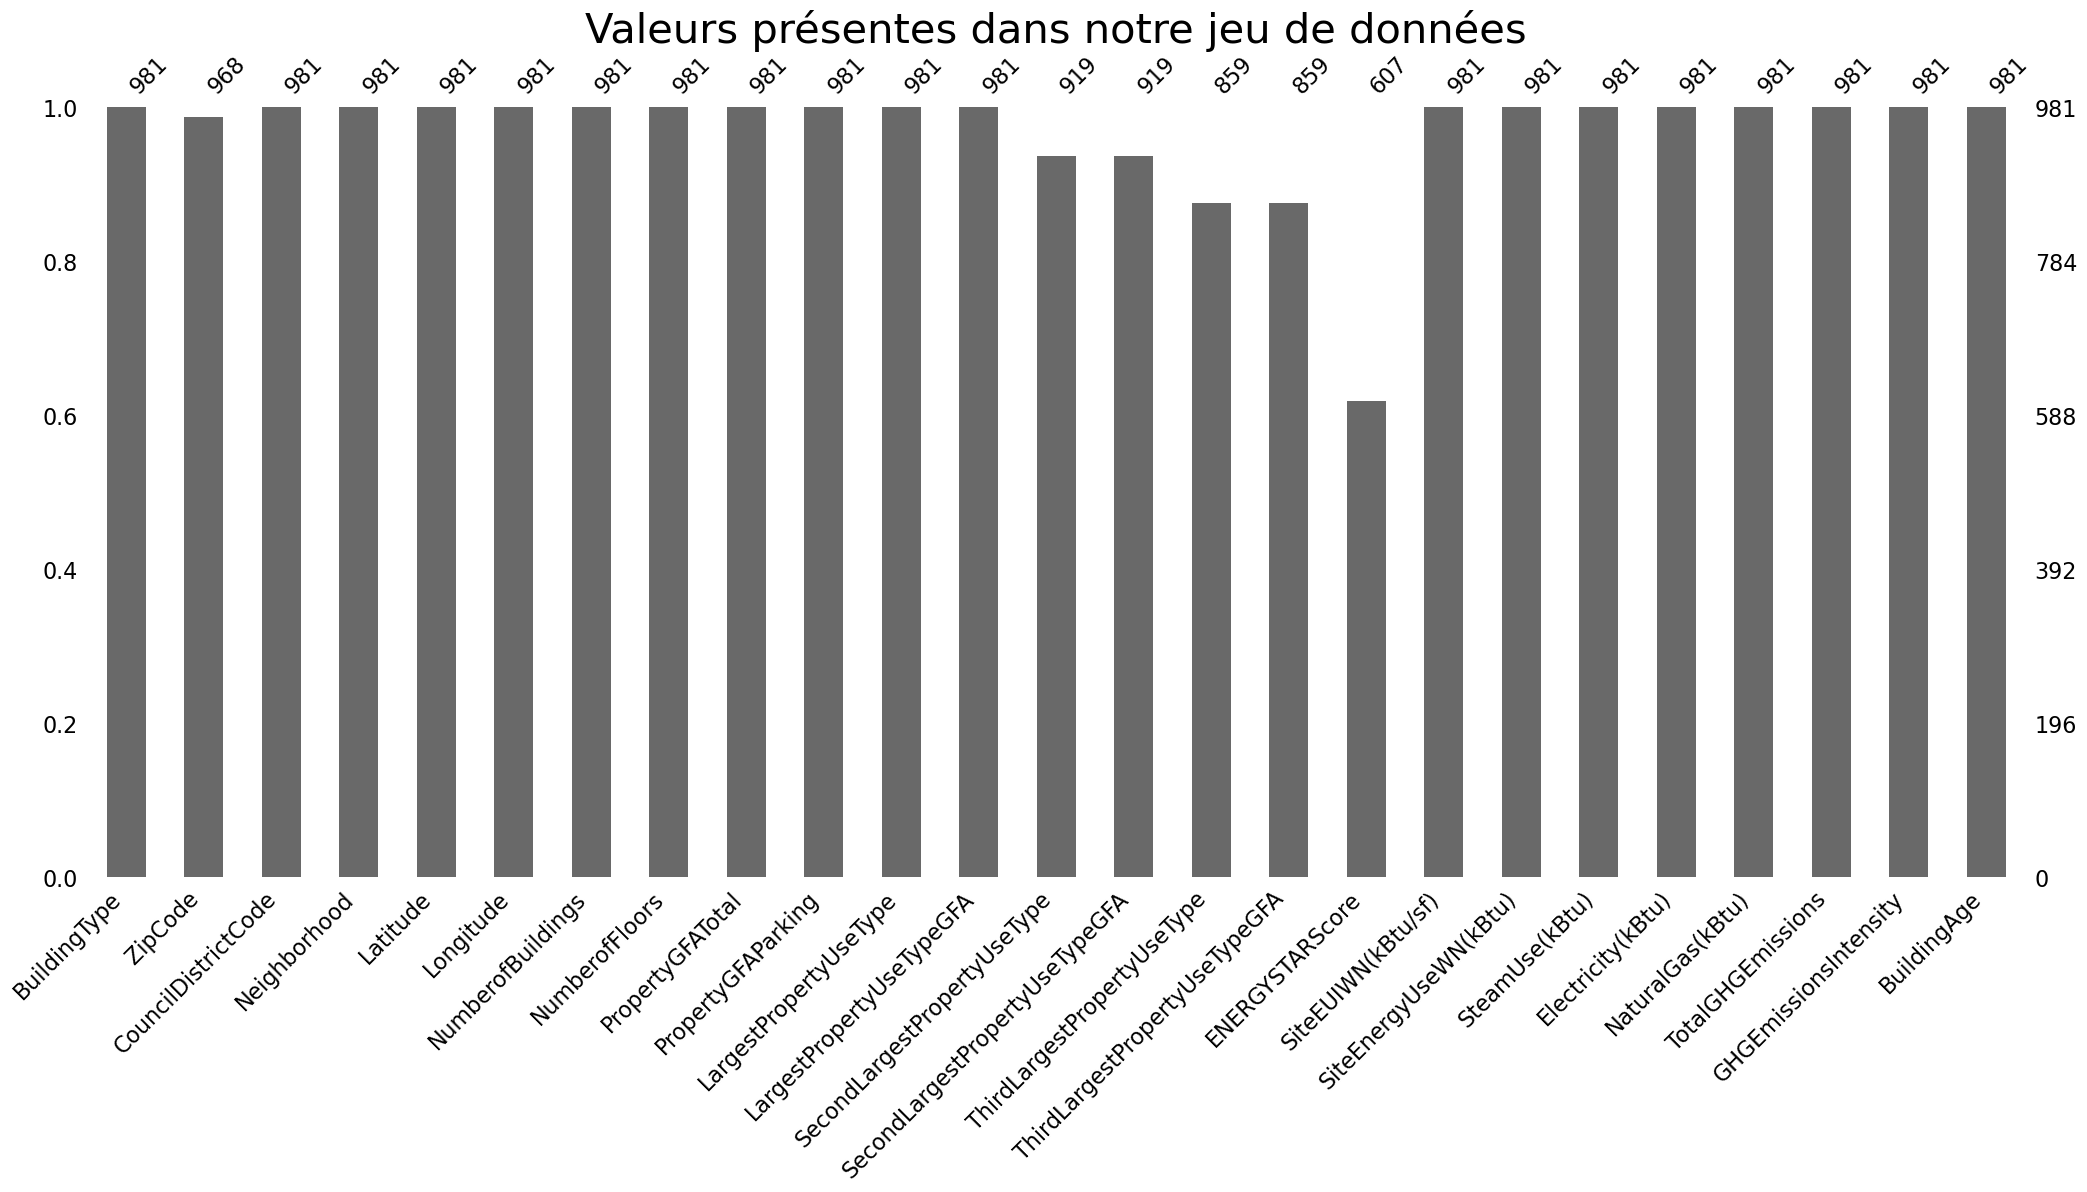

In [114]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_completed)

### Calcul

L'utilisation des propriétés est cruciale pour notre etude, nous allons tenter de compléter les valeurs manquantes

In [115]:
def fill_missing_types_and_calculate_gfa(row):
    largest_gfa = row['LargestPropertyUseTypeGFA']
    parking_gfa = row['PropertyGFAParking']
    
    # Pour SecondLargestPropertyUseType
    gfa_diff = row['PropertyGFATotal'] - largest_gfa - parking_gfa
    if pd.isna(row['SecondLargestPropertyUseType']) or gfa_diff == 0:
        row['SecondLargestPropertyUseType'] = "None"  
        row['SecondLargestPropertyUseTypeGFA'] = 0
    elif pd.isna(row['SecondLargestPropertyUseType']) and gfa_diff != 0:
        row['SecondLargestPropertyUseType'] = "Other" 
        row['SecondLargestPropertyUseTypeGFA'] = gfa_diff  

    # Assurer que ThirdLargestPropertyUseType est défini comme "None" si SecondLargestPropertyUseType est "None"
    if row['SecondLargestPropertyUseType'] == "None" or pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
        row['ThirdLargestPropertyUseTypeGFA'] = 0
    else:
        # Calcul pour ThirdLargestPropertyUseTypeGFA 
        second_largest_gfa = row['SecondLargestPropertyUseTypeGFA']
        third_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa
        if pd.isna(row['ThirdLargestPropertyUseType']) or third_gfa_diff == 0:
            row['ThirdLargestPropertyUseType'] = "None"  
            row['ThirdLargestPropertyUseTypeGFA'] = 0
        elif pd.isna(row['SecondLargestPropertyUseType']) and third_gfa_diff != 0:
            row['ThirdLargestPropertyUseType'] = "Other" 
            row['ThirdLargestPropertyUseTypeGFA'] = gfa_diff  

    return row

# Appliquer la fonction pour ajuster les valeurs de Type et calculer les GFA
df_completed = df_completed.apply(fill_missing_types_and_calculate_gfa, axis=1)


In [116]:
def calculate_EnergyUse(row):
    if (row['SiteEnergyUseWN(kBtu)'] == 0):
        row['SiteEnergyUseWN(kBtu)'] = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
        (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
        (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    return row

# Appliquer la fonction pour ajuster les valeurs
df_completed = df_completed.apply(calculate_EnergyUse, axis=1)

In [117]:
missing_values_count = df_completed.isnull().sum()
total_cells = np.product(df_completed.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 1.58 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

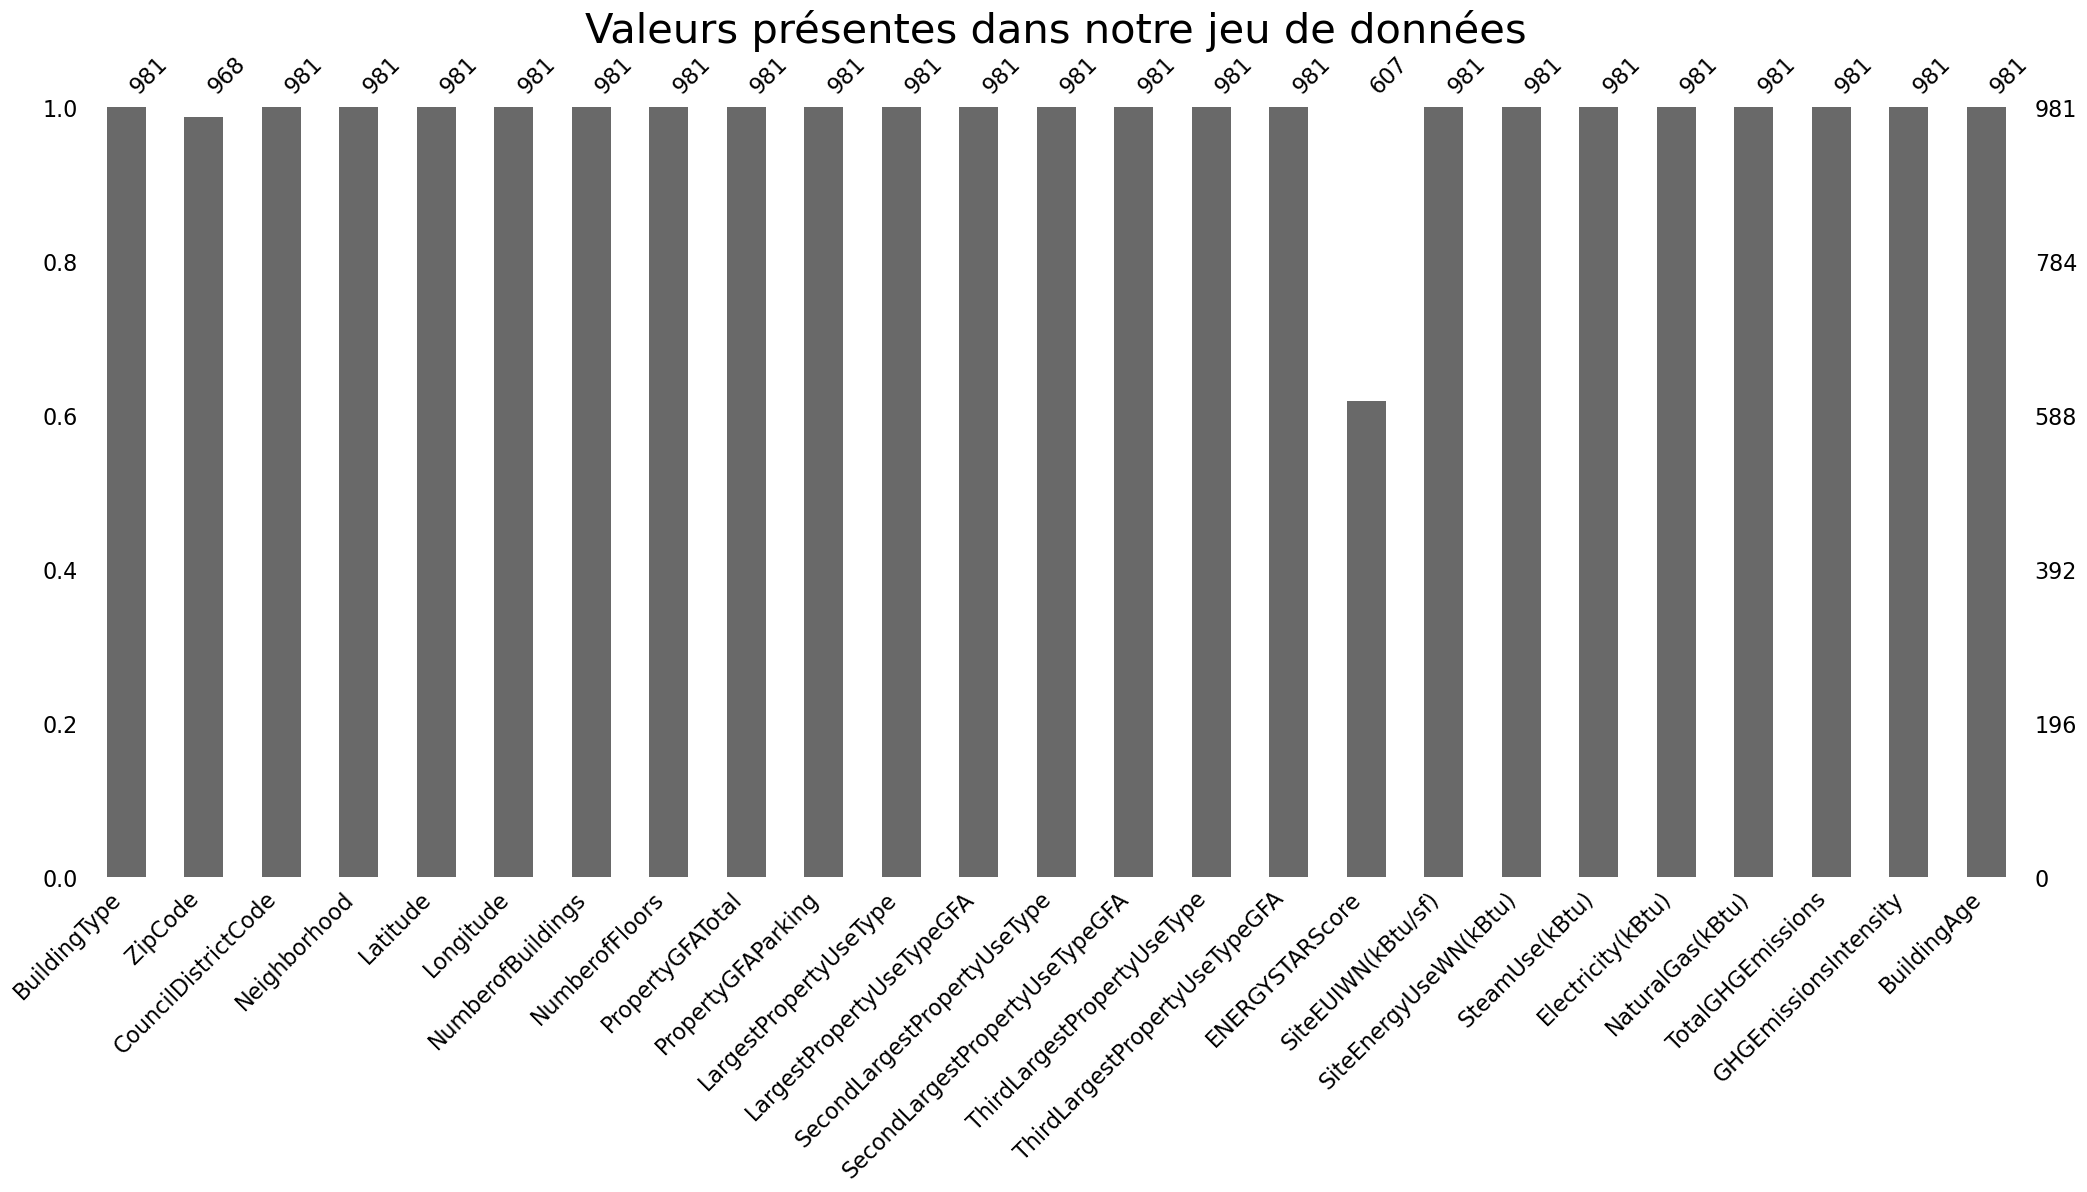

In [118]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_completed)

Les données manquantes sont celles de l'EnergyStarScore, comme nous voulons en étudier l'intérêt pour nos modèles nous allons conserver un dataframe avec l'energystarscore à part.<br>
Il nous manque également quleques ZipCode.

In [119]:
df = df_completed.copy()

In [120]:
df.shape

(981, 25)

In [121]:
df_with_EnergyStarScore = df_completed.dropna()

In [122]:
df_with_EnergyStarScore.shape

(607, 25)

## Feature Engineering

### Cas des parkings

In [123]:
number_of_1use_parking = len(df[df['LargestPropertyUseType'] == 'Parking'])
number_of_2use_parking = len(df[df['SecondLargestPropertyUseType'] == 'Parking'])
number_of_3use_parking = len(df[df['ThirdLargestPropertyUseType'] == 'Parking'])
print(number_of_1use_parking, number_of_2use_parking, number_of_3use_parking)

0 61 18


In [124]:
def update_parking_usage(row):
    if row['ThirdLargestPropertyUseType'] == "Parking":
        if row['ThirdLargestPropertyUseTypeGFA'] < row['PropertyGFAParking']:
            row['PropertyGFAParking'] = row['ThirdLargestPropertyUseTypeGFA']
        row['ThirdLargestPropertyUseType'] = np.nan
        row['ThirdLargestPropertyUseTypeGFA'] = np.nan    
    
    if row['SecondLargestPropertyUseType'] == "Parking":
        if row['SecondLargestPropertyUseTypeGFA'] < row['PropertyGFAParking']:
            row['PropertyGFAParking'] = row['SecondLargestPropertyUseTypeGFA']
        row['SecondLargestPropertyUseType'] = row['ThirdLargestPropertyUseType']
        row['SecondLargestPropertyUseTypeGFA'] = row['ThirdLargestPropertyUseTypeGFA']
        row['ThirdLargestPropertyUseType'] = np.nan
        row['ThirdLargestPropertyUseTypeGFA'] = np.nan
    return row

# Appliquer la fonction à chaque ligne du DataFrame
df = df.apply(update_parking_usage, axis=1)
df = df.apply(fill_missing_types_and_calculate_gfa, axis=1)

In [125]:
number_of_1use_parking = len(df[df['LargestPropertyUseType'] == 'Parking'])
number_of_2use_parking = len(df[df['SecondLargestPropertyUseType'] == 'Parking'])
number_of_3use_parking = len(df[df['ThirdLargestPropertyUseType'] == 'Parking'])
print(number_of_1use_parking, number_of_2use_parking, number_of_3use_parking)

0 0 0


### Passage en pourcentage de GFA par type d'utilisation

In [126]:
# Calculer le pourcentage pour le plus grand usage du bâtiment
df['LargestPropertyUseTypeGFA_pct'] = (df['LargestPropertyUseTypeGFA'] / 
                                            df['PropertyGFATotal']) * 100

# Calculer le pourcentage pour le deuxième plus grand usage du bâtiment
df['SecondLargestPropertyUseTypeGFA_pct'] = (df['SecondLargestPropertyUseTypeGFA'] / 
                                                  df['PropertyGFATotal']) * 100

# Calculer le pourcentage pour le troisième plus grand usage du bâtiment
df['ThirdLargestPropertyUseTypeGFA_pct'] = (df['ThirdLargestPropertyUseTypeGFA'] / 
                                                 df['PropertyGFATotal']) * 100

# Calculer le pourcentage pour le parking du bâtiment
df['PropertyGFAParking_pct'] = (df['PropertyGFAParking'] / 
                                     df['PropertyGFATotal']) * 100

# Supprimer les anciennes colonnes
df = df.drop(columns=['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','PropertyGFAParking'])


In [127]:
def adjust_percentages(row):
    # Calculer la somme totale des pourcentages actuels
    total_pct = row['LargestPropertyUseTypeGFA_pct'] + row['SecondLargestPropertyUseTypeGFA_pct'] + row['ThirdLargestPropertyUseTypeGFA_pct'] + row['PropertyGFAParking_pct']
    
    # Ajuster chaque pourcentage pour que la somme soit égale à 100%
    row['LargestPropertyUseTypeGFA_pct'] = (row['LargestPropertyUseTypeGFA_pct'] / total_pct) * 100
    row['SecondLargestPropertyUseTypeGFA_pct'] = (row['SecondLargestPropertyUseTypeGFA_pct'] / total_pct) * 100
    row['ThirdLargestPropertyUseTypeGFA_pct'] = (row['ThirdLargestPropertyUseTypeGFA_pct'] / total_pct) * 100
    row['PropertyGFAParking_pct'] = (row['PropertyGFAParking_pct'] / total_pct) * 100

    return row

# Appliquer la fonction pour ajuster les pourcentages à chaque ligne du DataFrame
df = df.apply(adjust_percentages, axis=1)

In [128]:
df.head(5)

BuildingType  ZipCode  CouncilDistrictCode Neighborhood  Latitude  \
0  NonResidential  98101.0                    7     DOWNTOWN  47.61220   
1  NonResidential  98101.0                    7     DOWNTOWN  47.61317   
3  NonResidential  98101.0                    7     DOWNTOWN  47.61412   
6  NonResidential  98101.0                    7     DOWNTOWN  47.61390   
7  NonResidential  98101.0                    7     DOWNTOWN  47.61327   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
3 -122.33664                1.0              10             61320   
6 -122.33283                1.0              11             83008   
7 -122.33136                1.0               8            102761   

                  LargestPropertyUseType SecondLargestPropertyUseType  \
0                                  Hotel                         None   
1                                  Hotel                   Restaurant   
3                                  Hotel                         None   
6                                  Hotel                         None   
7  Other - Entertainment/Public Assembly                         None   

  ThirdLargestPropertyUseType  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
0                        None             60.0           84.300003   
1                        None             61.0           97.900002   
3                        None             56.0          113.300003   
6                        None             27.0           74.500000   
7                        None              NaN           68.800003   

   SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  \
0              7456910.0      2003882.00          3946027.0         1276453.0   
1              8664479.0            0.00          3242851.0         5145082.0   
3              6946800.5      2214446.25          2768924.0         1811213.0   
6              6062767.5            0.00          2811215.0         2947580.0   
7              7067881.5      2276286.50          3636655.0          385189.0   

   TotalGHGEmissions  GHGEmissionsIntensity  BuildingAge  \
0             249.98                   2.83           89   
1             295.86                   2.86           20   
3             286.43                   4.67           90   
6             176.14                   2.12           90   
7             221.51                   2.16           90   

   LargestPropertyUseTypeGFA_pct  SecondLargestPropertyUseTypeGFA_pct  \
0                     100.000000                             0.000000   
1                      80.991831                             4.462855   
3                     100.000000                             0.000000   
6                     100.000000                             0.000000   
7                     100.000000                             0.000000   

   ThirdLargestPropertyUseTypeGFA_pct  PropertyGFAParking_pct  
0                                 0.0                0.000000  
1                                 0.0               14.545314  
3                                 0.0                0.000000  
6                                 0.0                0.000000  
7                                 0.0                0.000000

### Traitement des fuites de données

Electricity(kBtu), SteamUse(kBtu) et NaturalGas(kBtu) sont des fuites de données. Nous ne voulons pas les récupérer pour nos prédictions mais nous pouvons tout de même savoir leur taux d'utilisation dans le bâtiment.

In [129]:
cols_energie = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

# Calcul du pourcentage d'utilisation pour chaque type d'énergie
for col in cols_energie:
    new_col_name = col.replace('(kBtu)', '') + '_pct'
    df[new_col_name] = (df[col] / df['SiteEnergyUseWN(kBtu)']) * 100

# supprimer les colonnes des energie kBtu
df = df.drop(columns=cols_energie).copy()

In [130]:
df.head(5)

BuildingType  ZipCode  CouncilDistrictCode Neighborhood  Latitude  \
0  NonResidential  98101.0                    7     DOWNTOWN  47.61220   
1  NonResidential  98101.0                    7     DOWNTOWN  47.61317   
3  NonResidential  98101.0                    7     DOWNTOWN  47.61412   
6  NonResidential  98101.0                    7     DOWNTOWN  47.61390   
7  NonResidential  98101.0                    7     DOWNTOWN  47.61327   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
3 -122.33664                1.0              10             61320   
6 -122.33283                1.0              11             83008   
7 -122.33136                1.0               8            102761   

                  LargestPropertyUseType SecondLargestPropertyUseType  \
0                                  Hotel                         None   
1                                  Hotel                   Restaurant   
3                                  Hotel                         None   
6                                  Hotel                         None   
7  Other - Entertainment/Public Assembly                         None   

  ThirdLargestPropertyUseType  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
0                        None             60.0           84.300003   
1                        None             61.0           97.900002   
3                        None             56.0          113.300003   
6                        None             27.0           74.500000   
7                        None              NaN           68.800003   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  \
0              7456910.0             249.98                   2.83   
1              8664479.0             295.86                   2.86   
3              6946800.5             286.43                   4.67   
6              6062767.5             176.14                   2.12   
7              7067881.5             221.51                   2.16   

   BuildingAge  LargestPropertyUseTypeGFA_pct  \
0           89                     100.000000   
1           20                      80.991831   
3           90                     100.000000   
6           90                     100.000000   
7           90                     100.000000   

   SecondLargestPropertyUseTypeGFA_pct  ThirdLargestPropertyUseTypeGFA_pct  \
0                             0.000000                                 0.0   
1                             4.462855                                 0.0   
3                             0.000000                                 0.0   
6                             0.000000                                 0.0   
7                             0.000000                                 0.0   

   PropertyGFAParking_pct  SteamUse_pct  Electricity_pct  NaturalGas_pct  
0                0.000000     26.872820        52.917723       17.117720  
1               14.545314      0.000000        37.426959       59.381320  
3                0.000000     31.877211        39.858983       26.072621  
6                0.000000      0.000000        46.368511       48.617731  
7                0.000000     32.206065        51.453254        5.449851

# Analyse Exploratoire des Données

## Analyse Univariée

### Variables numériques

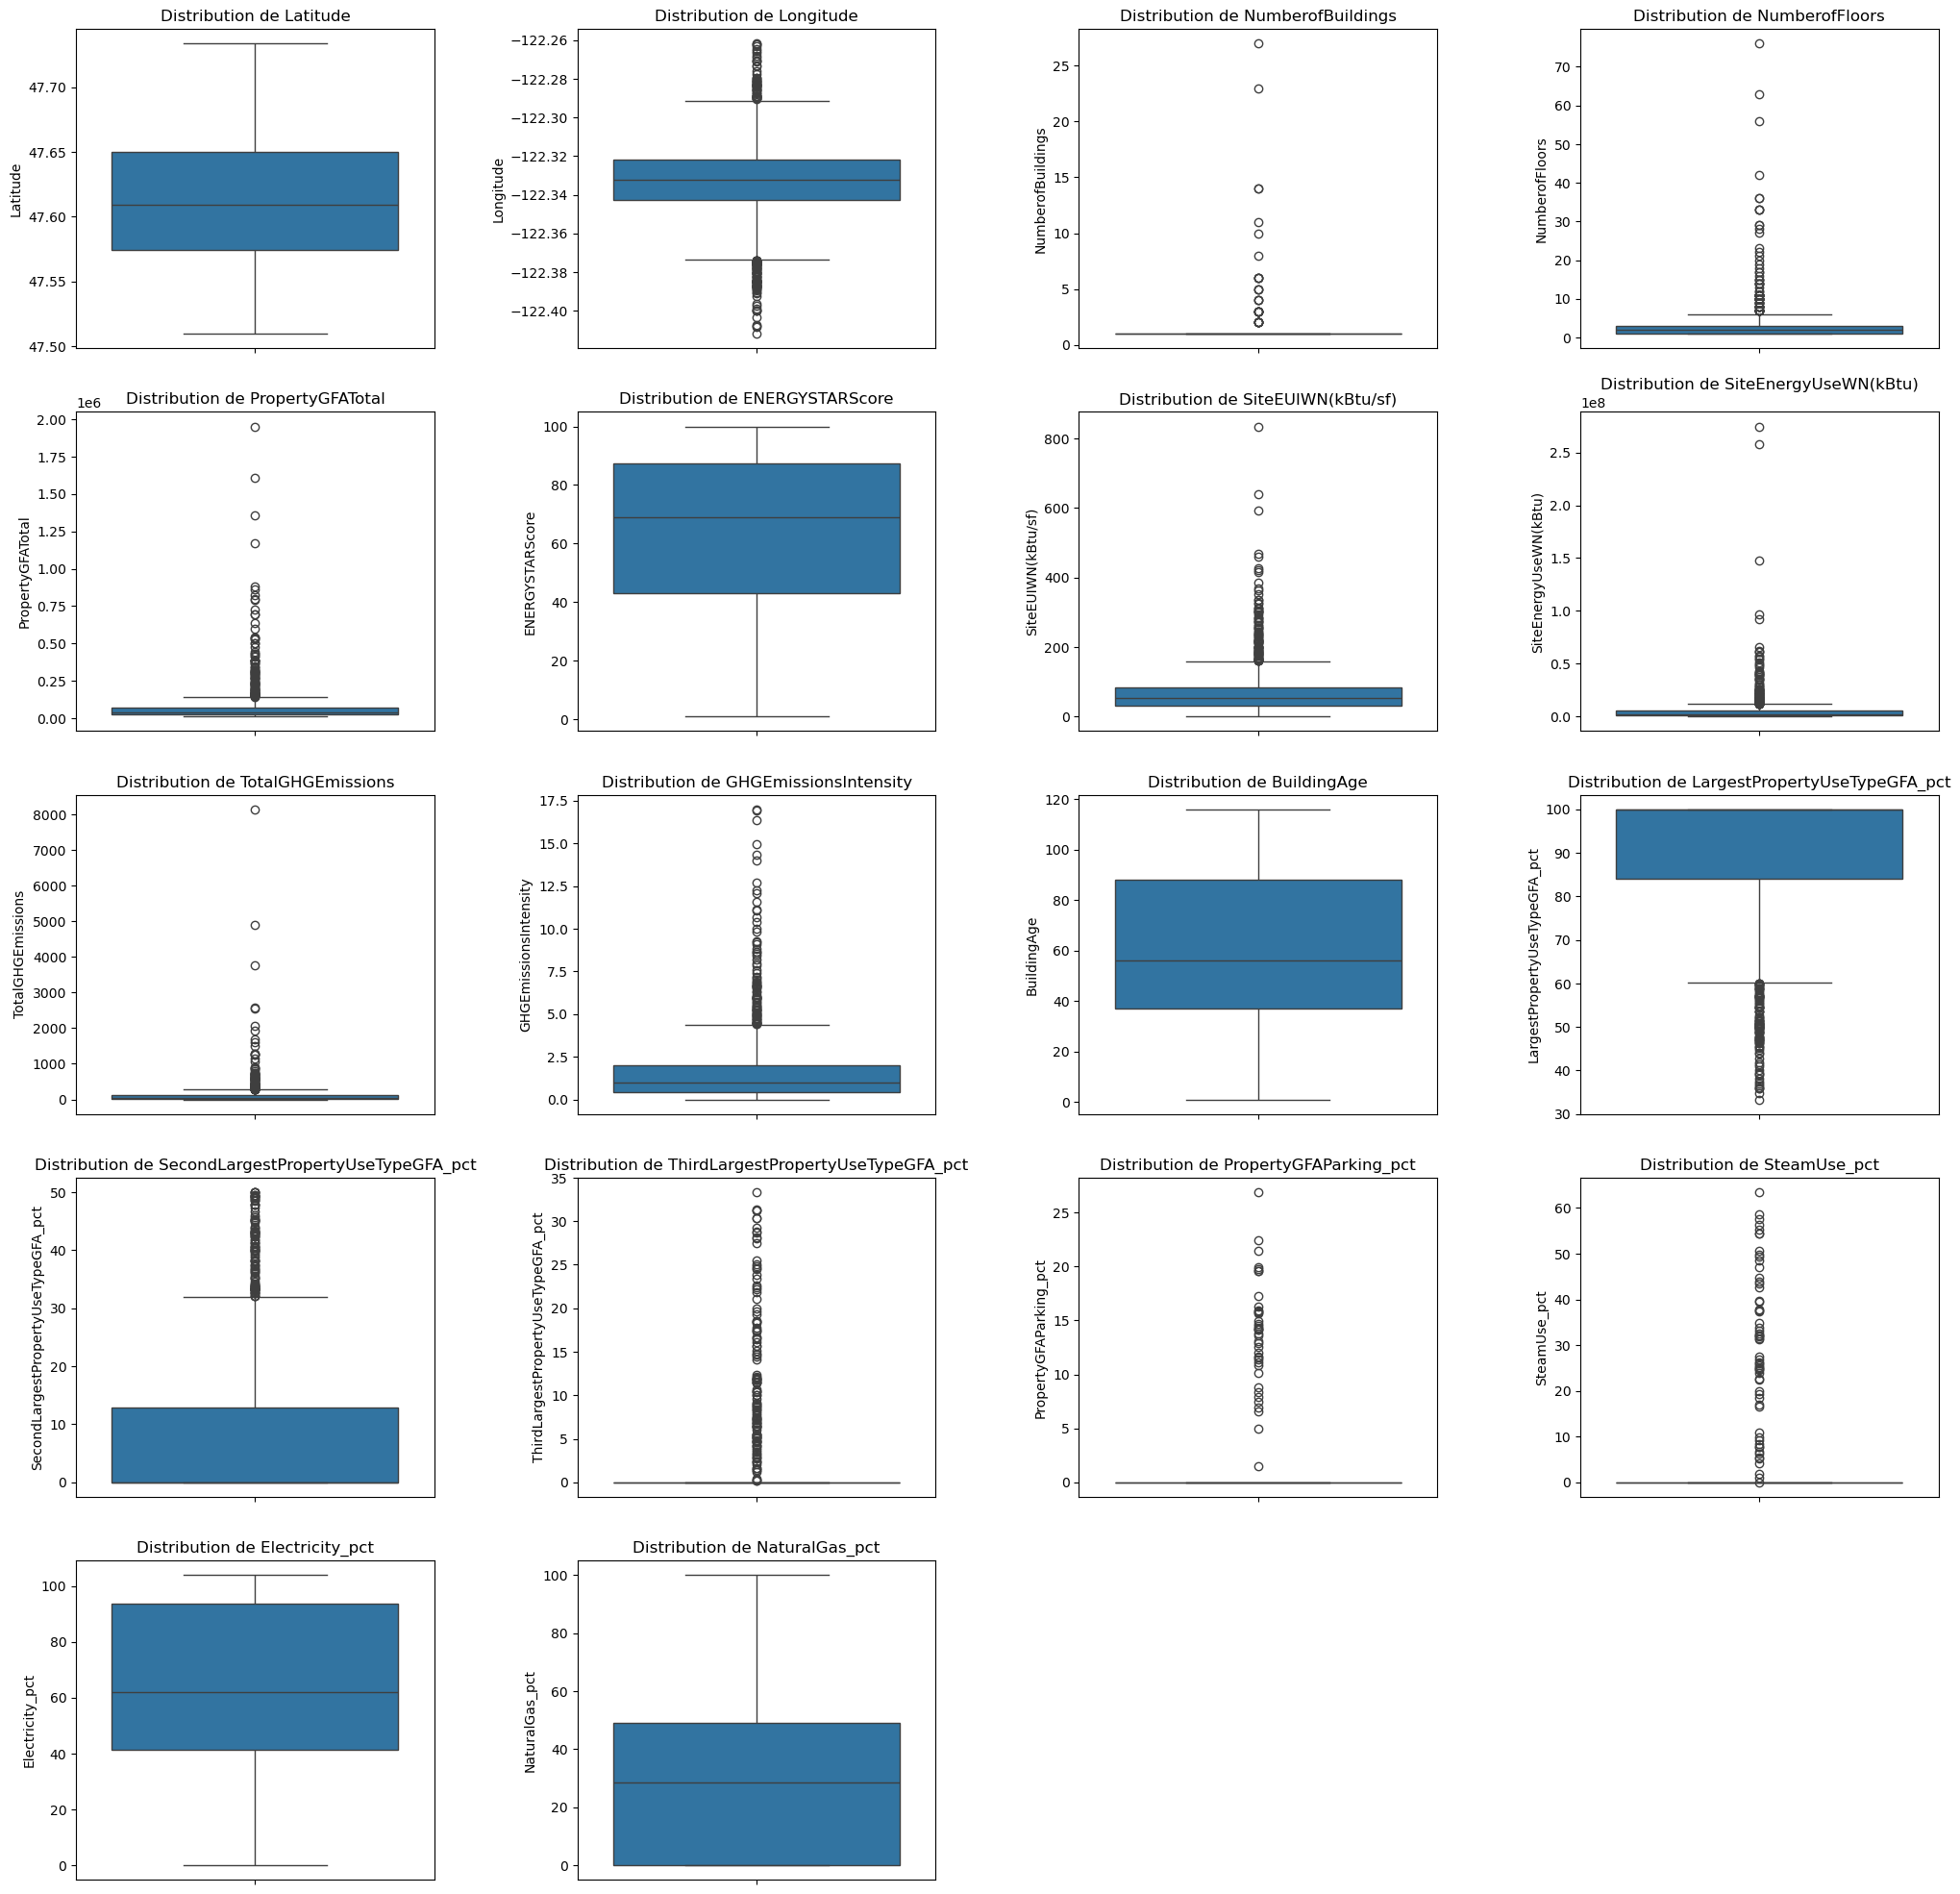

In [131]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df.select_dtypes(include=['number']).columns.drop(['ZipCode', 'CouncilDistrictCode'])

# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25,25))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 20):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [132]:
df.describe()

ZipCode  CouncilDistrictCode    Latitude   Longitude  \
count    968.000000           981.000000  981.000000  981.000000   
mean   98118.005165             4.061162   47.612735 -122.333146   
std       18.470216             2.191433    0.050954    0.024963   
min    98011.000000             1.000000   47.509590 -122.411820   
25%    98105.000000             2.000000   47.573840 -122.342680   
50%    98115.000000             4.000000   47.609010 -122.332380   
75%    98126.000000             7.000000   47.650190 -122.321930   
max    98199.000000             7.000000   47.733680 -122.261800   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  ENERGYSTARScore  \
count         981.000000      981.000000      9.810000e+02       607.000000   
mean            1.165138        3.283384      8.001593e+04        62.492586   
std             1.396515        5.377316      1.397881e+05        28.950331   
min             1.000000        1.000000      1.128500e+04         1.000000   
25%             1.000000        1.000000      2.617600e+04        43.000000   
50%             1.000000        2.000000      3.998400e+04        69.000000   
75%             1.000000        3.000000      7.326000e+04        87.500000   
max            27.000000       76.000000      1.952220e+06       100.000000   

       SiteEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  \
count          981.000000           9.810000e+02         981.000000   
mean            72.477472           6.058734e+06         133.515352   
std             75.329655           1.579509e+07         394.728707   
min              0.000000           0.000000e+00           0.000000   
25%             32.000000           1.109137e+06          17.410000   
50%             51.900002           2.151546e+06          43.180000   
75%             83.000000           5.355753e+06         119.340000   
max            834.400024           2.747260e+08        8145.520000   

       GHGEmissionsIntensity  BuildingAge  LargestPropertyUseTypeGFA_pct  \
count             981.000000   981.000000                     981.000000   
mean                1.683537    59.392457                      89.607025   
std                 2.187200    30.829450                      17.051361   
min                 0.000000     1.000000                      33.333333   
25%                 0.400000    37.000000                      84.034035   
50%                 0.960000    56.000000                     100.000000   
75%                 2.000000    88.000000                     100.000000   
max                16.990000   116.000000                     100.000000   

       SecondLargestPropertyUseTypeGFA_pct  \
count                           981.000000   
mean                              8.250491   
std                              13.945223   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                              12.858991   
max                              50.000000   

       ThirdLargestPropertyUseTypeGFA_pct  PropertyGFAParking_pct  \
count                          981.000000              981.000000   
mean                             1.587282                0.555203   
std                              5.129835                2.875915   
min                              0.000000                0.000000   
25%                              0.000000                0.000000   
50%                              0.000000                0.000000   
75%                              0.000000                0.000000   
max                             33.333333               26.884478   

       SteamUse_pct  Electricity_pct  NaturalGas_pct  
count    978.000000       978.000000      978.000000  
mean       1.822093        64.056055       28.618218  
std        8.232404        27.604363       24.587454  
min        0.000000         0.000000        0.000000  
25%        0.000000        41.442182        0.0000

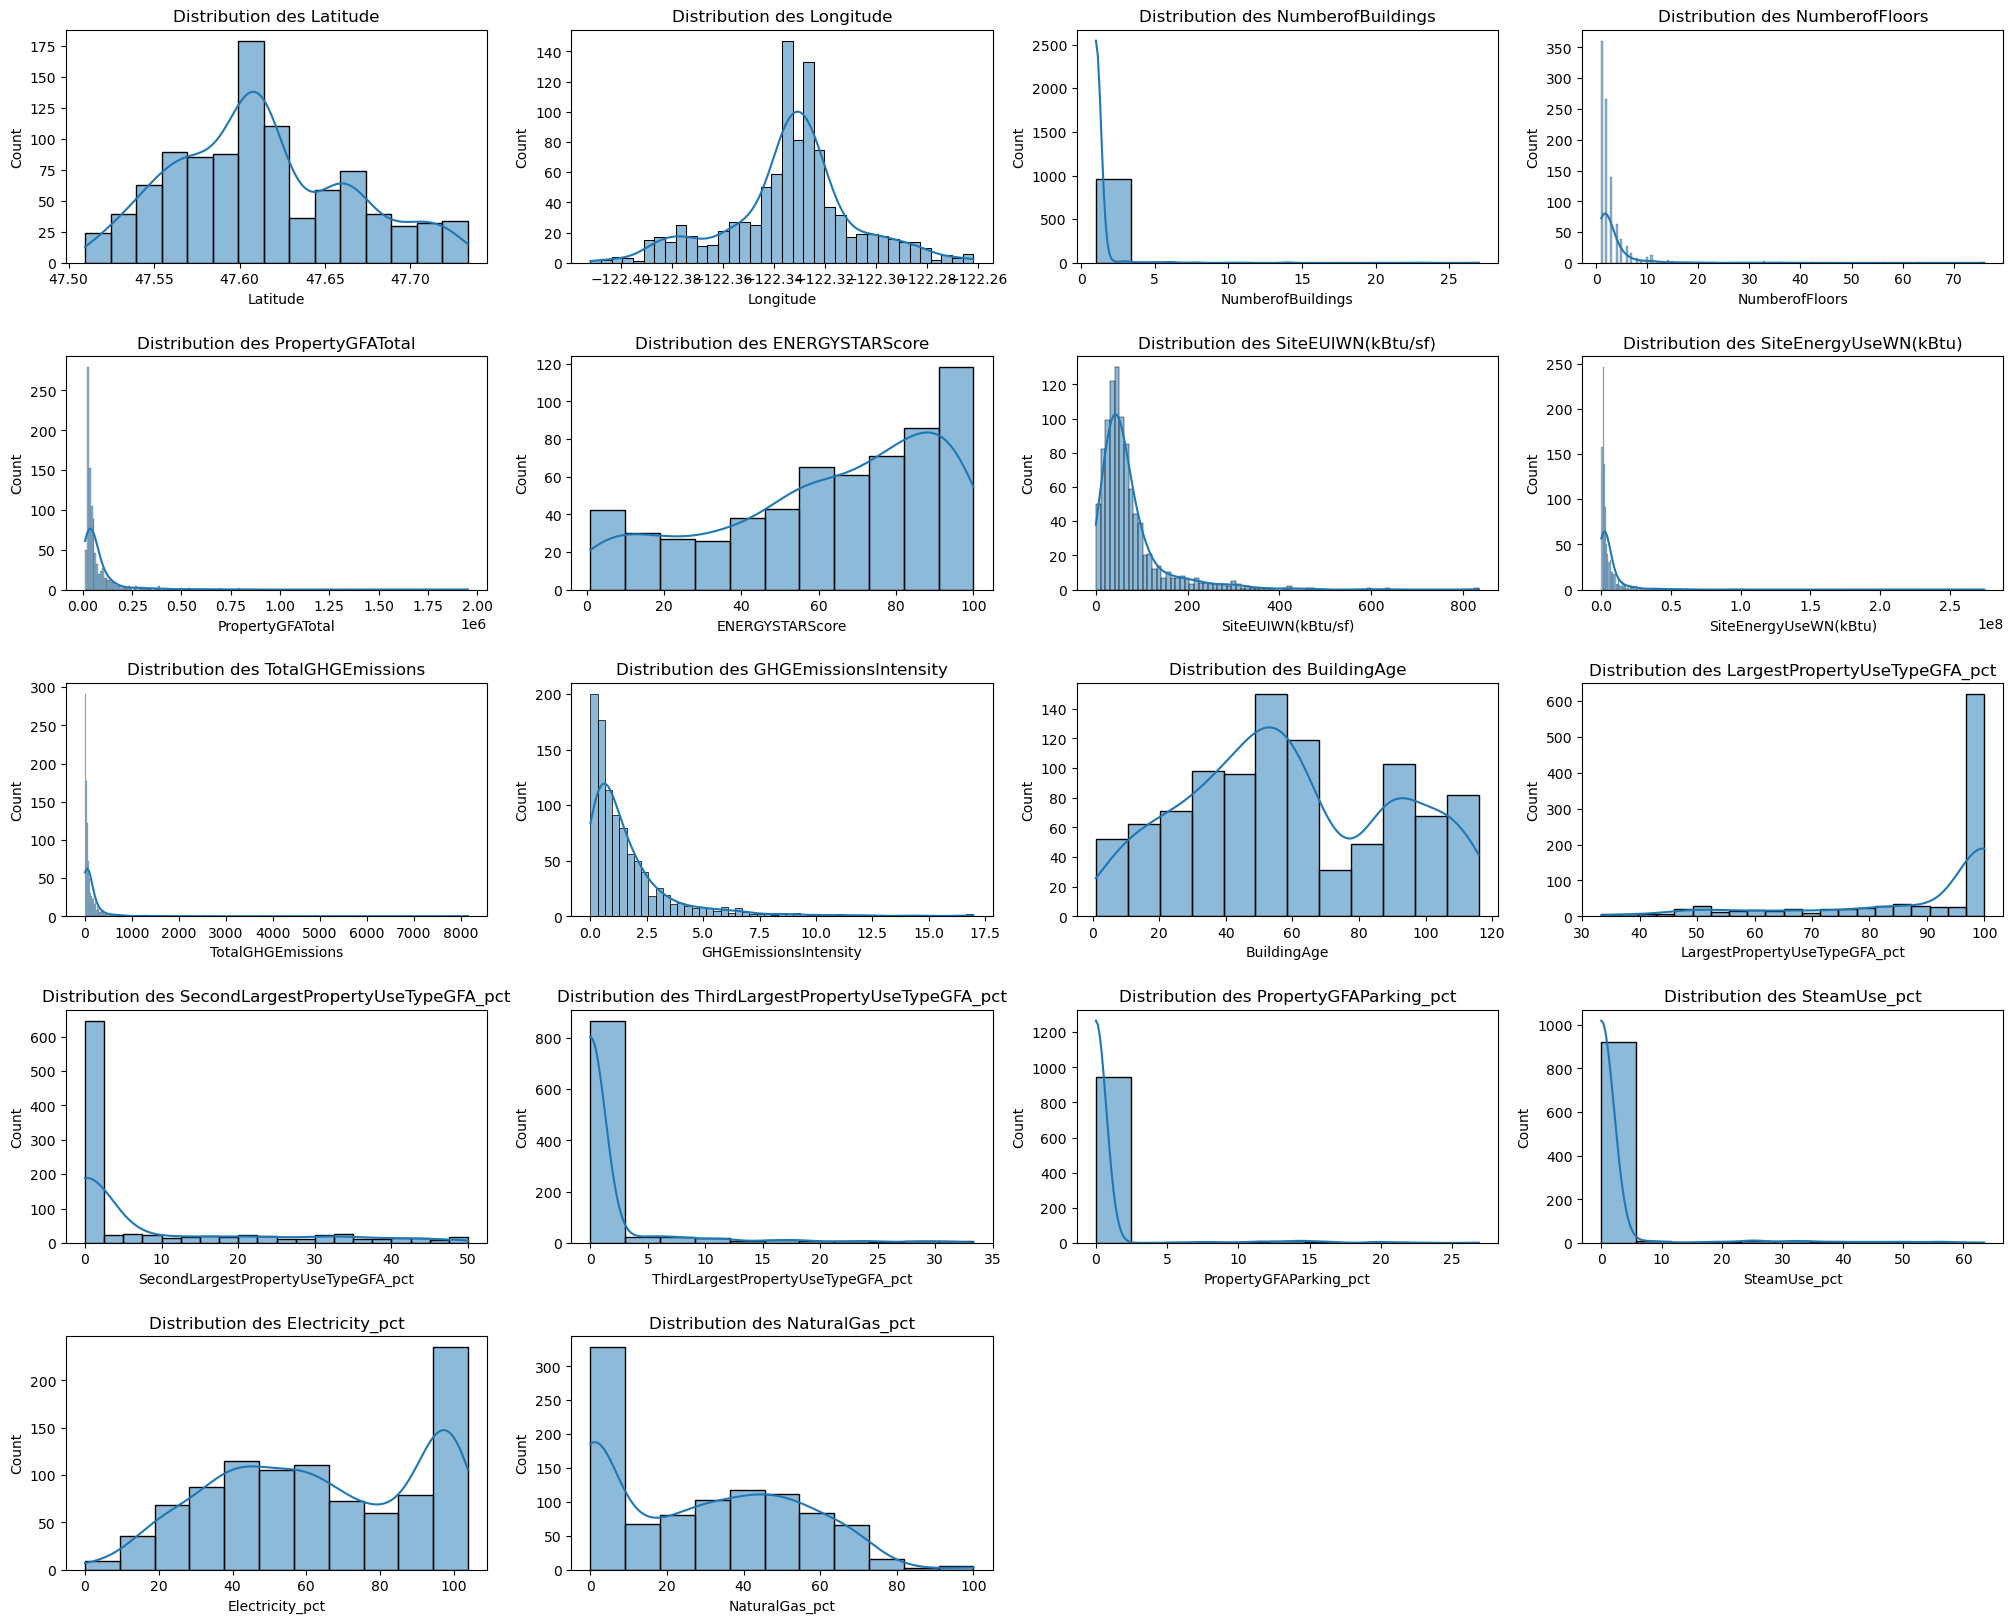

In [133]:
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25,20))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

# Density plot
for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.histplot(data=df, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution des {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 20):
    fig.delaxes(axes.flatten()[j])

plt.show()

Les variables cibles de notre étides sont fortement assymétriques. Nous allons faire un passage au Log pour voir la nouvelle distribution

In [134]:
# Compter le nombre de valeurs zéro ou négatives dans 'TotalGHGEmissions'
count_zero_neg_ghg = len(df[df['TotalGHGEmissions'] <= 0])

# Compter le nombre de valeurs zéro ou négatives dans 'SiteEnergyUse(kBtu)'
count_zero_neg_energy = len(df[df['SiteEnergyUseWN(kBtu)'] <= 0])

# Afficher les résultats
print(f"Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': {count_zero_neg_ghg}")
print(f"Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': {count_zero_neg_energy}")


Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': 3
Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': 3


In [135]:
# Supprimer ces lignes
df = df[df['TotalGHGEmissions'] > 0]
df = df[df['SiteEnergyUseWN(kBtu)'] > 0]
df.shape

(978, 25)

In [136]:
# Calculer le logarithme des colonnes 'TotalGHGEmissions' et 'SiteEnergyUseWN(kBtu)'
df = df.copy()
df['Log_TotalGHGEmissions'] = np.log(df['TotalGHGEmissions'])
df['Log_SiteEnergyUseWN'] = np.log(df['SiteEnergyUseWN(kBtu)'])

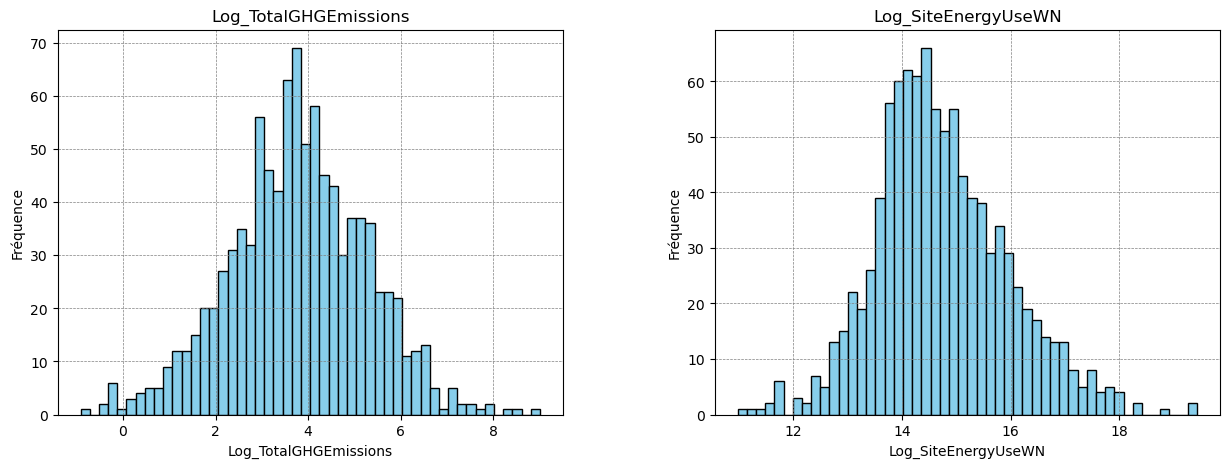

In [137]:
# Créez un histogramme pour TotalGHGEmissions et SiteEnergyUse(kBtu)
# Sélection des colonnes spécifiques
selected_columns = df[['Log_TotalGHGEmissions','Log_SiteEnergyUseWN']]

# Créez un histogramme pour chaque variable numérique sélectionnée
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, column in zip(axes, selected_columns.columns):
    ax.hist(df[column], bins=50, edgecolor='black', color='skyblue')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Fréquence')
    # Ajouter un quadrillage
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    
# Ajustez l'espace entre les subplots
plt.subplots_adjust(wspace=0.3)

# Affichez les histogrammes
plt.show()

### Variables catégorielles

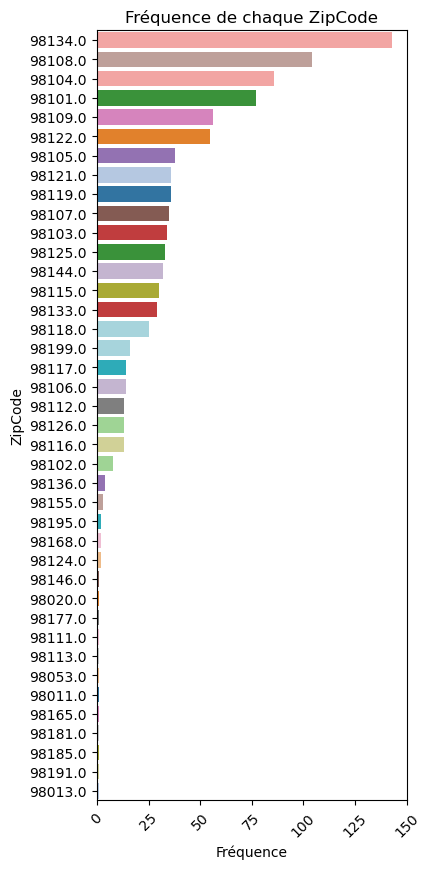

In [138]:
# ZipCode
group_counts = df['ZipCode'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='ZipCode', data=df, order=group_counts.index, hue='ZipCode', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque ZipCode')
plt.xlabel('Fréquence')
plt.ylabel('ZipCode')

plt.show()

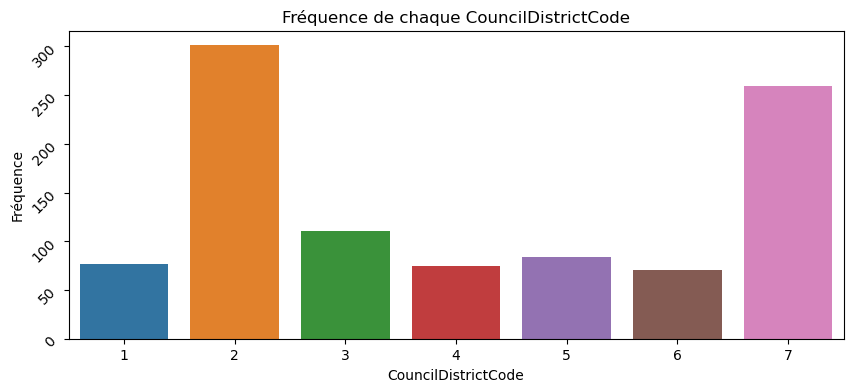

In [139]:
# Compter le nombre d'occurrences pour chaque CouncilDistrictCode
group_counts = df['CouncilDistrictCode'].value_counts().reset_index()
group_counts.columns = ['CouncilDistrictCode', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='CouncilDistrictCode', y='Counts', data=group_counts, hue='CouncilDistrictCode', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque CouncilDistrictCode')
plt.ylabel('Fréquence')
plt.xlabel('CouncilDistrictCode')

plt.show()

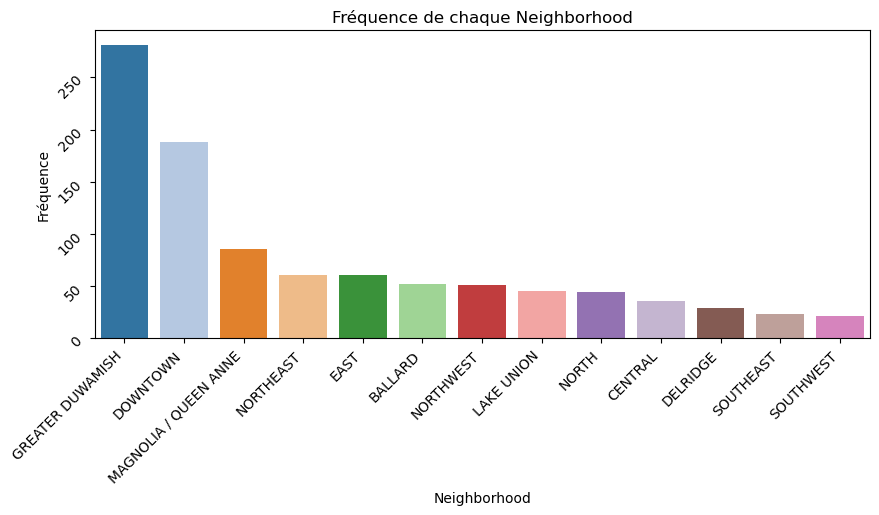

In [140]:
# Compter le nombre d'occurrences pour chaque Neighborhood
group_counts = df['Neighborhood'].value_counts().reset_index()
group_counts.columns = ['Neighborhood', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='Neighborhood', y='Counts', data=group_counts, hue='Neighborhood', palette="tab20", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque Neighborhood')
plt.ylabel('Fréquence')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha="right")

plt.show()

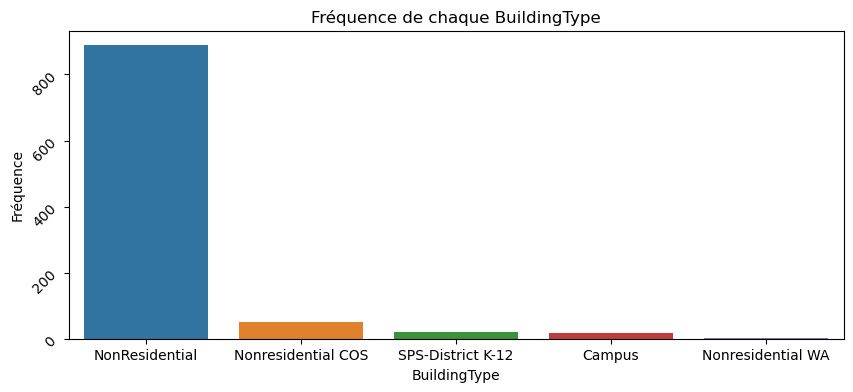

In [141]:
# Compter le nombre d'occurrences pour chaque BuildingType
group_counts = df['BuildingType'].value_counts().reset_index()
group_counts.columns = ['BuildingType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='BuildingType', y='Counts', data=group_counts, hue='BuildingType', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque BuildingType')
plt.ylabel('Fréquence')
plt.xlabel('BuildingType')

plt.show()

La très forte surreprésentation de la première catégorie rendra l'utilisation de cette variable moins pertinante.

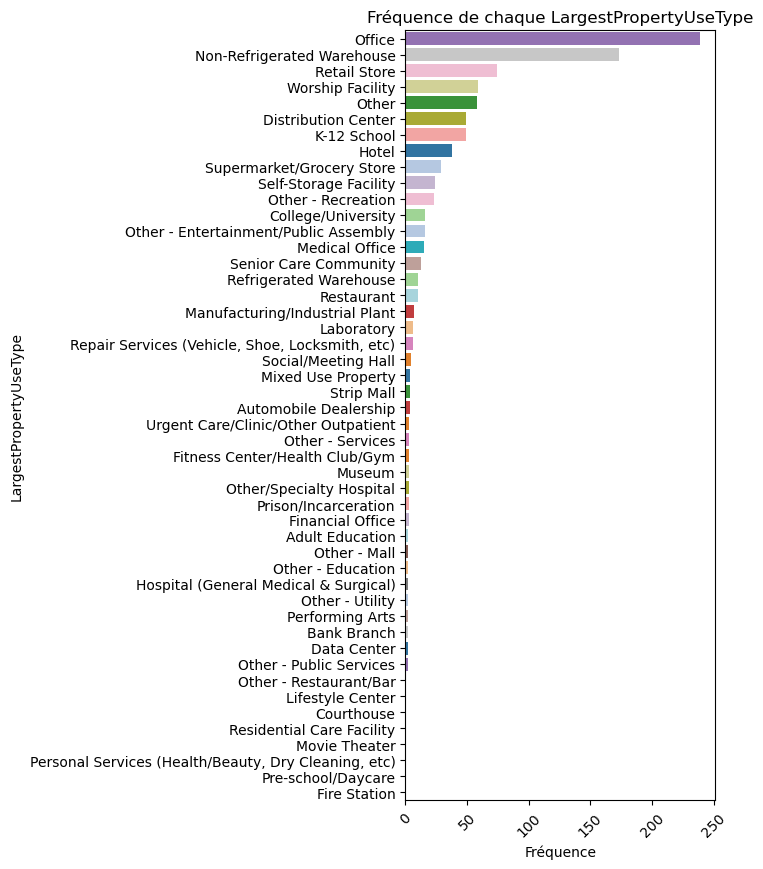

In [142]:
# LargestPropertyUseType
group_counts = df['LargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='LargestPropertyUseType', data=df, order=group_counts.index, hue='LargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque LargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('LargestPropertyUseType')

plt.show()

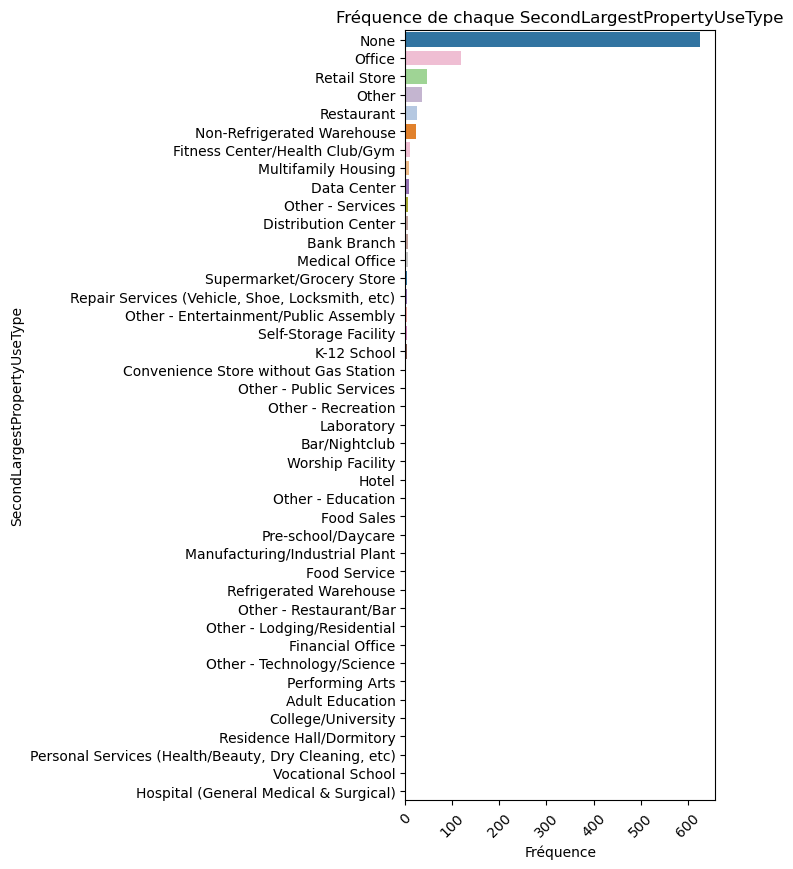

In [143]:
# SecondLargestPropertyUseType
group_counts = df['SecondLargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='SecondLargestPropertyUseType', data=df, order=group_counts.index, hue='SecondLargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque SecondLargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('SecondLargestPropertyUseType')

plt.show()

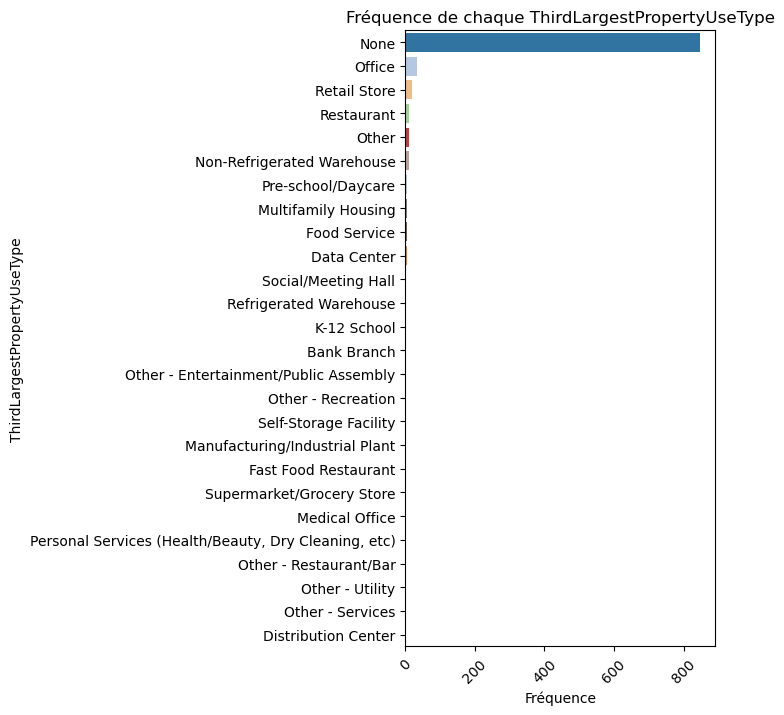

In [144]:
# ThirdLargestPropertyUseType
group_counts = df['ThirdLargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 8))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='ThirdLargestPropertyUseType', data=df, order=group_counts.index, hue='ThirdLargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque ThirdLargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('ThirdLargestPropertyUseType')

plt.show()

## Analyse Bivariée

### Variables numériques

In [145]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df.copy()

# Sélectionner uniquement les colonnes numériques
numerics_col = df.select_dtypes(include=['number']).columns.drop(['ZipCode', 'CouncilDistrictCode'])

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df[numerics_col])

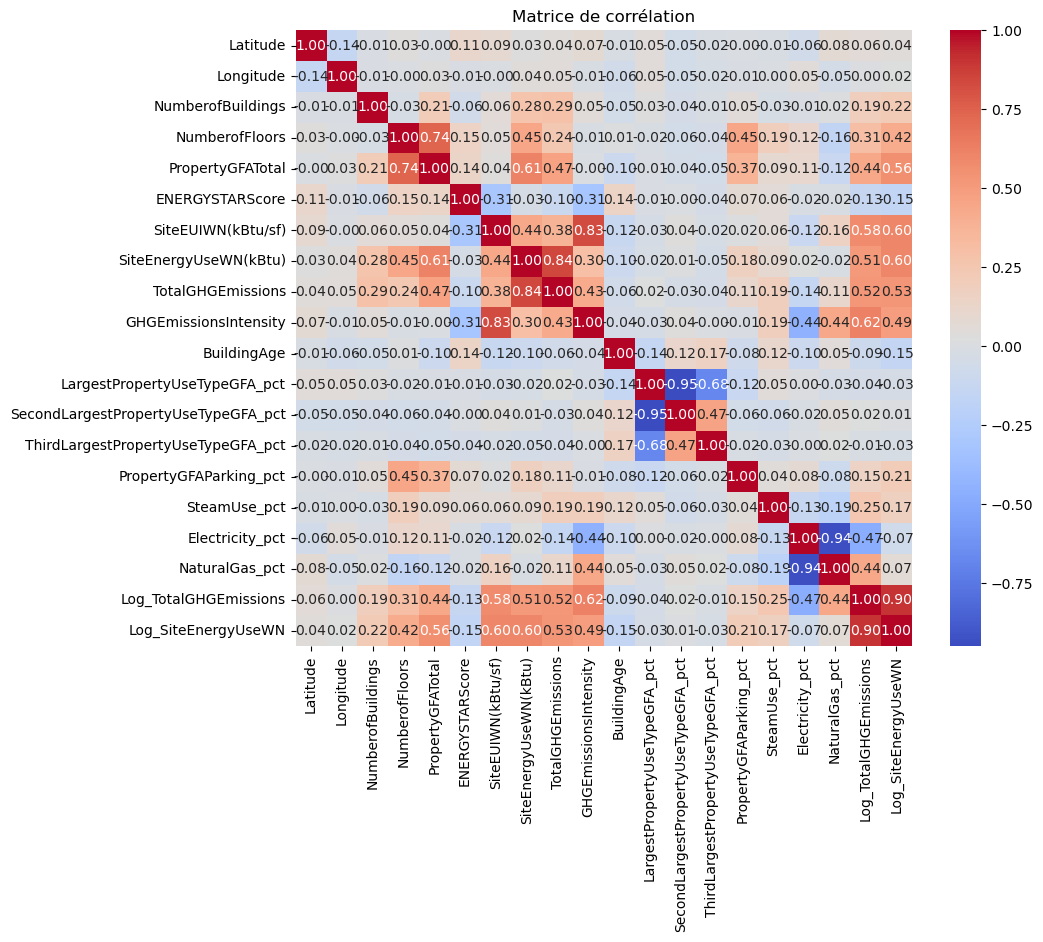

In [146]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

=> pas de corrélation évidente entre latitude et  longitude et nos cibles, on remarque cependant que les bâtiments les plus grands semblent rassemblés au centre de la ville avec en plus une utilisation de SteamUse plus marquée pour ces bâtiments. Un indicateur géographique serait intéressant à regarder (voir nos catégories pour choisir le plus précis)<br>
=> on voit pas mal de corrélation assez complexes, pas de variable a écarter pour le moment

### Cibles par rapport aux variables catégorielles

In [147]:
def plot_boxplots_by_category(df, category):
    sns.set(style="whitegrid")

    # Lignes en fonction du nombre de catégories
    num_categories = len(df[category].unique())
    height_per_subplot = 3
    total_height = (num_categories * height_per_subplot) / 10

    # 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, total_height), constrained_layout=True)

    # Orderby median de SiteEnergyUseWN(kBtu)
    order_energy = df.groupby(category)['Log_SiteEnergyUseWN'].median().sort_values(ascending=False).index
    # SiteEnergyUseWN(kBtu) boxplot
    sns.boxplot(y=category, x='Log_SiteEnergyUseWN', data=df, orient='h', ax=axes[0], order=order_energy)
    axes[0].set_title(f'Log_SiteEnergyUseWN by {category}')
    axes[0].set_xlabel('Log_SiteEnergyUseWN')
    axes[0].set_ylabel(category)

    # Orderby median de  TotalGHGEmissions
    order_ghg = df.groupby(category)['Log_TotalGHGEmissions'].median().sort_values(ascending=False).index
    # TotalGHGEmissions boxplot
    sns.boxplot(y=category, x='Log_TotalGHGEmissions', data=df, orient='h', ax=axes[1], order=order_ghg)
    axes[1].set_title(f'Log_TotalGHGEmissions by {category}')
    axes[1].set_xlabel('Log_TotalGHGEmissions')
    axes[1].set_ylabel('')

    #plt.tight_layout()
    plt.show()


In [148]:
# Liste des variables catégorielles qu'on veut analyser
categorical_columns = ['ZipCode','CouncilDistrictCode','Neighborhood']

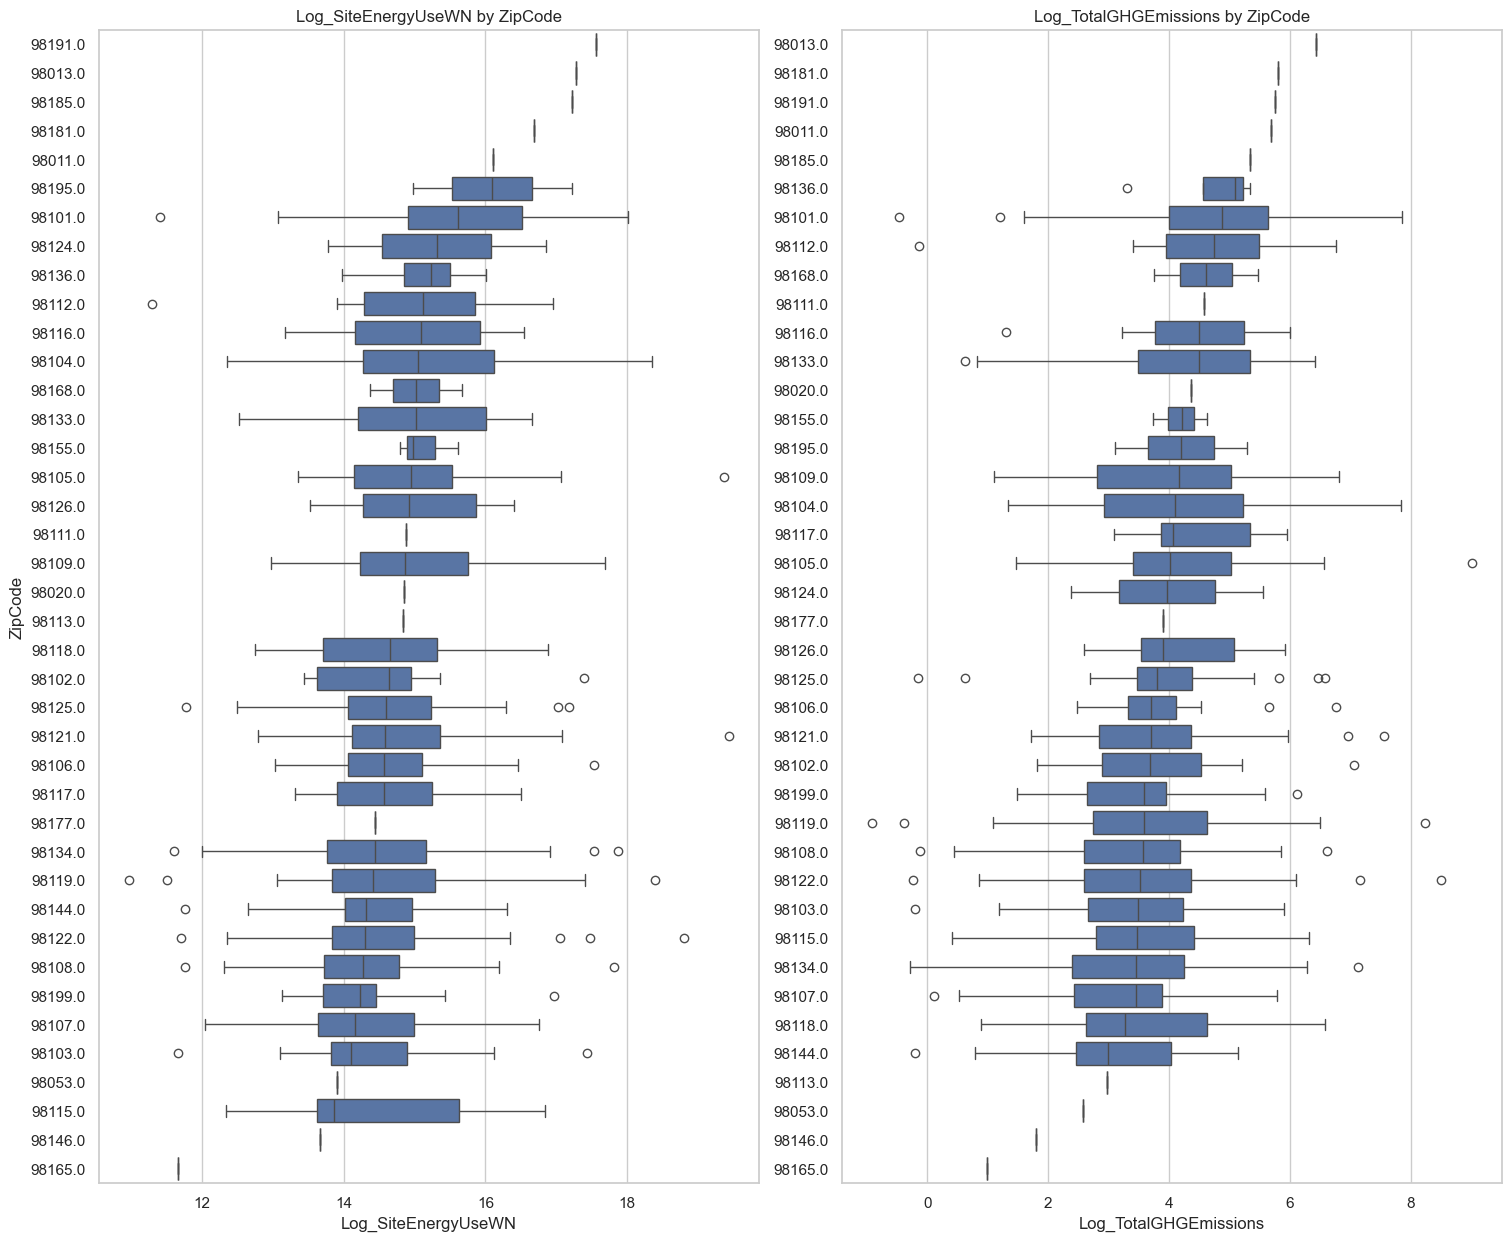

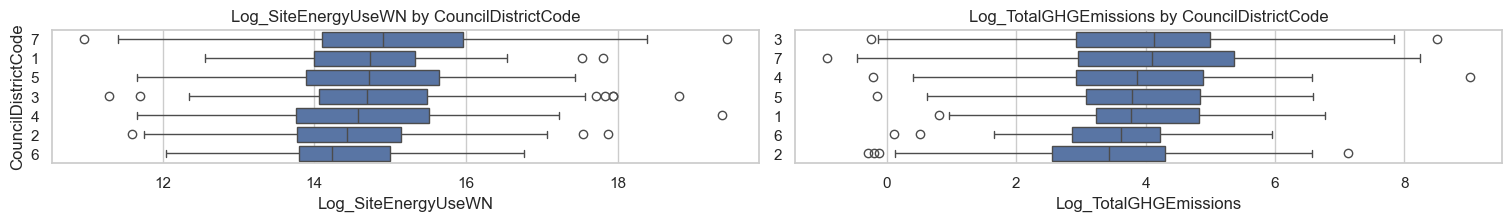

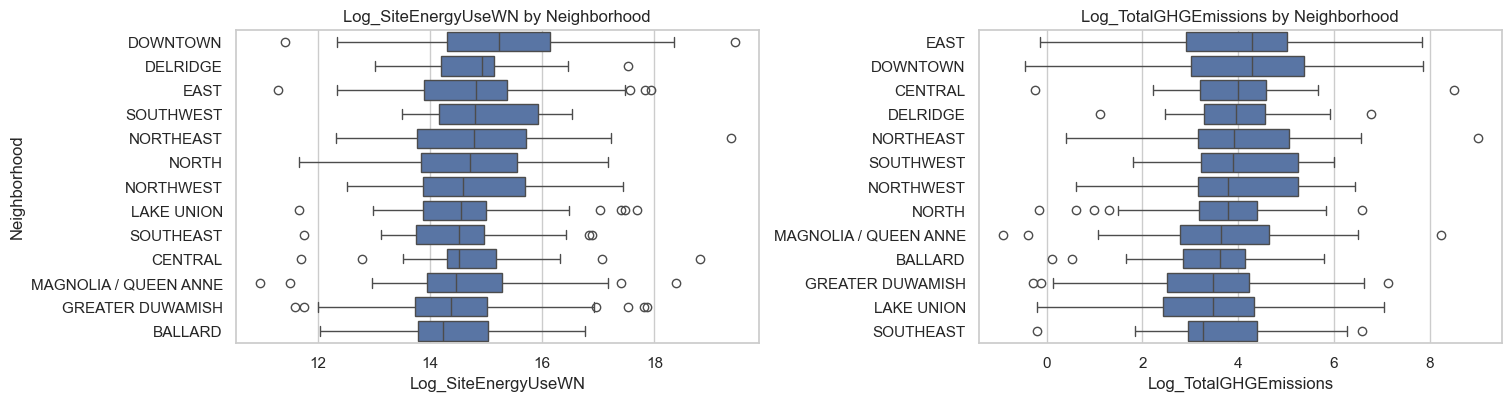

In [149]:
for category in categorical_columns:
    plot_boxplots_by_category(df, category)

## Analyse Multivariée (ANOVA)

In [150]:
def perform_anova_tukey(df, numeric_var, categorical_var):
    # Effectuez l'ANOVA
    formula = f"{numeric_var} ~ C({categorical_var})"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Effectuez le test de Tukey pour les comparaisons post-hoc
    tukey_result = pairwise_tukeyhsd(endog=df[numeric_var], groups=df[categorical_var], alpha=0.05)
    
    # Affichez les résultats
    print(f"ANOVA Table for {numeric_var} by {categorical_var}:")
    print(anova_table)
    print("\n")
    print(f"\nTukey's HSD Results for {numeric_var} by {categorical_var}:")
    print(tukey_result)



In [151]:
# Renommer la colonne pour ne pas avoir de probleme avec les caracteres spéciaux
df.rename(columns={'SiteEUIWN(kBtu/sf)': 'SiteEUIWN_kBtu_sf'}, inplace=True)

### CouncilDistrictCode

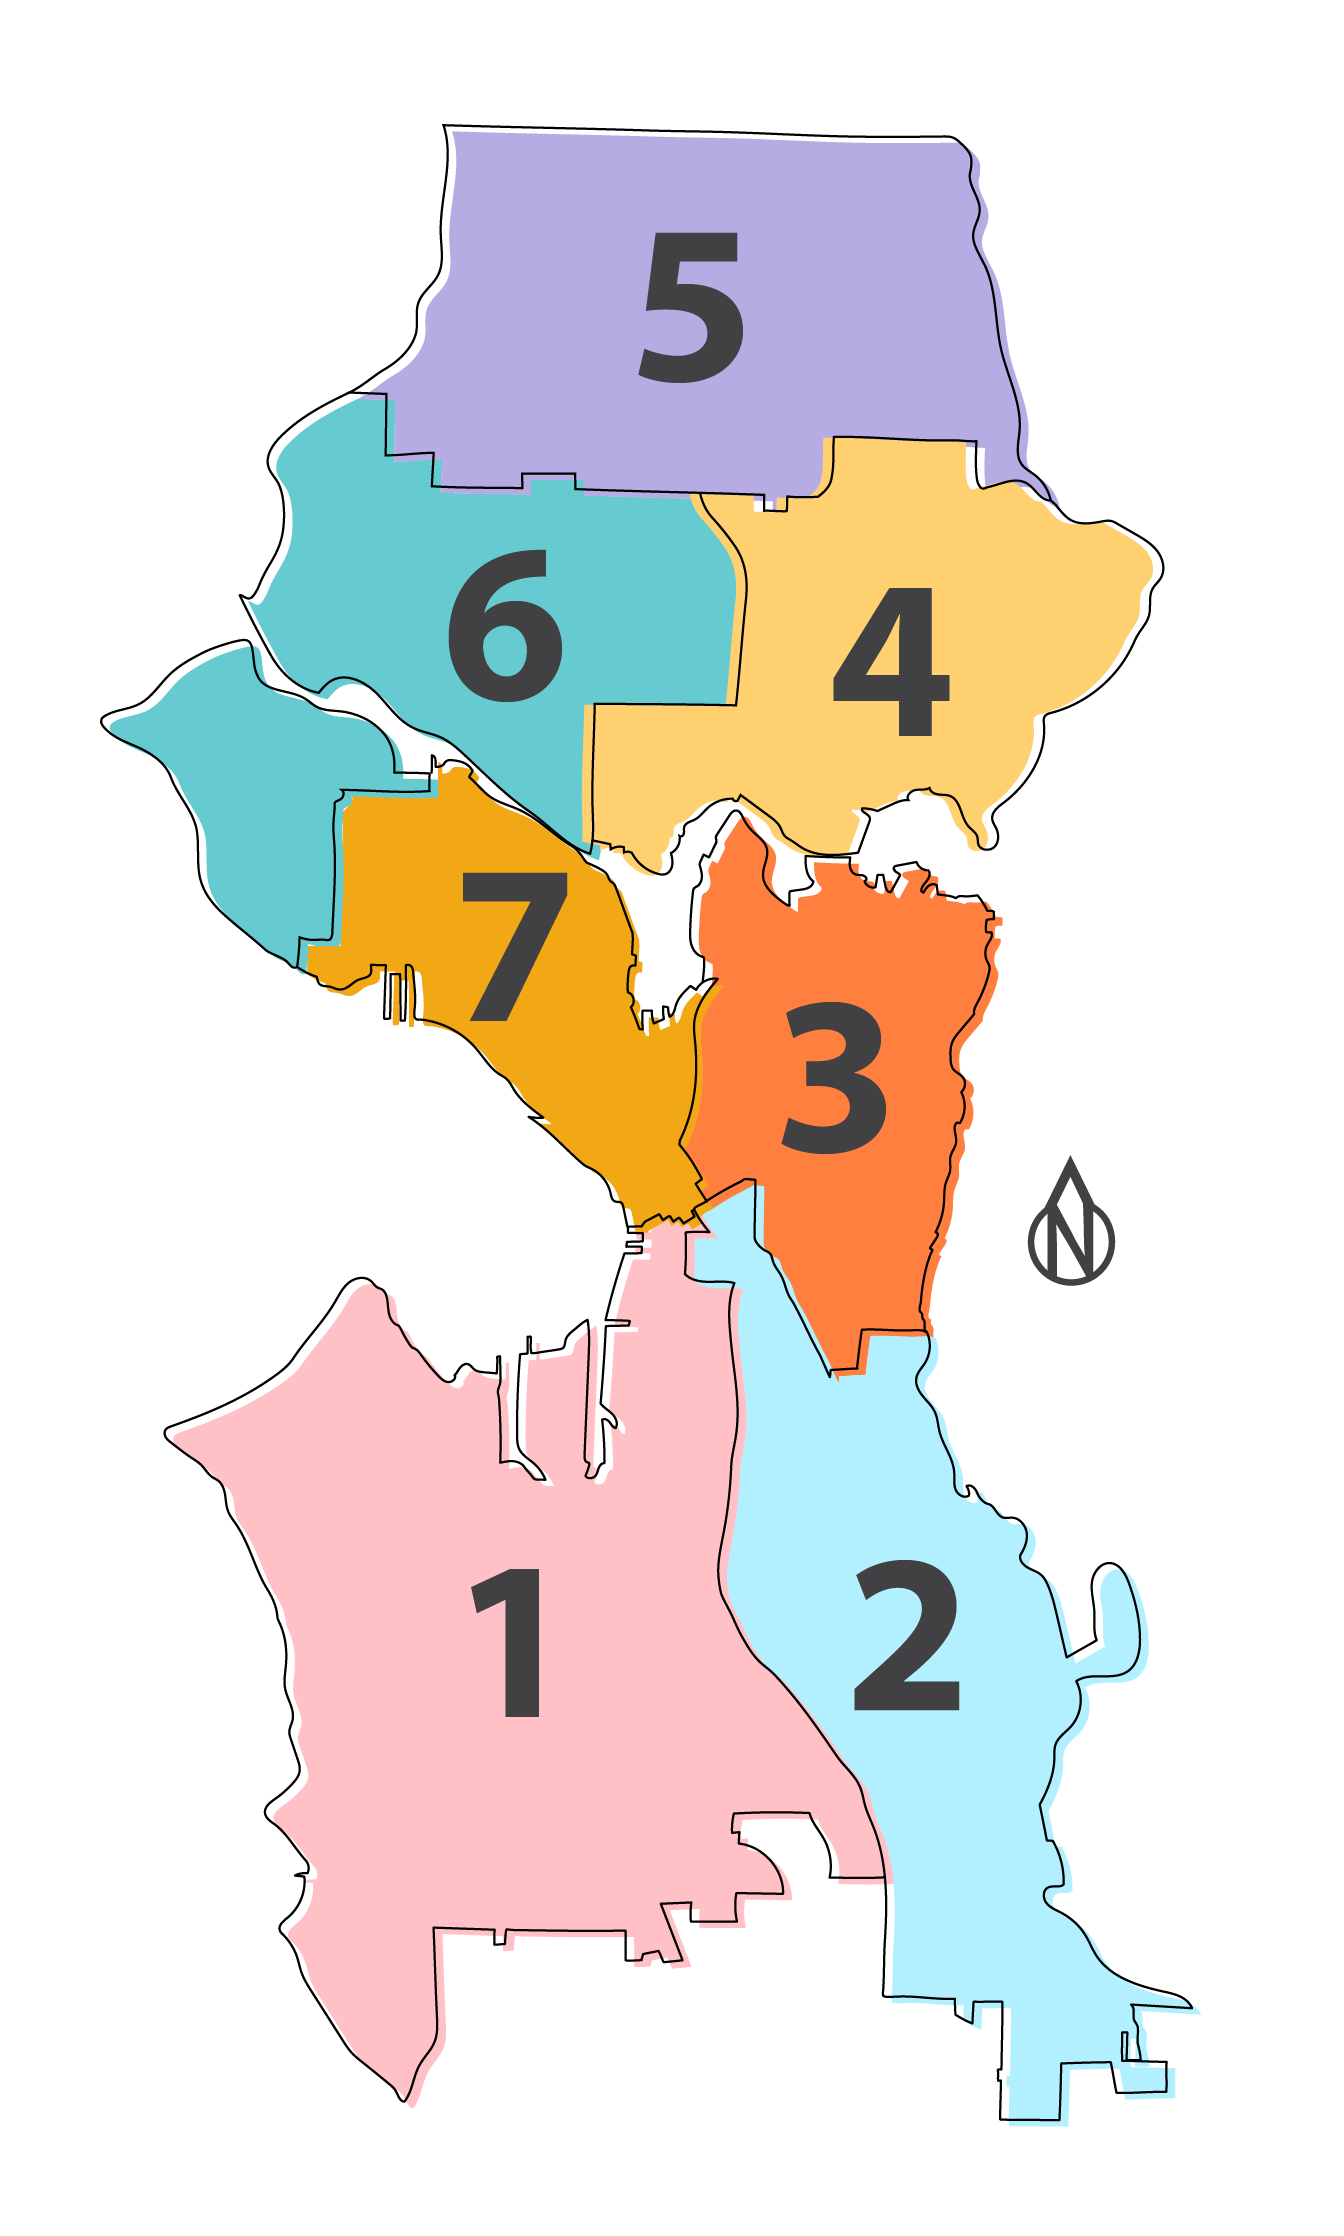

In [152]:
# Afficher les district de Seattle
Image(filename="Council District Map - 2024 - FULL.png", width=300, height=100)

In [153]:
# Création d'un DataFrame regroupé par le code postal avec la moyenne de SiteEUIWN_kBtu_sf
grouped_df = df.groupby('CouncilDistrictCode')['SiteEUIWN_kBtu_sf'].mean().reset_index()

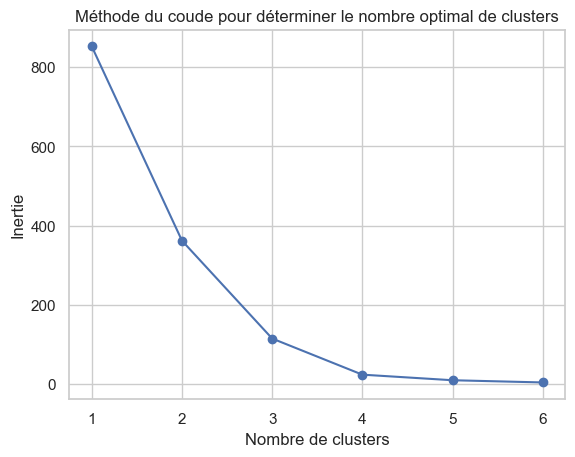

In [154]:
# Application de K-Means pour assigner chaque code postal à un seul cluster
X = grouped_df[['SiteEUIWN_kBtu_sf']]
# Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracé du graphique de la méthode du coude
plt.plot(range(1, 7), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

In [155]:
# Application de K-Means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
grouped_df['Cluster'] = kmeans.fit_predict(X)

# Affichage des résultats
grouped_df_sorted = grouped_df.sort_values(by='Cluster')
grouped_df_sorted

CouncilDistrictCode  SiteEUIWN_kBtu_sf  Cluster
0                    1          81.077922        0
2                    3          84.029730        0
3                    4          94.749334        0
4                    5          73.977381        0
5                    6          70.635211        0
6                    7          77.957915        0
1                    2          56.490365        1

In [156]:
# Test avec un regroupement de catégories
def group_districts(code):
    cluster_mapping = {
        0: 'A',
        1: 'B'
    }
    cluster = grouped_df_sorted.loc[grouped_df_sorted['CouncilDistrictCode'] == code, 'Cluster'].iloc[0]
    return cluster_mapping.get(cluster, 'B')

df['GroupedDistrict'] = df['CouncilDistrictCode'].apply(group_districts)

In [157]:
perform_anova_tukey(df, 'SiteEUIWN_kBtu_sf', 'GroupedDistrict')

ANOVA Table for SiteEUIWN_kBtu_sf by GroupedDistrict:
                          sum_sq     df          F    PR(>F)
C(GroupedDistrict)  1.142489e+05    1.0  20.531536  0.000007
Residual            5.431009e+06  976.0        NaN       NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by GroupedDistrict:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B -23.4163   0.0 -33.5576 -13.275   True
----------------------------------------------------


=> bon résultat avec 2 groupes

In [158]:
perform_anova_tukey(df, 'GHGEmissionsIntensity', 'GroupedDistrict')

ANOVA Table for GHGEmissionsIntensity by GroupedDistrict:
                         sum_sq     df          F        PR(>F)
C(GroupedDistrict)   124.990911    1.0  26.783878  2.761852e-07
Residual            4554.647739  976.0        NaN           NaN



Tukey's HSD Results for GHGEmissionsIntensity by GroupedDistrict:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     A      B  -0.7745   0.0 -1.0682 -0.4808   True
---------------------------------------------------


=> bon résultat avec 2 groupes

### Neighborhood

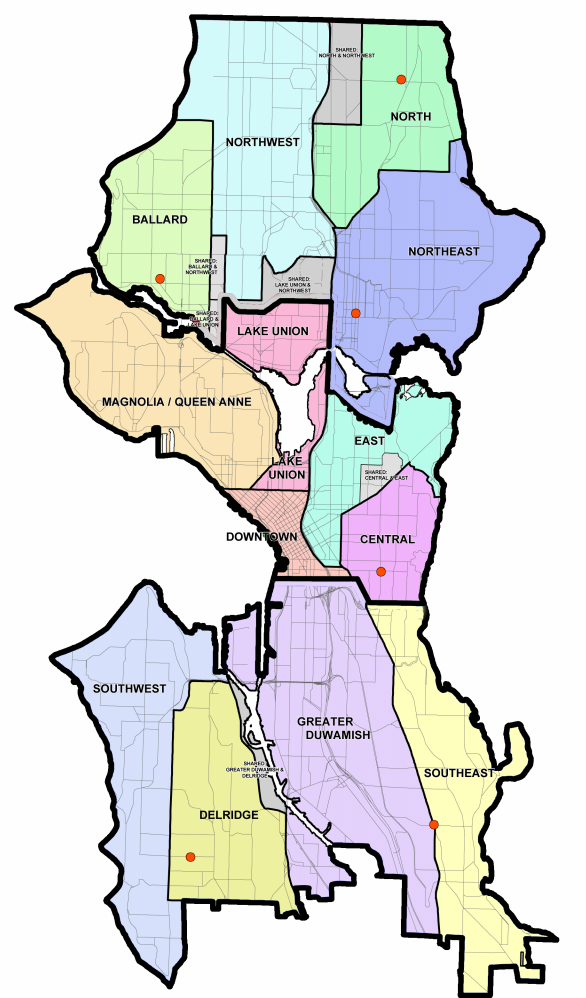

In [159]:
# Afficher les quartiers de Seattle
Image(filename="Map_of_Seattle,_divided_by_districts.png", width=400, height=150)

In [160]:
# Création d'un DataFrame regroupé par Neighborhood avec la moyenne de SiteEUIWN_kBtu_sf
grouped_df = df.groupby('Neighborhood')['SiteEUIWN_kBtu_sf'].mean().reset_index()

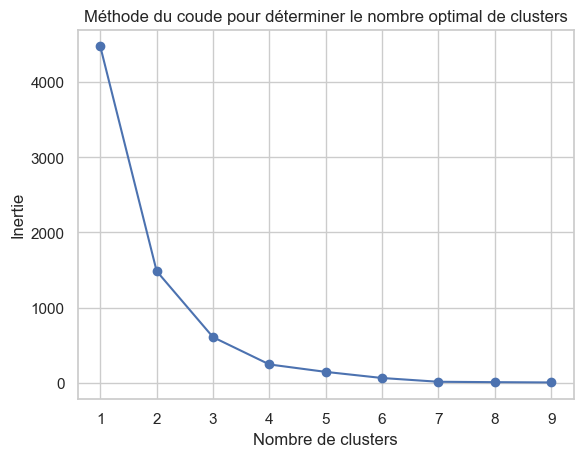

In [161]:
# Application de K-Means pour assigner chaque code postal à un seul cluster
X = grouped_df[['SiteEUIWN_kBtu_sf']]
# Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracé du graphique de la méthode du coude
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

In [162]:
# Application de K-Means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
grouped_df['Cluster'] = kmeans.fit_predict(X)

# Affichage des résultats
grouped_df_sorted = grouped_df.sort_values(by='Cluster')
grouped_df_sorted

Neighborhood  SiteEUIWN_kBtu_sf  Cluster
0                 BALLARD          73.986539        0
1                 CENTRAL          75.700000        0
3                DOWNTOWN          72.935638        0
6              LAKE UNION          82.813334        0
7   MAGNOLIA / QUEEN ANNE          81.433721        0
10              NORTHWEST          79.733333        0
11              SOUTHEAST          72.278261        0
12              SOUTHWEST         132.271429        1
2                DELRIDGE          64.568965        2
5        GREATER DUWAMISH          54.322776        2
8                   NORTH          65.972728        2
4                    EAST          89.503279        3
9               NORTHEAST          99.670493        3

In [170]:
# Test avec un regroupement de catégories
def group_neighbor(code):
    cluster_mapping = {
        0: 'A',
        1: 'B',
        2: 'C',
        3: 'B'
    }
    cluster = grouped_df_sorted.loc[grouped_df_sorted['Neighborhood'] == code, 'Cluster'].iloc[0]
    return cluster_mapping.get(cluster, 'C')

df['GroupedNeighborhood'] = df['Neighborhood'].apply(group_neighbor)

In [171]:
perform_anova_tukey(df, 'SiteEUIWN_kBtu_sf', 'GroupedNeighborhood')

ANOVA Table for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
                              sum_sq     df          F        PR(>F)
C(GroupedNeighborhood)  2.057133e+05    2.0  18.781609  9.918665e-09
Residual                5.339545e+06  975.0        NaN           NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B   23.732 0.0023   7.1869 40.2771   True
     A      C -19.7788 0.0004 -31.9431 -7.6145   True
     B      C -43.5108    0.0 -60.7226 -26.299   True
-----------------------------------------------------


In [172]:
perform_anova_tukey(df, 'GHGEmissionsIntensity', 'GroupedNeighborhood')

ANOVA Table for GHGEmissionsIntensity by GroupedNeighborhood:
                             sum_sq     df          F        PR(>F)
C(GroupedNeighborhood)   221.648623    2.0  24.238211  5.330918e-11
Residual                4457.990028  975.0        NaN           NaN



Tukey's HSD Results for GHGEmissionsIntensity by GroupedNeighborhood:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B    0.856 0.0001  0.3779  1.3341   True
     A      C  -0.5936 0.0002 -0.9451 -0.2421   True
     B      C  -1.4496    0.0 -1.9469 -0.9523   True
----------------------------------------------------


=> on a 3 groupes bien définis pour les conso et les emissions.

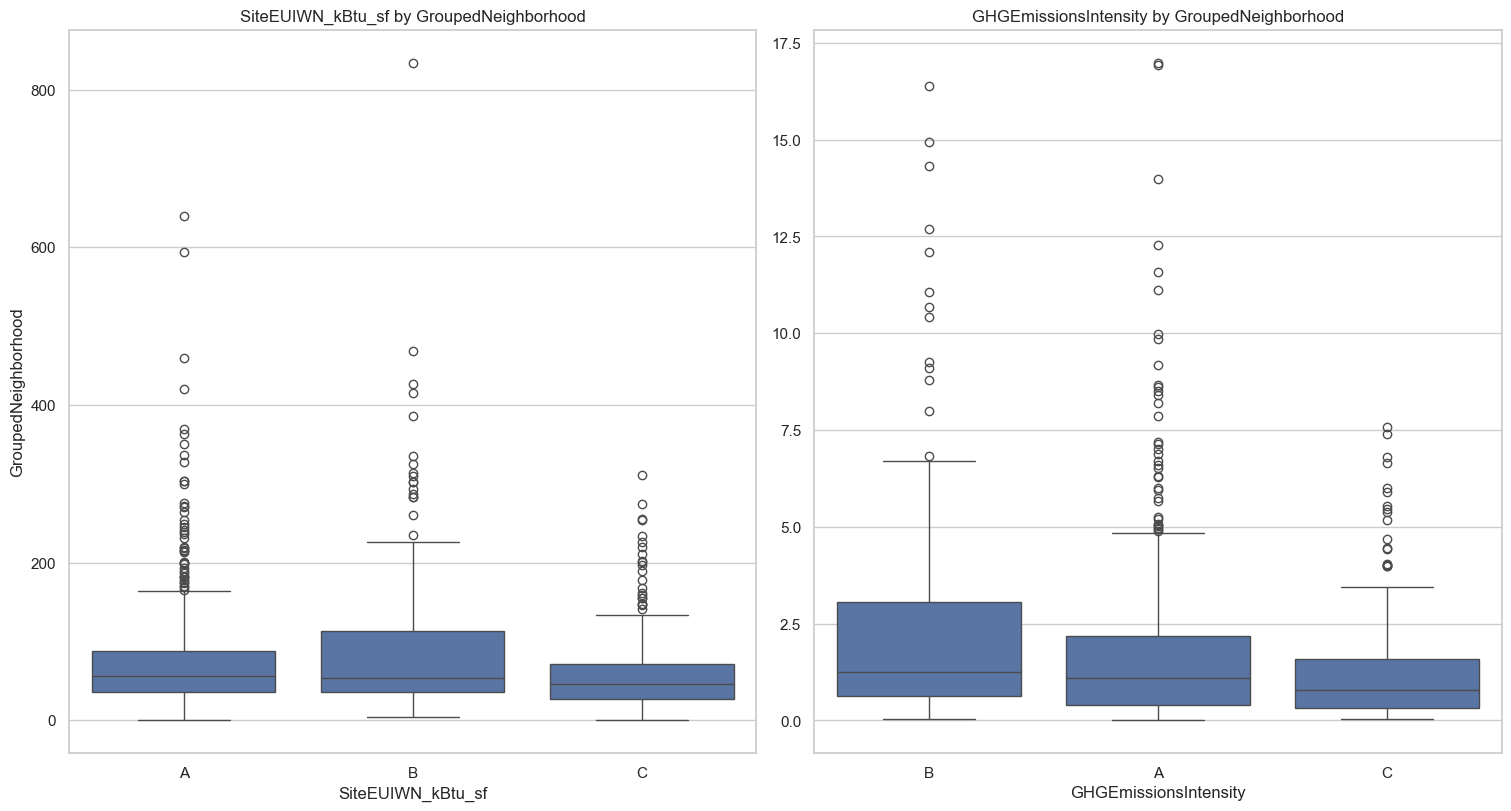

In [173]:
# 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
sns.set(style="whitegrid")

# Orderby median de SiteEnergyUseWN(kBtu)
order_energy = df.groupby('GroupedNeighborhood')['SiteEUIWN_kBtu_sf'].median().sort_values(ascending=False).index
# SiteEnergyUseWN(kBtu) boxplot
sns.boxplot(y='SiteEUIWN_kBtu_sf', x='GroupedNeighborhood', data=df, ax=axes[0], order=order_energy)
axes[0].set_title(f'SiteEUIWN_kBtu_sf by GroupedNeighborhood')
axes[0].set_xlabel('SiteEUIWN_kBtu_sf')
axes[0].set_ylabel('GroupedNeighborhood')

# Orderby median de  TotalGHGEmissions
order_ghg = df.groupby('GroupedNeighborhood')['GHGEmissionsIntensity'].median().sort_values(ascending=False).index
# TotalGHGEmissions boxplot
sns.boxplot(y='GHGEmissionsIntensity', x='GroupedNeighborhood', data=df, ax=axes[1], order=order_ghg)
axes[1].set_title(f'GHGEmissionsIntensity by GroupedNeighborhood')
axes[1].set_xlabel('GHGEmissionsIntensity')
axes[1].set_ylabel('')

#plt.tight_layout()
plt.show()

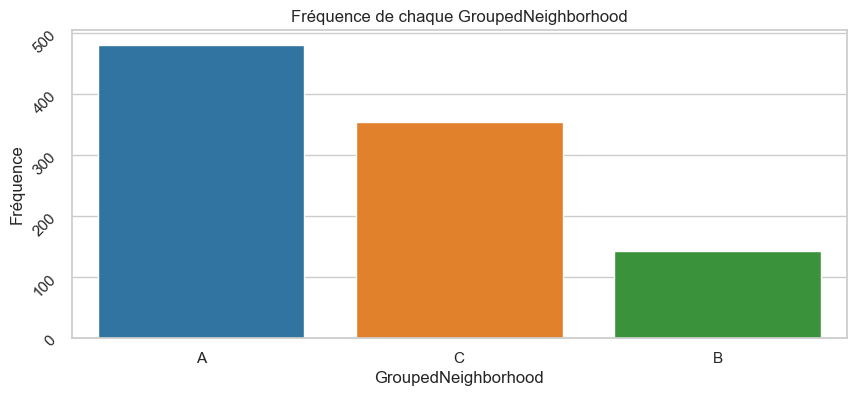

In [175]:
# Compter le nombre d'occurrences pour chaque GroupedNeighborhood
group_counts = df['GroupedNeighborhood'].value_counts().reset_index()
group_counts.columns = ['GroupedNeighborhood', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='GroupedNeighborhood', y='Counts', data=group_counts, hue='GroupedNeighborhood', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque GroupedNeighborhood')
plt.ylabel('Fréquence')
plt.xlabel('GroupedNeighborhood')

plt.show()

### ZipCode

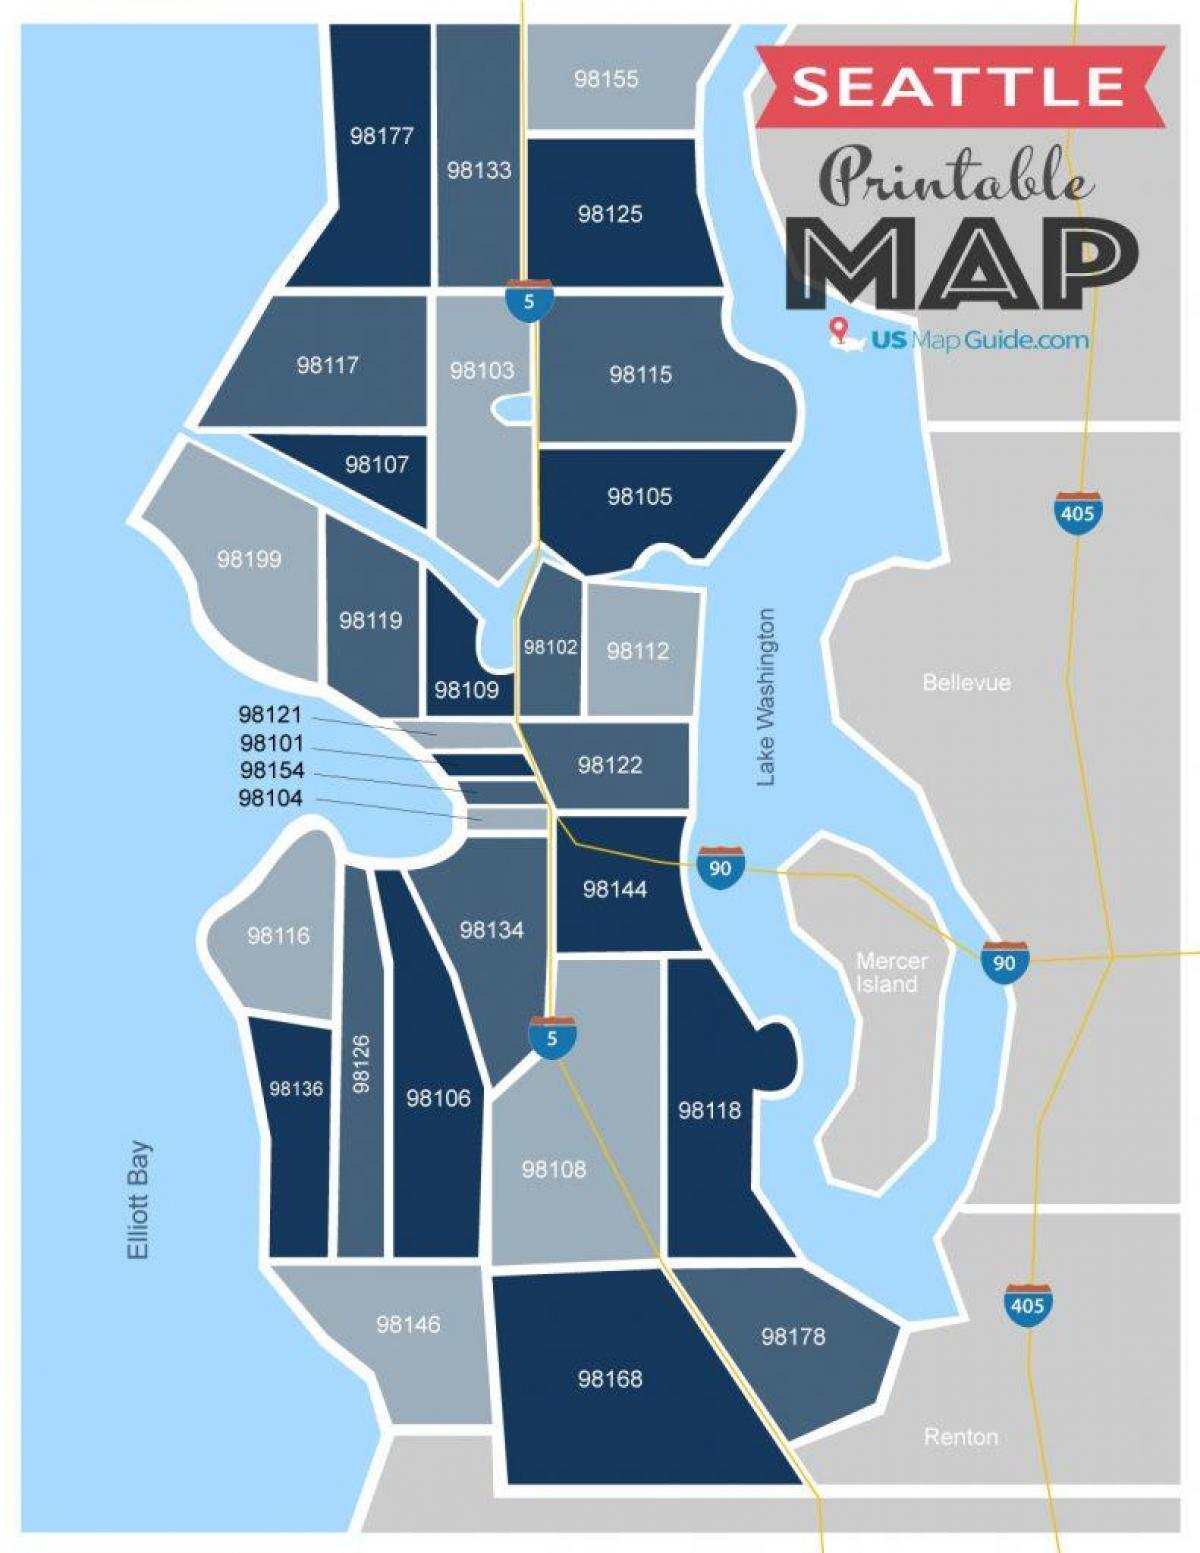

In [176]:
# Afficher les ZipCode de Seattle
Image(filename="plan-codes-postaux -seattle.jpg", width=600, height=600)

In [177]:
# Création d'un DataFrame regroupé par le code postal avec la moyenne de SiteEUIWN_kBtu_sf
grouped_df = df.groupby('ZipCode')['SiteEUIWN_kBtu_sf'].mean().reset_index()

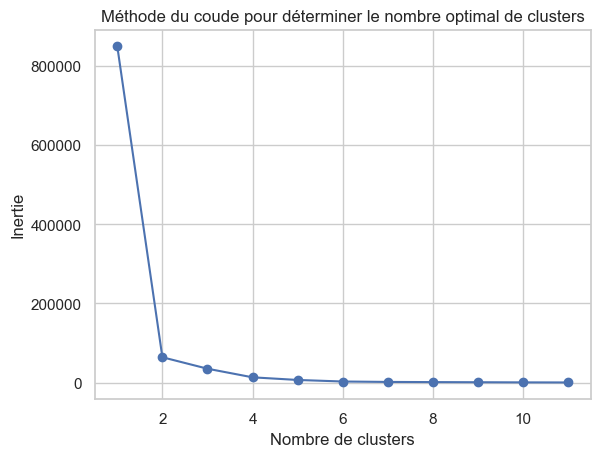

In [178]:
# Application de K-Means pour assigner chaque code postal à un seul cluster
X = grouped_df[['SiteEUIWN_kBtu_sf']]
# Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracé du graphique de la méthode du coude
plt.plot(range(1, 12), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

In [179]:
# Application de K-Means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
grouped_df['Cluster'] = kmeans.fit_predict(X)

# Affichage des résultats
grouped_df_sorted = grouped_df.sort_values(by='Cluster')
grouped_df_sorted

ZipCode  SiteEUIWN_kBtu_sf  Cluster
0   98011.0         100.400002        0
31  98155.0          95.633334        0
28  98136.0         115.574998        0
26  98133.0          76.889655        0
25  98126.0          90.346154        0
21  98121.0          77.938889        0
20  98119.0          80.925000        0
18  98117.0          78.842856        0
17  98116.0         134.730770        0
15  98113.0          83.500000        0
14  98112.0         117.284615        0
12  98109.0          88.219643        0
19  98118.0          89.476000        0
8   98105.0          99.726316        0
5   98102.0          99.875000        0
4   98101.0          91.233766        0
2   98020.0         138.600006        0
36  98185.0         834.400024        1
1   98013.0         593.599976        2
13  98111.0          69.800003        3
37  98191.0          62.400002        3
35  98181.0          19.900000        3
34  98177.0          44.400002        3
33  98168.0          43.049999        3
32  98165.0           5.300000        3
30  98146.0          24.200001        3
29  98144.0          56.265625        3
3   98053.0           6.900000        3
11  98108.0          50.766346        3
24  98125.0          61.921212        3
23  98124.0          53.750000        3
22  98122.0          57.105454        3
6   98103.0          54.588235        3
38  98195.0          54.700001        3
7   98104.0          67.161628        3
16  98115.0          71.416667        3
9   98106.0          63.878571        3
10  98107.0          68.011429        3
27  98134.0          54.948252        3
39  98199.0          48.575000        3

In [188]:
# Test avec un regroupement de catégories
# Définir une fonction pour regrouper les CouncilDistrictCodes
def group_Zip(code):
    if code in[98185]:
        return 'A'
    elif code in[98013]:
        return 'A'
    elif code in[
        98011.0, 98155.0, 98136.0, 98133.0, 98126.0, 98121.0, 98119.0, 98117.0, 98116.0, 98113.0,
        98112.0, 98109.0, 98118.0, 98105.0, 98102.0, 98101.0, 98020.0]:
        return 'B'
    else:
        return 'C'


df['GroupedZip'] = df['ZipCode'].apply(group_Zip)

In [189]:
perform_anova_tukey(df, 'Log_SiteEnergyUseWN', 'GroupedZip')

ANOVA Table for Log_SiteEnergyUseWN by GroupedZip:
                    sum_sq     df          F        PR(>F)
C(GroupedZip)    66.804085    2.0  23.414466  1.169176e-10
Residual       1390.891902  975.0        NaN           NaN



Tukey's HSD Results for Log_SiteEnergyUseWN by GroupedZip:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B  -2.2146 0.0246 -4.2024 -0.2268   True
     A      C  -2.7007 0.0042 -4.6864  -0.715   True
     B      C   -0.486    0.0 -0.6712 -0.3009   True
----------------------------------------------------


In [190]:
perform_anova_tukey(df, 'GHGEmissionsIntensity', 'GroupedZip')

ANOVA Table for GHGEmissionsIntensity by GroupedZip:
                    sum_sq     df          F        PR(>F)
C(GroupedZip)   273.686084    2.0  30.282207  1.741427e-13
Residual       4405.952567  975.0        NaN           NaN



Tukey's HSD Results for GHGEmissionsIntensity by GroupedZip:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -6.4759 0.0001 -10.0138  -2.938   True
     A      C  -7.3504    0.0 -10.8845 -3.8162   True
     B      C  -0.8745    0.0   -1.204 -0.5449   True
-----------------------------------------------------


=> on a 3 groupes bien définis pour les conso et les emissions.

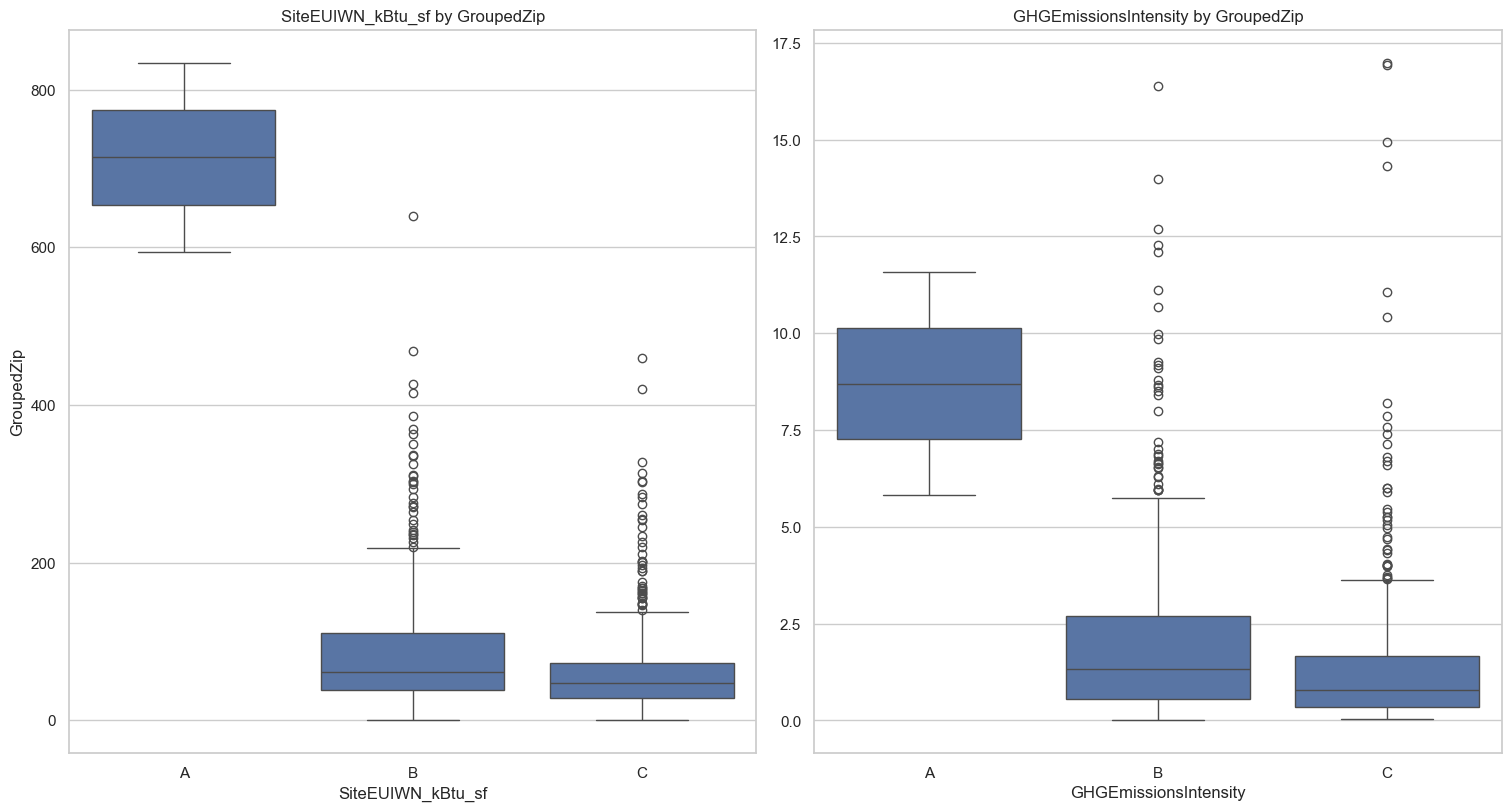

In [191]:
# 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
sns.set(style="whitegrid")

# Orderby median de SiteEnergyUseWN(kBtu)
order_energy = df.groupby('GroupedZip')['SiteEUIWN_kBtu_sf'].median().sort_values(ascending=False).index
# SiteEnergyUseWN(kBtu) boxplot
sns.boxplot(y='SiteEUIWN_kBtu_sf', x='GroupedZip', data=df, ax=axes[0], order=order_energy)
axes[0].set_title(f'SiteEUIWN_kBtu_sf by GroupedZip')
axes[0].set_xlabel('SiteEUIWN_kBtu_sf')
axes[0].set_ylabel('GroupedZip')

# Orderby median de  TotalGHGEmissions
order_ghg = df.groupby('GroupedZip')['GHGEmissionsIntensity'].median().sort_values(ascending=False).index
# TotalGHGEmissions boxplot
sns.boxplot(y='GHGEmissionsIntensity', x='GroupedZip', data=df, ax=axes[1], order=order_ghg)
axes[1].set_title(f'GHGEmissionsIntensity by GroupedZip')
axes[1].set_xlabel('GHGEmissionsIntensity')
axes[1].set_ylabel('')

#plt.tight_layout()
plt.show()

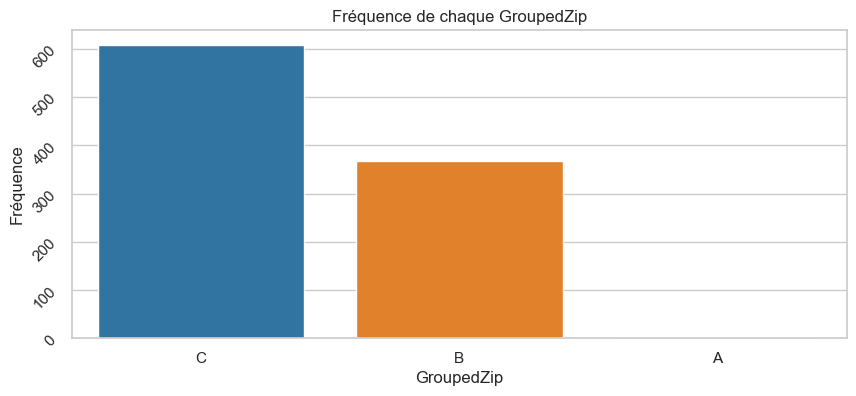

In [192]:
# Compter le nombre d'occurrences pour chaque GroupedNeighborhood
group_counts = df['GroupedZip'].value_counts().reset_index()
group_counts.columns = ['GroupedZip', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='GroupedZip', y='Counts', data=group_counts, hue='GroupedZip', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque GroupedZip')
plt.ylabel('Fréquence')
plt.xlabel('GroupedZip')

plt.show()

Les CouncilDistrictCode, Neighborhood et ZipCode étant 3 indicateurs géographiques, nous en choississons 1 seul, le Neighborhood regroupé en 3 catégories et dont la répartition des fréquence est plus harmonieuse.

In [230]:
# Créez un tableau croisé des deux variables
cross_table = pd.crosstab(df['GroupedNeighborhood'], df['SiteEUIWN_kBtu_sf'])

# Effectuez le test du chi-carré
chi2, p, _, _ = chi2_contingency(cross_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

Chi-squared value: 1407.7546248453027
P-value: 0.2573931580047775


### PropertyUseType

In [231]:
# Creation d'un df pour isoler les valeurs les plus pertinantes
df_high_gfa_pct = df[df['LargestPropertyUseTypeGFA_pct'] >= 75]
df_high_gfa_pct.shape

(800, 31)

In [233]:
# Création d'une nouvelle colonne pour le produit de LargestPropertyUseTypeGFA_pct et SiteEUIWN_kBtu_sf
df_high_gfa_pct = df_high_gfa_pct.copy()
df_high_gfa_pct['GFA_pct_EUI_Product'] = df_high_gfa_pct['LargestPropertyUseTypeGFA_pct'] * df_high_gfa_pct['SiteEUIWN_kBtu_sf']

In [234]:
# Création d'un DataFrame regroupé par le LargestPropertyUseTypeGFA avec la moyenne de Log_SiteEnergyUseWN
grouped_df = df_high_gfa_pct.groupby('LargestPropertyUseType')['GFA_pct_EUI_Product'].mean().reset_index()

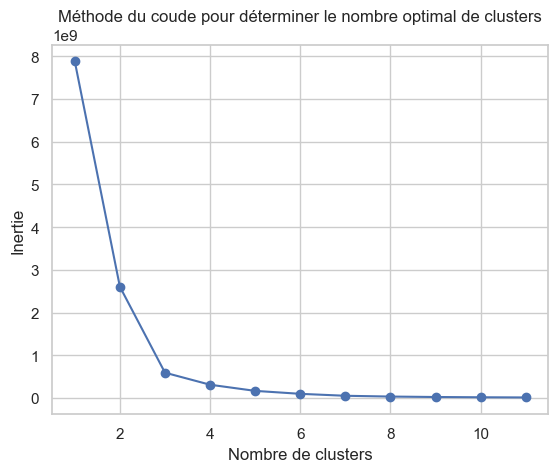

In [236]:
# Application de K-Means pour assigner chaque LargestPropertyUseType à un seul cluster
X = grouped_df[['GFA_pct_EUI_Product']]
# Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracé du graphique de la méthode du coude
plt.plot(range(1, 12), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

In [237]:
# Application de K-Means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=5, n_init=10, random_state=0)
grouped_df['Cluster'] = kmeans.fit_predict(X)

# Affichage des résultats triés par cluster
grouped_df_sorted = grouped_df.sort_values(by='Cluster')
grouped_df_sorted

LargestPropertyUseType  GFA_pct_EUI_Product  \
22              Other - Entertainment/Public Assembly          7868.588638   
15                     Manufacturing/Industrial Plant         10971.428503   
35                          Residential Care Facility          8919.999695   
30  Personal Services (Health/Beauty, Dry Cleaning...          9780.000305   
11                                              Hotel          8341.676794   
21                                              Other          9520.741729   
9                      Fitness Center/Health Club/Gym          8380.000305   
16                                     Medical Office          7699.914988   
8                                        Fire Station          8619.999695   
39                              Senior Care Community         10666.363698   
4                                          Courthouse          8750.000000   
32                               Prison/Incarceration          7243.333435   
41                                         Strip Mall         12113.333386   
24                            Other - Public Services          9074.999998   
17                                      Movie Theater          8350.000000   
5                                         Data Center         83440.002440   
18                                             Museum         26500.000765   
43                Urgent Care/Clinic/Other Outpatient         35809.999339   
13                                         Laboratory         26802.867976   
10              Hospital (General Medical & Surgical)         26900.000765   
42                          Supermarket/Grocery Store         25828.325874   
34    Repair Services (Vehicle, Shoe, Locksmith, etc)          5533.197604   
33                             Refrigerated Warehouse          6737.942857   
38                              Self-Storage Facility          2101.128569   
40                                Social/Meeting Hall          5900.427147   
31                                 Pre-school/Daycare          5620.000076   
37                                       Retail Store          6410.206991   
29                                    Performing Arts          4645.000077   
0                                     Adult Education          6524.999809   
27                                    Other - Utility          3621.828864   
26                                   Other - Services           640.000010   
23                                       Other - Mall          1946.324475   
20                                             Office          5671.896442   
19                         Non-Refrigerated Warehouse          3389.818642   
12                                        K-12 School          4157.755101   
7                                    Financial Office          6598.102946   
6                                 Distribution Center          3932.768410   
3                                  College/University          6518.505413   
2                                         Bank Branch          5860.000039   
1                               Automobile Dealership          5080.011659   
44                                   Worship Facility          3539.270680   
25                                 Other - Recreation         14130.935287   
14                                   Lifestyle Center         16419.999690   
36                                         Restaurant         19288.466079   
28                           Other/Specialty Hospital         17149.999492   

    Cluster  
22        0  
15        0  
35        0  
30        0  
11        0  
21        0  
9         0  
16        0  
8         0  
39        0  
4         0  
32        0  
41        0  
24        0  
17        0  
5         1  
18        2  
43        2  
13        2  
10        2  
42        2  
34        3  
33        3  
38        3  
40        3  
31        3  
37        3  
29        3  
0         3  
27        3  
26      

In [268]:
def group_LargType(code):
    # Si le code n'existe pas dans grouped_df_sorted, classer comme 'D'
    if not grouped_df_sorted['LargestPropertyUseType'].isin([code]).any():
        return 'D'
    
    # Sinon, procéder avec le regroupement original
    cluster_mapping = {
        0: 'C',
        1: 'A',
        2: 'A',
        3: 'D',
        4: 'B'
    }
    try:
        cluster = grouped_df_sorted.loc[grouped_df_sorted['LargestPropertyUseType'] == code, 'Cluster'].iloc[0]
        return cluster_mapping.get(cluster, 'E')
    except IndexError:
        return 'D'

df['GroupedLargType'] = df['LargestPropertyUseType'].apply(group_LargType)


In [327]:
df_feat = df.copy()
df_feat['GFA_pct_EUI_Product'] = df_feat['LargestPropertyUseTypeGFA_pct'] * df_feat['SiteEUIWN_kBtu_sf']

In [328]:
perform_anova_tukey(df_feat, 'GFA_pct_EUI_Product', 'GroupedLargType')

ANOVA Table for GFA_pct_EUI_Product by GroupedLargType:
                          sum_sq     df           F         PR(>F)
C(GroupedLargType)  2.284610e+10    3.0  299.786949  7.929797e-138
Residual            2.474213e+10  974.0         NaN            NaN



Tukey's HSD Results for GFA_pct_EUI_Product by GroupedLargType:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------
     A      B -13383.5051   0.0 -16261.9525 -10505.0578   True
     A      C -17746.8422   0.0 -19929.5895  -15564.095   True
     A      D -21821.0076   0.0 -23813.0896 -19828.9257   True
     B      C  -4363.3371   0.0  -6723.9986  -2002.6755   True
     B      D  -8437.5025   0.0 -10623.0752  -6251.9298   True
     C      D  -4074.1654   0.0  -5194.7252  -2953.6056   True
--------------------------------------------------------------


In [329]:
df_feat['GFA_pct_GHG_Product'] = df_feat['LargestPropertyUseTypeGFA_pct'] * df_feat['GHGEmissionsIntensity']

In [330]:
perform_anova_tukey(df_feat, 'GFA_pct_GHG_Product', 'GroupedLargType')

ANOVA Table for GFA_pct_GHG_Product by GroupedLargType:
                          sum_sq     df           F         PR(>F)
C(GroupedLargType)  1.524934e+07    3.0  208.076718  2.811654e-104
Residual            2.379388e+07  974.0         NaN            NaN



Tukey's HSD Results for GFA_pct_GHG_Product by GroupedLargType:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     A      B -188.9651   0.0 -278.2283  -99.7019   True
     A      C  -401.643   0.0 -469.3319  -333.954   True
     A      D -517.9158   0.0  -579.692 -456.1396   True
     B      C -212.6778   0.0  -285.884 -139.4717   True
     B      D -328.9507   0.0 -396.7272 -261.1742   True
     C      D -116.2728   0.0 -151.0224  -81.5233   True
--------------------------------------------------------


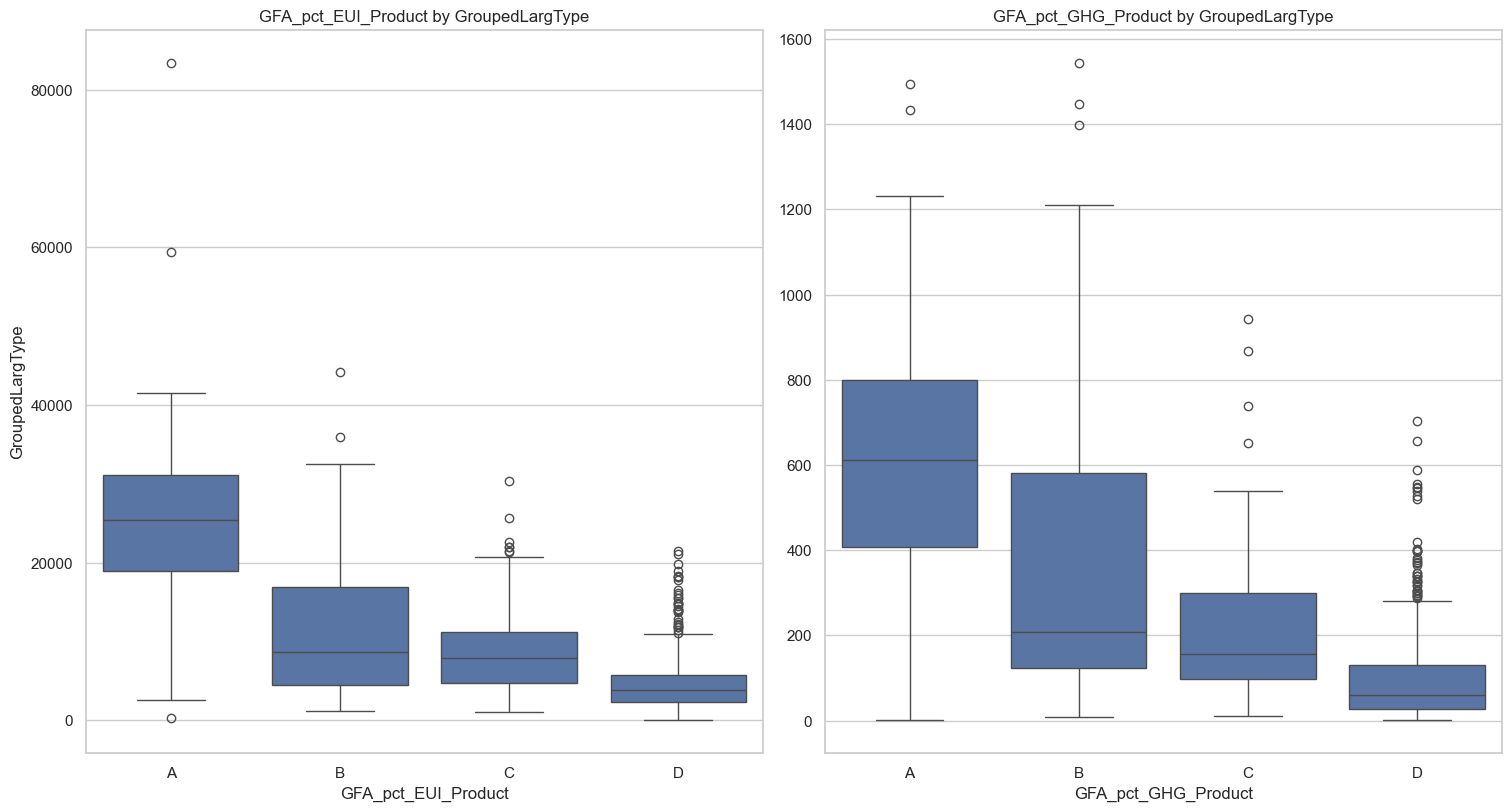

In [331]:
# 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
sns.set(style="whitegrid")

# Orderby median de SiteEnergyUseWN(kBtu)
order_energy = df_feat.groupby('GroupedLargType')['GFA_pct_EUI_Product'].median().sort_values(ascending=False).index
# SiteEnergyUseWN(kBtu) boxplot
sns.boxplot(y='GFA_pct_EUI_Product', x='GroupedLargType', data=df_feat, ax=axes[0], order=order_energy)
axes[0].set_title(f'GFA_pct_EUI_Product by GroupedLargType')
axes[0].set_xlabel('GFA_pct_EUI_Product')
axes[0].set_ylabel('GroupedLargType')

# Orderby median de  TotalGHGEmissions
order_ghg = df_feat.groupby('GroupedLargType')['GFA_pct_GHG_Product'].median().sort_values(ascending=False).index
# TotalGHGEmissions boxplot
sns.boxplot(y='GFA_pct_GHG_Product', x='GroupedLargType', data=df_feat, ax=axes[1], order=order_ghg)
axes[1].set_title(f'GFA_pct_GHG_Product by GroupedLargType')
axes[1].set_xlabel('GFA_pct_GHG_Product')
axes[1].set_ylabel('')

#plt.tight_layout()
plt.show()

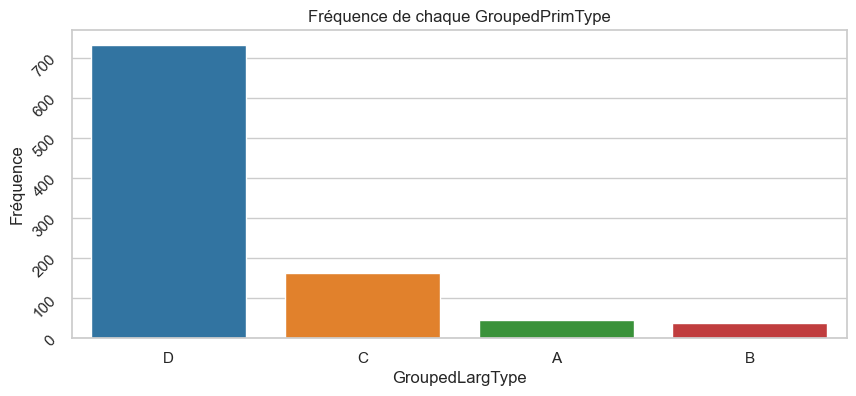

In [332]:
# Compter le nombre d'occurrences pour chaque GroupedPrimType
group_counts = df_feat['GroupedLargType'].value_counts().reset_index()
group_counts.columns = ['GroupedLargType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='GroupedLargType', y='Counts', data=group_counts, hue='GroupedLargType', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque GroupedPrimType')
plt.ylabel('Fréquence')
plt.xlabel('GroupedLargType')

plt.show()

In [333]:
df_feat[df_feat['GroupedLargType'] == 'A'].shape[0]

45

In [334]:
df_feat[df_feat['GroupedLargType'] == 'B'].shape[0]

37

In [335]:
# Créez un tableau croisé des deux variables
cross_table = pd.crosstab(df_feat['GroupedLargType'], df_feat['GFA_pct_EUI_Product'])

# Effectuez le test du chi-carré
chi2, p, _, _ = chi2_contingency(cross_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")


Chi-squared value: 2749.1687589828935
P-value: 0.001896998433468186


In [336]:
df_feat['LargestPropertyUseType'].unique()

array(['Hotel', 'Other - Entertainment/Public Assembly',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'College/University',
       'Automobile Dealership', 'K-12 School', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Senior Care Community',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Retail Store',
       'Hospital (General Medical & Surgical)',
       'Non-Refrigerated Warehouse', 'Distribution Center',
       'Worship Facility', 'Medical Office', 'Restaurant', 'Data Center',
       'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient',
       'Laboratory', 'Strip Mall', 'Refrigerated Warehouse',
       'Manufacturing/Industrial Plant', 'Lifestyle Center',
       'Other - Public Services', 'Financial Office', 'Fire Station',
       'Performing Arts', 'Other - Services', 'Other - Recreation',
       'Residential Care Facility', 'Bank Branch',
       'Other/Specialty Hospital', 'Museum', 'Other - Restaurant/Bar',
       'Adult Education',

In [337]:
df_feat['SecondLargestPropertyUseType'].unique()

array(['None', 'Restaurant', 'Non-Refrigerated Warehouse',
       'Other - Education', 'Vocational School', 'Retail Store',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Other - Entertainment/Public Assembly', 'Data Center', 'Other',
       'Residence Hall/Dormitory', 'Distribution Center',
       'Self-Storage Facility', 'Office', 'Laboratory', 'Medical Office',
       'Other - Services', 'Other - Recreation',
       'Convenience Store without Gas Station', 'College/University',
       'Supermarket/Grocery Store', 'Other - Restaurant/Bar',
       'Adult Education', 'Multifamily Housing', 'Bar/Nightclub',
       'Performing Arts', 'Other - Technology/Science',
       'Financial Office',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'K-12 School', 'Bank Branch',
       'Refrigerated Warehouse', 'Fitness Center/Health Club/Gym',
       'Hotel', 'Worship Facility', 'Food Sales',
       'Other - Public Services', 'F

In [338]:
# Trouver les éléments uniques dans second_largest qui ne sont pas dans largest
second_set = set(df_feat['SecondLargestPropertyUseType'].unique())
largest_set = set(df_feat['LargestPropertyUseType'].unique())

unique_in_second_not_in_largest = second_set - largest_set

unique_in_second_not_in_largest

{'Bar/Nightclub',
 'Convenience Store without Gas Station',
 'Food Sales',
 'Food Service',
 'Multifamily Housing',
 'None',
 'Other - Lodging/Residential',
 'Other - Technology/Science',
 'Residence Hall/Dormitory',
 'Vocational School'}

In [342]:
# Mappage des catégories SecondLargestPropertyUseType vers les catégories existantes de LargestPropertyUseType
mapping = {
    'Bar/Nightclub': 'Other - Entertainment/Public Assembly',
    'Convenience Store without Gas Station': 'Retail Store',
    'Food Sales': 'Restaurant',
    'Food Service': 'Restaurant',
    'Other - Lodging/Residential': 'Hotel',
    'Other - Technology/Science': 'Office', 
    'Residence Hall/Dormitory': 'College/University',
    'Vocational School': 'Other - Education'
}

# Application du mappage
df_feat['SecondLargestPropertyUseType'] = df_feat['SecondLargestPropertyUseType'].map(mapping).fillna(df_feat['SecondLargestPropertyUseType'])


In [343]:
df_feat['GroupedSecondLargType'] = df_feat['SecondLargestPropertyUseType'].apply(group_LargType)

In [346]:
# Trouver les éléments uniques dans thirdlargest qui ne sont pas dans largest
third_set = set(df_feat['ThirdLargestPropertyUseType'].unique())
largest_set = set(df_feat['LargestPropertyUseType'].unique())

unique_in_third_not_in_largest = third_set - largest_set

unique_in_third_not_in_largest

{'Fast Food Restaurant', 'Food Service', 'Multifamily Housing', 'None'}

In [347]:
# Mappage des catégories ThirdLargestPropertyUseType vers les catégories existantes de LargestPropertyUseType
mapping = {
    'Fast Food Restaurant': 'Restaurant',
    'Food Service': 'Restaurant',
}

# Application du mappage
df_feat['ThirdLargestPropertyUseType'] = df_feat['ThirdLargestPropertyUseType'].map(mapping).fillna(df_feat['ThirdLargestPropertyUseType'])


In [348]:
df_feat['GroupedThirdLargType'] = df_feat['ThirdLargestPropertyUseType'].apply(group_LargType)

In [349]:
df_feat.head(2)

BuildingType  ZipCode  CouncilDistrictCode Neighborhood  Latitude  \
0  NonResidential  98101.0                    7     DOWNTOWN  47.61220   
1  NonResidential  98101.0                    7     DOWNTOWN  47.61317   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   

  LargestPropertyUseType SecondLargestPropertyUseType  \
0                  Hotel                         None   
1                  Hotel                   Restaurant   

  ThirdLargestPropertyUseType  ENERGYSTARScore  SiteEUIWN_kBtu_sf  \
0                        None             60.0          84.300003   
1                        None             61.0          97.900002   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  \
0              7456910.0             249.98                   2.83   
1              8664479.0             295.86                   2.86   

   BuildingAge  LargestPropertyUseTypeGFA_pct  \
0           89                     100.000000   
1           20                      80.991831   

   SecondLargestPropertyUseTypeGFA_pct  ThirdLargestPropertyUseTypeGFA_pct  \
0                             0.000000                                 0.0   
1                             4.462855                                 0.0   

   PropertyGFAParking_pct  SteamUse_pct  Electricity_pct  NaturalGas_pct  \
0                0.000000      26.87282        52.917723        17.11772   
1               14.545314       0.00000        37.426959        59.38132   

   Log_TotalGHGEmissions  Log_SiteEnergyUseWN GroupedDistrict  \
0               5.521381            15.824652               A   
1               5.689886            15.974742               A   

  GroupedNeighborhood GroupedZip GroupedLargType  GFA_pct_EUI_Product  \
0                   A          B               C          8430.000305   
1                   A          B               C          7929.100408   

   GFA_pct_GHG_Product GroupedSecondLargType GroupedThirdLargType  
0           283.000000                     D                    D  
1           231.636638                     B                    D

# Export des données

In [356]:
df_featured = df_feat[['Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseTypeGFA_pct', 'SecondLargestPropertyUseTypeGFA_pct', 'ThirdLargestPropertyUseTypeGFA_pct',
       'BuildingAge', 'GroupedNeighborhood', 'GroupedLargType', 'GroupedSecondLargType', 'GroupedThirdLargType',
       'SteamUse_pct', 'Electricity_pct', 'NaturalGas_pct', 'ENERGYSTARScore']]
df_featured.head(2)

Log_TotalGHGEmissions  Log_SiteEnergyUseWN  NumberofBuildings  \
0               5.521381            15.824652                1.0   
1               5.689886            15.974742                1.0   

   NumberofFloors  PropertyGFATotal  LargestPropertyUseTypeGFA_pct  \
0              12             88434                     100.000000   
1              11            103566                      80.991831   

   SecondLargestPropertyUseTypeGFA_pct  ThirdLargestPropertyUseTypeGFA_pct  \
0                             0.000000                                 0.0   
1                             4.462855                                 0.0   

   BuildingAge GroupedNeighborhood GroupedLargType GroupedSecondLargType  \
0           89                   A               C                     D   
1           20                   A               C                     B   

  GroupedThirdLargType  SteamUse_pct  Electricity_pct  NaturalGas_pct  \
0                    D      26.87282        52.917723        17.11772   
1                    D       0.00000        37.426959        59.38132   

   ENERGYSTARScore  
0             60.0  
1             61.0

In [357]:
df_featured.shape

(978, 17)

In [358]:
path     = "data/cleaned/"
filename = "df_cleaned.csv"

In [359]:
df_featured.to_csv(path+filename, index=False)

In [354]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df_featured.copy()

# Sélectionner uniquement les colonnes numériques
numerics_col = df_featured.select_dtypes(include=['number']).columns

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df_featured[numerics_col])

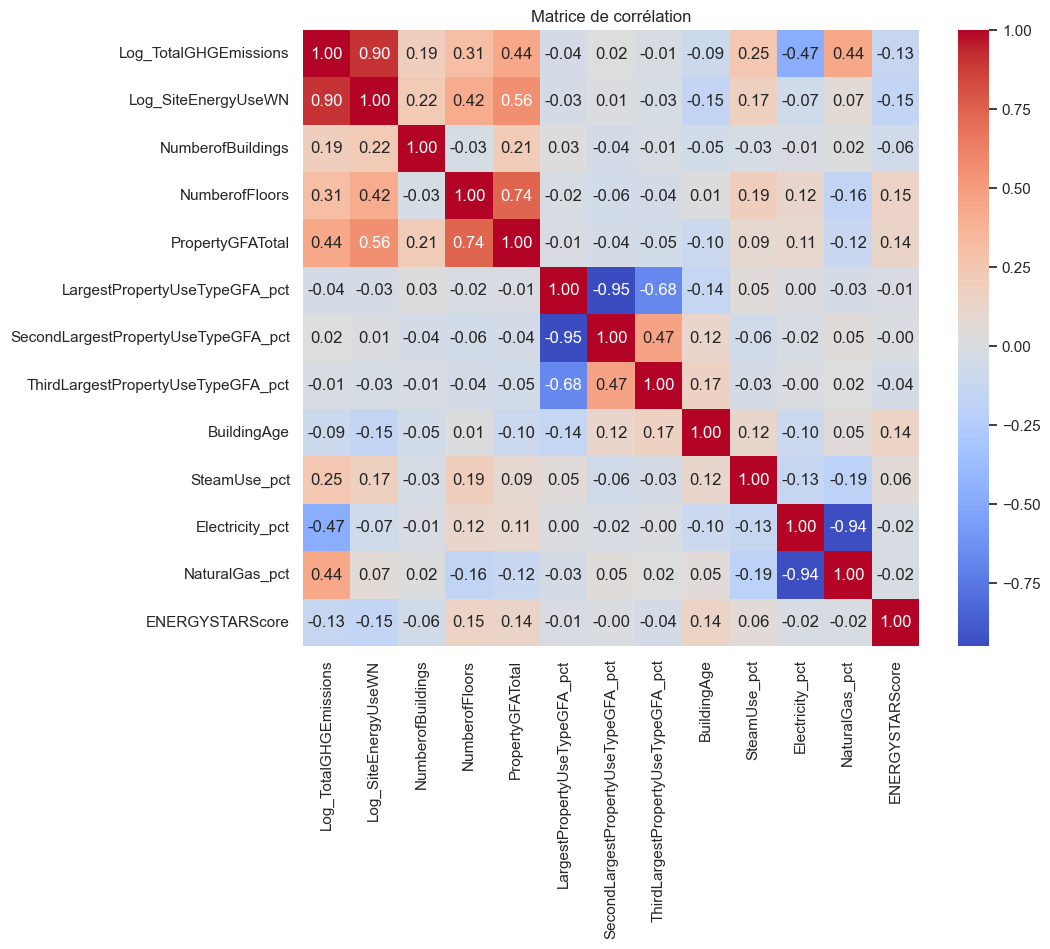

In [355]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()